**Notebook for Arm UNICEF Disaster Vulnerability Challenge.**

This starter notebook is designed for participants in the competition. It employs the Hugging Face Transformers library and PyTorch Lightning to streamline the development of deep learning models. With this setup, I achieved a preliminary score of approximately 0.4, using the same model I useג here. The dataset provided has been annotated following the COCO format, which facilitates a wide range of object detection and segmentation tasks. submission code is also provided.

You're encouraged to experiment and iterate on this foundation to improve your results.

In [1]:
from PIL import Image, ImageDraw
import pandas as pd
import json
import os
import ast
from sklearn.model_selection import train_test_split
import wandb
from pytorch_lightning.loggers import WandbLogger
import torchvision
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import matplotlib.pyplot as plt

Adjust the folders names.

In [2]:
COCO_DATASET = "dataset_coco_format.json"
DATA_FOLDER ='./data/'
TEST_CSV = './data/Test.csv'
IMAGE_FOLDER = './data/Images/'
TRAIN_CSV = "./data/Train.csv"
labels_dict = {1 : "Other", 2: "Tin" , 3 : "Thatch"}

In [3]:
train = pd.read_csv(TRAIN_CSV, header=0)
train.dropna(inplace=True)

train['bbox'] = train['bbox'].apply(ast.literal_eval)

# Initialize the COCO format dictionary
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "Other"},
        {"id": 2, "name": "Tin"},
        {"id": 3, "name": "Thatch"}
    ]
}
index_dict = {}
i = 0
unique_image_ids = train['image_id'].unique()
for image_id in unique_image_ids:
    index_dict[image_id] = i
    i += 1


# Helper function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


if __name__ == '__main__':
    # Populate images section
    unique_image_ids = train['image_id'].unique()
    for image_id in unique_image_ids:
        file_name = f"{image_id}.tif"  # Adjust the extension if needed
        image_path = os.path.join(IMAGE_FOLDER, file_name)
        width, height = get_image_dimensions(image_path)
        coco_format["images"].append({
            "id": index_dict[image_id],
            "file_name": file_name,
            "width": width,
            "height": height
        })

    # Annotations
    for index, row in train.iterrows():
        annotation = {
            "id": index,
            "image_id": index_dict[row["image_id"]],
            "category_id": int(row["category_id"]),
            "bbox": row["bbox"],
            "area": row["bbox"][2] * row["bbox"][3],  # width * height
            "iscrowd": 0,
            "segmentation": []  # Empty if not using segmentation
        }
        coco_format["annotations"].append(annotation)

    # Save to JSON
    with open('data/dataset_coco_format.json', 'w') as f:
        json.dump(coco_format, f, indent=4)


In [4]:
PROJECT_NAME = 'detr_hous_count'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Getting_started_detr_hf.ipynb'

wandb.login()
wandb.init(project=PROJECT_NAME)

wandb_logger = WandbLogger(name="MyModelRun", project=PROJECT_NAME)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Getting_started_detr_hf.ipynb.
wandb: Currently logged in as: yw373 (yuke). Use `wandb login --relogin` to force relogin


In [5]:

# Load the COCO dataset JSON
with open(os.path.join(DATA_FOLDER, COCO_DATASET), 'r') as f:
    coco = json.load(f)

# Extract annotations and images
annotations = coco['annotations']
images = coco['images']

# Split images directly
images_train, images_val = train_test_split(images, test_size=0.2)

# Get the IDs of the split images
images_train_ids = {img['id'] for img in images_train}
images_val_ids = {img['id'] for img in images_val}

# Filter annotations to only include those present in train/val images
annotations_train = [ann for ann in annotations if ann['image_id'] in images_train_ids]
annotations_val = [ann for ann in annotations if ann['image_id'] in images_val_ids]

# Create new JSON objects for train and validation sets
coco_train = {'images': images_train, 'annotations': annotations_train, 'categories': coco['categories']}
coco_val = {'images': images_val, 'annotations': annotations_val, 'categories': coco['categories']}

# Save new JSON files for train and validation datasets
with open(os.path.join(DATA_FOLDER, 'train.json'), 'w') as f:
    json.dump(coco_train, f)

with open(os.path.join(DATA_FOLDER, 'val.json'), 'w') as f:
    json.dump(coco_val, f)


In [6]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder,ann_file , processor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return pixel_values, target

In [7]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=IMAGE_FOLDER,ann_file='data/train.json', processor=processor)
val_dataset = CocoDetection(img_folder=IMAGE_FOLDER,ann_file='data/val.json', processor=processor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

/Users/yuke/opt/anaconda3/envs/zindi/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 1972
Number of validation examples: 493


Image n°1054


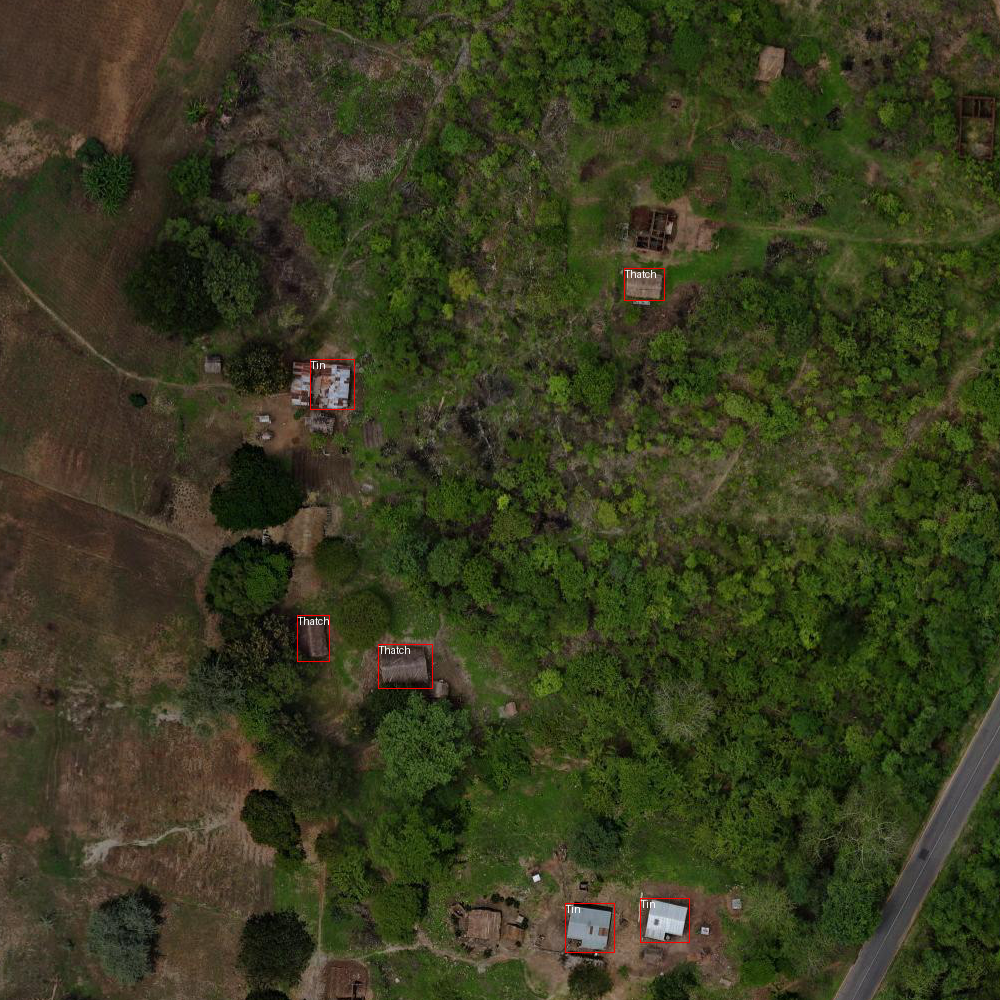

In [8]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(IMAGE_FOLDER, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

In [9]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4)

In [10]:
class Detr(pl.LightningModule):
    def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            revision="no_timm",
                                                            num_labels=3,
                                                            ignore_mismatched_sizes=True)
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                      weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [11]:
def plot_results(img_name):
    image = Image.open(os.path.join(IMAGE_FOLDER, f'{img_name}.tif'))
   
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    print("Outputs:", outputs.keys())    
    postprocessed_outputs  =  processor.post_process_object_detection(outputs,
                                                        target_sizes=[(height, width)],
                                                        threshold=0.9)
    results = postprocessed_outputs[0]

    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for score, label, (xmin, ymin, xmax, ymax)  in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, linewidth=3))
        text = f'{labels_dict[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [12]:
def count_labels(counts):
    labels = {1:0,2:0,3:0}
    counts_cpu = counts.cpu().numpy()
    for i in counts_cpu:
         labels[i] +=1
    return labels

In [19]:
from modal import App, Image, Mount, Volume
model_repo_id = "facebook/detr-resnet-50"

app = App(
    "zindi-project"
) 
modal_image = (
    Image.debian_slim()
    .pip_install(
        "huggingface-hub==0.16.4",
        "Pillow",
        "timm",
        "transformers",
        "pytorch_lightning",
        "pycocotools",
        "wandb",
        "scipy",
        "pandas"
    )
    .apt_install("fonts-freefont-ttf")
)

with modal_image.imports():
    import torch
    from huggingface_hub import snapshot_download
    from PIL import Image, ImageColor, ImageDraw, ImageFont
    from transformers import DetrForObjectDetection, DetrImageProcessor
    
volume = Volume.from_name("zindi-volume", create_if_missing=True)

In [24]:

@app.function(
    gpu="T4:1",
    image=modal_image,
    mounts=[Mount.from_local_dir("/Users/yuke/Desktop/CS231N/Final Project/arm-unicef-disaster-vulnerability-challenge/data", remote_path="/root/data")],
    volumes={"/root/results": volume},
    timeout=86400
)
def run_training():
    model = Detr()
    trainer = Trainer(max_epochs=10, accelerator='gpu',default_root_dir="/root/results")
    trainer.fit(model)
    test_df = pd.read_csv(TEST_CSV)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # test_list = test_df['image_id'].to_list()
    # random_img = random.choice(test_list)
    # plot_results(random_img)
    
    submission_df = pd.DataFrame(columns=["image_id", "Target"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    for image_name in test_df['image_id']:
        image = Image.open(os.path.join(IMAGE_FOLDER, f'{image_name}.tif'))

        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
        result_dict = count_labels(results['labels']) 
        df = pd.DataFrame({"image_id" : [f"{image_name}_1",
                                        f"{image_name}_2",
                                        f"{image_name}_3"],
                        "Target" : [result_dict[1], result_dict[2], result_dict[3]]},columns=["image_id", "Target"])
        submission_df = pd.concat([submission_df, df]) 
    submission_df.to_csv("/root/results/submission.csv", index=False)
    volume.commit()
    print("Successfully wrote submission csv to Modal volume")

In [25]:
with app.run():
    run_training.remote()

Output()

✓ Initialized. View run at https://modal.com/yukew1998/apps/ap-6oedKt1jynAdmoWORIMYTa

Output()

/Users/yuke/opt/anaconda3/envs/zindi/lib/python3.11/site-packages/modal/functions.py:537: UserWarning: Function 
<function run_training at 0x16cea9b20> has size 2946098 bytes when packaged. This is larger than the recommended 
limit of 256 KiB. Try reducing the size of the closure by using parameters or mounts, not large global variables.
  warnings.warn(

✓ Created objects.
├── 🔨 Created mount PythonPackage:_remote_module_non_scriptable
├── 🔨 Created mount /Users/yuke/Desktop/CS231N/Final Project/arm-unicef-disaster-vulnerability-challenge/data
└── 🔨 Created run_training.

Output()

/usr/local/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


/usr/local/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


/usr/local/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


/usr/local/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Downloading config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]


Downloading config.json: 100%|██████████| 6.60k/6.60k [00:00<00:00, 18.6MB/s]


Downloading pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]


Downloading pytorch_model.bin:  25%|██▌       | 41.9M/167M [00:00<00:00, 350MB/s]


Downloading pytorch_model.bin:  50%|█████     | 83.9M/167M [00:00<00:00, 368MB/s]


Downloading pytorch_model.bin:  75%|███████▌  | 126M/167M [00:00<00:00, 376MB/s] 


Downloading pytorch_model.bin: 100%|██████████| 167M/167M [00:00<00:00, 380MB/s]Downloading pytorch_model.bin: 100%|██████████| 167M/167M [00:00<00:00, 372MB/s]


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)


/usr/local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=4` in the `DataLoader` to improve performance.


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]


/usr/local/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.64it/s]


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.97it/s]


/usr/local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=4` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Training:   0%|          | 0/247 [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/247 [00:00<?, ?it/s] 


Epoch 0:   0%|          | 1/247 [00:01<05:47,  0.71it/s]


Epoch 0:   0%|          | 1/247 [00:01<05:47,  0.71it/s, v_num=1]


Epoch 0:   1%|          | 2/247 [00:02<04:59,  0.82it/s, v_num=1]


Epoch 0:   1%|          | 2/247 [00:02<04:59,  0.82it/s, v_num=1]


Epoch 0:   1%|          | 3/247 [00:03<04:39,  0.87it/s, v_num=1]


Epoch 0:   1%|          | 3/247 [00:03<04:39,  0.87it/s, v_num=1]


Epoch 0:   2%|▏         | 4/247 [00:04<04:27,  0.91it/s, v_num=1]


Epoch 0:   2%|▏         | 4/247 [00:04<04:27,  0.91it/s, v_num=1]


Epoch 0:   2%|▏         | 5/247 [00:05<04:21,  0.92it/s, v_num=1]


Epoch 0:   2%|▏         | 5/247 [00:05<04:21,  0.92it/s, v_num=1]


Epoch 0:   2%|▏         | 6/247 [00:06<04:17,  0.94it/s, v_num=1]


Epoch 0:   2%|▏         | 6/247 [00:06<04:17,  0.94it/s, v_num=1]


Epoch 0:   3%|▎         | 7/247 [00:07<04:13,  0.95it/s, v_num=1]


Epoch 0:   3%|▎         | 7/247 [00:07<04:13,  0.95it/s, v_num=1]


Epoch 0:   3%|▎         | 8/247 [00:08<04:09,  0.96it/s, v_num=1]


Epoch 0:   3%|▎         | 8/247 [00:08<04:09,  0.96it/s, v_num=1]


Epoch 0:   4%|▎         | 9/247 [00:09<04:04,  0.97it/s, v_num=1]


Epoch 0:   4%|▎         | 9/247 [00:09<04:04,  0.97it/s, v_num=1]


Epoch 0:   4%|▍         | 10/247 [00:10<04:01,  0.98it/s, v_num=1]


Epoch 0:   4%|▍         | 10/247 [00:10<04:01,  0.98it/s, v_num=1]


Epoch 0:   4%|▍         | 11/247 [00:11<03:58,  0.99it/s, v_num=1]


Epoch 0:   4%|▍         | 11/247 [00:11<03:58,  0.99it/s, v_num=1]


Epoch 0:   5%|▍         | 12/247 [00:12<03:56,  0.99it/s, v_num=1]


Epoch 0:   5%|▍         | 12/247 [00:12<03:56,  0.99it/s, v_num=1]


Epoch 0:   5%|▌         | 13/247 [00:13<03:54,  1.00it/s, v_num=1]


Epoch 0:   5%|▌         | 13/247 [00:13<03:54,  1.00it/s, v_num=1]


Epoch 0:   6%|▌         | 14/247 [00:13<03:51,  1.01it/s, v_num=1]


Epoch 0:   6%|▌         | 14/247 [00:13<03:51,  1.01it/s, v_num=1]


Epoch 0:   6%|▌         | 15/247 [00:14<03:49,  1.01it/s, v_num=1]


Epoch 0:   6%|▌         | 15/247 [00:14<03:49,  1.01it/s, v_num=1]

Epoch 0:   6%|▋         | 16/247 [00:15<03:48,  1.01it/s, v_num=1]


Epoch 0:   6%|▋         | 16/247 [00:15<03:48,  1.01it/s, v_num=1]


Epoch 0:   7%|▋         | 17/247 [00:16<03:46,  1.02it/s, v_num=1]


Epoch 0:   7%|▋         | 17/247 [00:16<03:46,  1.02it/s, v_num=1]


Epoch 0:   7%|▋         | 18/247 [00:17<03:44,  1.02it/s, v_num=1]


Epoch 0:   7%|▋         | 18/247 [00:17<03:44,  1.02it/s, v_num=1]


Epoch 0:   8%|▊         | 19/247 [00:18<03:43,  1.02it/s, v_num=1]


Epoch 0:   8%|▊         | 19/247 [00:18<03:43,  1.02it/s, v_num=1]


Epoch 0:   8%|▊         | 20/247 [00:19<03:41,  1.02it/s, v_num=1]


Epoch 0:   8%|▊         | 20/247 [00:19<03:41,  1.02it/s, v_num=1]


Epoch 0:   9%|▊         | 21/247 [00:20<03:40,  1.03it/s, v_num=1]


Epoch 0:   9%|▊         | 21/247 [00:20<03:40,  1.03it/s, v_num=1]


Epoch 0:   9%|▉         | 22/247 [00:21<03:38,  1.03it/s, v_num=1]


Epoch 0:   9%|▉         | 22/247 [00:21<03:38,  1.03it/s, v_num=1]


Epoch 0:   9%|▉         | 23/247 [00:22<03:37,  1.03it/s, v_num=1]


Epoch 0:   9%|▉         | 23/247 [00:22<03:37,  1.03it/s, v_num=1]


Epoch 0:  10%|▉         | 24/247 [00:23<03:36,  1.03it/s, v_num=1]


Epoch 0:  10%|▉         | 24/247 [00:23<03:36,  1.03it/s, v_num=1]


Epoch 0:  10%|█         | 25/247 [00:24<03:35,  1.03it/s, v_num=1]


Epoch 0:  10%|█         | 25/247 [00:24<03:35,  1.03it/s, v_num=1]


Epoch 0:  11%|█         | 26/247 [00:25<03:34,  1.03it/s, v_num=1]


Epoch 0:  11%|█         | 26/247 [00:25<03:34,  1.03it/s, v_num=1]


Epoch 0:  11%|█         | 27/247 [00:26<03:32,  1.03it/s, v_num=1]


Epoch 0:  11%|█         | 27/247 [00:26<03:32,  1.03it/s, v_num=1]


Epoch 0:  11%|█▏        | 28/247 [00:27<03:31,  1.04it/s, v_num=1]


Epoch 0:  11%|█▏        | 28/247 [00:27<03:31,  1.04it/s, v_num=1]


Epoch 0:  12%|█▏        | 29/247 [00:27<03:30,  1.04it/s, v_num=1]


Epoch 0:  12%|█▏        | 29/247 [00:27<03:30,  1.04it/s, v_num=1]


Epoch 0:  12%|█▏        | 30/247 [00:28<03:29,  1.04it/s, v_num=1]


Epoch 0:  12%|█▏        | 30/247 [00:28<03:29,  1.04it/s, v_num=1]


Epoch 0:  13%|█▎        | 31/247 [00:29<03:28,  1.04it/s, v_num=1]


Epoch 0:  13%|█▎        | 31/247 [00:29<03:28,  1.04it/s, v_num=1]


Epoch 0:  13%|█▎        | 32/247 [00:30<03:27,  1.04it/s, v_num=1]


Epoch 0:  13%|█▎        | 32/247 [00:30<03:27,  1.04it/s, v_num=1]


Epoch 0:  13%|█▎        | 33/247 [00:31<03:27,  1.03it/s, v_num=1]


Epoch 0:  13%|█▎        | 33/247 [00:31<03:27,  1.03it/s, v_num=1]


Epoch 0:  14%|█▍        | 34/247 [00:32<03:26,  1.03it/s, v_num=1]


Epoch 0:  14%|█▍        | 34/247 [00:32<03:26,  1.03it/s, v_num=1]


Epoch 0:  14%|█▍        | 35/247 [00:33<03:25,  1.03it/s, v_num=1]


Epoch 0:  14%|█▍        | 35/247 [00:33<03:25,  1.03it/s, v_num=1]


Epoch 0:  15%|█▍        | 36/247 [00:34<03:24,  1.03it/s, v_num=1]


Epoch 0:  15%|█▍        | 36/247 [00:34<03:24,  1.03it/s, v_num=1]


Epoch 0:  15%|█▍        | 37/247 [00:35<03:23,  1.03it/s, v_num=1]


Epoch 0:  15%|█▍        | 37/247 [00:35<03:23,  1.03it/s, v_num=1]


Epoch 0:  15%|█▌        | 38/247 [00:36<03:22,  1.03it/s, v_num=1]


Epoch 0:  15%|█▌        | 38/247 [00:36<03:22,  1.03it/s, v_num=1]


Epoch 0:  16%|█▌        | 39/247 [00:37<03:21,  1.03it/s, v_num=1]


Epoch 0:  16%|█▌        | 39/247 [00:37<03:21,  1.03it/s, v_num=1]


Epoch 0:  16%|█▌        | 40/247 [00:38<03:20,  1.03it/s, v_num=1]


Epoch 0:  16%|█▌        | 40/247 [00:38<03:20,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 41/247 [00:39<03:19,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 41/247 [00:39<03:19,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 42/247 [00:40<03:18,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 42/247 [00:40<03:18,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 43/247 [00:41<03:17,  1.03it/s, v_num=1]


Epoch 0:  17%|█▋        | 43/247 [00:41<03:17,  1.03it/s, v_num=1]


Epoch 0:  18%|█▊        | 44/247 [00:42<03:16,  1.03it/s, v_num=1]


Epoch 0:  18%|█▊        | 44/247 [00:42<03:16,  1.03it/s, v_num=1]


Epoch 0:  18%|█▊        | 45/247 [00:43<03:15,  1.03it/s, v_num=1]


Epoch 0:  18%|█▊        | 45/247 [00:43<03:15,  1.03it/s, v_num=1]


Epoch 0:  19%|█▊        | 46/247 [00:44<03:14,  1.03it/s, v_num=1]


Epoch 0:  19%|█▊        | 46/247 [00:44<03:14,  1.03it/s, v_num=1]


Epoch 0:  19%|█▉        | 47/247 [00:45<03:13,  1.03it/s, v_num=1]


Epoch 0:  19%|█▉        | 47/247 [00:45<03:13,  1.03it/s, v_num=1]


Epoch 0:  19%|█▉        | 48/247 [00:46<03:13,  1.03it/s, v_num=1]


Epoch 0:  19%|█▉        | 48/247 [00:46<03:13,  1.03it/s, v_num=1]


Epoch 0:  20%|█▉        | 49/247 [00:47<03:13,  1.02it/s, v_num=1]


Epoch 0:  20%|█▉        | 49/247 [00:47<03:13,  1.02it/s, v_num=1]


Epoch 0:  20%|██        | 50/247 [00:48<03:12,  1.02it/s, v_num=1]


Epoch 0:  20%|██        | 50/247 [00:48<03:12,  1.02it/s, v_num=1]


Epoch 0:  21%|██        | 51/247 [00:49<03:11,  1.02it/s, v_num=1]


Epoch 0:  21%|██        | 51/247 [00:49<03:11,  1.02it/s, v_num=1]


Epoch 0:  21%|██        | 52/247 [00:50<03:10,  1.02it/s, v_num=1]


Epoch 0:  21%|██        | 52/247 [00:50<03:10,  1.02it/s, v_num=1]


Epoch 0:  21%|██▏       | 53/247 [00:51<03:09,  1.02it/s, v_num=1]


Epoch 0:  21%|██▏       | 53/247 [00:51<03:09,  1.02it/s, v_num=1]


Epoch 0:  22%|██▏       | 54/247 [00:52<03:08,  1.02it/s, v_num=1]


Epoch 0:  22%|██▏       | 54/247 [00:52<03:08,  1.02it/s, v_num=1]


Epoch 0:  22%|██▏       | 55/247 [00:53<03:07,  1.02it/s, v_num=1]


Epoch 0:  22%|██▏       | 55/247 [00:53<03:07,  1.02it/s, v_num=1]


Epoch 0:  23%|██▎       | 56/247 [00:54<03:06,  1.02it/s, v_num=1]


Epoch 0:  23%|██▎       | 56/247 [00:54<03:06,  1.02it/s, v_num=1]


Epoch 0:  23%|██▎       | 57/247 [00:55<03:05,  1.03it/s, v_num=1]


Epoch 0:  23%|██▎       | 57/247 [00:55<03:05,  1.03it/s, v_num=1]


Epoch 0:  23%|██▎       | 58/247 [00:56<03:04,  1.03it/s, v_num=1]


Epoch 0:  23%|██▎       | 58/247 [00:56<03:04,  1.03it/s, v_num=1]


Epoch 0:  24%|██▍       | 59/247 [00:57<03:02,  1.03it/s, v_num=1]


Epoch 0:  24%|██▍       | 59/247 [00:57<03:02,  1.03it/s, v_num=1]


Epoch 0:  24%|██▍       | 60/247 [00:58<03:01,  1.03it/s, v_num=1]


Epoch 0:  24%|██▍       | 60/247 [00:58<03:01,  1.03it/s, v_num=1]


Epoch 0:  25%|██▍       | 61/247 [00:59<03:00,  1.03it/s, v_num=1]


Epoch 0:  25%|██▍       | 61/247 [00:59<03:00,  1.03it/s, v_num=1]


Epoch 0:  25%|██▌       | 62/247 [01:00<02:59,  1.03it/s, v_num=1]


Epoch 0:  25%|██▌       | 62/247 [01:00<02:59,  1.03it/s, v_num=1]


Epoch 0:  26%|██▌       | 63/247 [01:01<02:58,  1.03it/s, v_num=1]


Epoch 0:  26%|██▌       | 63/247 [01:01<02:58,  1.03it/s, v_num=1]


Epoch 0:  26%|██▌       | 64/247 [01:02<02:57,  1.03it/s, v_num=1]


Epoch 0:  26%|██▌       | 64/247 [01:02<02:57,  1.03it/s, v_num=1]


Epoch 0:  26%|██▋       | 65/247 [01:02<02:56,  1.03it/s, v_num=1]


Epoch 0:  26%|██▋       | 65/247 [01:02<02:56,  1.03it/s, v_num=1]


Epoch 0:  27%|██▋       | 66/247 [01:03<02:55,  1.03it/s, v_num=1]


Epoch 0:  27%|██▋       | 66/247 [01:03<02:55,  1.03it/s, v_num=1]


Epoch 0:  27%|██▋       | 67/247 [01:04<02:54,  1.03it/s, v_num=1]


Epoch 0:  27%|██▋       | 67/247 [01:04<02:54,  1.03it/s, v_num=1]


Epoch 0:  28%|██▊       | 68/247 [01:05<02:53,  1.03it/s, v_num=1]


Epoch 0:  28%|██▊       | 68/247 [01:05<02:53,  1.03it/s, v_num=1]


Epoch 0:  28%|██▊       | 69/247 [01:06<02:52,  1.03it/s, v_num=1]


Epoch 0:  28%|██▊       | 69/247 [01:06<02:52,  1.03it/s, v_num=1]

Epoch 0:  28%|██▊       | 70/247 [01:07<02:51,  1.03it/s, v_num=1]


Epoch 0:  28%|██▊       | 70/247 [01:07<02:51,  1.03it/s, v_num=1]


Epoch 0:  29%|██▊       | 71/247 [01:08<02:50,  1.03it/s, v_num=1]


Epoch 0:  29%|██▊       | 71/247 [01:08<02:50,  1.03it/s, v_num=1]


Epoch 0:  29%|██▉       | 72/247 [01:09<02:49,  1.03it/s, v_num=1]


Epoch 0:  29%|██▉       | 72/247 [01:09<02:49,  1.03it/s, v_num=1]


Epoch 0:  30%|██▉       | 73/247 [01:10<02:48,  1.03it/s, v_num=1]


Epoch 0:  30%|██▉       | 73/247 [01:10<02:48,  1.03it/s, v_num=1]


Epoch 0:  30%|██▉       | 74/247 [01:11<02:47,  1.03it/s, v_num=1]


Epoch 0:  30%|██▉       | 74/247 [01:11<02:47,  1.03it/s, v_num=1]


Epoch 0:  30%|███       | 75/247 [01:12<02:46,  1.03it/s, v_num=1]


Epoch 0:  30%|███       | 75/247 [01:12<02:46,  1.03it/s, v_num=1]


Epoch 0:  31%|███       | 76/247 [01:13<02:45,  1.03it/s, v_num=1]


Epoch 0:  31%|███       | 76/247 [01:13<02:45,  1.03it/s, v_num=1]


Epoch 0:  31%|███       | 77/247 [01:14<02:44,  1.03it/s, v_num=1]


Epoch 0:  31%|███       | 77/247 [01:14<02:44,  1.03it/s, v_num=1]


Epoch 0:  32%|███▏      | 78/247 [01:15<02:43,  1.04it/s, v_num=1]


Epoch 0:  32%|███▏      | 78/247 [01:15<02:43,  1.04it/s, v_num=1]


Epoch 0:  32%|███▏      | 79/247 [01:16<02:42,  1.04it/s, v_num=1]


Epoch 0:  32%|███▏      | 79/247 [01:16<02:42,  1.04it/s, v_num=1]


Epoch 0:  32%|███▏      | 80/247 [01:17<02:41,  1.04it/s, v_num=1]


Epoch 0:  32%|███▏      | 80/247 [01:17<02:41,  1.04it/s, v_num=1]


Epoch 0:  33%|███▎      | 81/247 [01:18<02:40,  1.04it/s, v_num=1]


Epoch 0:  33%|███▎      | 81/247 [01:18<02:40,  1.04it/s, v_num=1]


Epoch 0:  33%|███▎      | 82/247 [01:19<02:39,  1.04it/s, v_num=1]


Epoch 0:  33%|███▎      | 82/247 [01:19<02:39,  1.04it/s, v_num=1]


Epoch 0:  34%|███▎      | 83/247 [01:20<02:38,  1.04it/s, v_num=1]


Epoch 0:  34%|███▎      | 83/247 [01:20<02:38,  1.04it/s, v_num=1]


Epoch 0:  34%|███▍      | 84/247 [01:21<02:37,  1.04it/s, v_num=1]


Epoch 0:  34%|███▍      | 84/247 [01:21<02:37,  1.04it/s, v_num=1]


Epoch 0:  34%|███▍      | 85/247 [01:22<02:36,  1.04it/s, v_num=1]


Epoch 0:  34%|███▍      | 85/247 [01:22<02:36,  1.04it/s, v_num=1]


Epoch 0:  35%|███▍      | 86/247 [01:23<02:35,  1.04it/s, v_num=1]


Epoch 0:  35%|███▍      | 86/247 [01:23<02:35,  1.04it/s, v_num=1]


Epoch 0:  35%|███▌      | 87/247 [01:23<02:34,  1.04it/s, v_num=1]


Epoch 0:  35%|███▌      | 87/247 [01:23<02:34,  1.04it/s, v_num=1]


Epoch 0:  36%|███▌      | 88/247 [01:24<02:33,  1.04it/s, v_num=1]


Epoch 0:  36%|███▌      | 88/247 [01:24<02:33,  1.04it/s, v_num=1]


Epoch 0:  36%|███▌      | 89/247 [01:25<02:32,  1.04it/s, v_num=1]


Epoch 0:  36%|███▌      | 89/247 [01:25<02:32,  1.04it/s, v_num=1]


Epoch 0:  36%|███▋      | 90/247 [01:26<02:31,  1.04it/s, v_num=1]


Epoch 0:  36%|███▋      | 90/247 [01:26<02:31,  1.04it/s, v_num=1]


Epoch 0:  37%|███▋      | 91/247 [01:27<02:30,  1.04it/s, v_num=1]


Epoch 0:  37%|███▋      | 91/247 [01:27<02:30,  1.04it/s, v_num=1]


Epoch 0:  37%|███▋      | 92/247 [01:28<02:29,  1.04it/s, v_num=1]


Epoch 0:  37%|███▋      | 92/247 [01:28<02:29,  1.04it/s, v_num=1]


Epoch 0:  38%|███▊      | 93/247 [01:29<02:28,  1.03it/s, v_num=1]


Epoch 0:  38%|███▊      | 93/247 [01:29<02:28,  1.03it/s, v_num=1]


Epoch 0:  38%|███▊      | 94/247 [01:30<02:27,  1.03it/s, v_num=1]


Epoch 0:  38%|███▊      | 94/247 [01:30<02:27,  1.03it/s, v_num=1]


Epoch 0:  38%|███▊      | 95/247 [01:31<02:26,  1.03it/s, v_num=1]


Epoch 0:  38%|███▊      | 95/247 [01:31<02:26,  1.03it/s, v_num=1]


Epoch 0:  39%|███▉      | 96/247 [01:32<02:25,  1.04it/s, v_num=1]


Epoch 0:  39%|███▉      | 96/247 [01:32<02:25,  1.04it/s, v_num=1]


Epoch 0:  39%|███▉      | 97/247 [01:33<02:24,  1.04it/s, v_num=1]


Epoch 0:  39%|███▉      | 97/247 [01:33<02:24,  1.04it/s, v_num=1]


Epoch 0:  40%|███▉      | 98/247 [01:34<02:23,  1.04it/s, v_num=1]


Epoch 0:  40%|███▉      | 98/247 [01:34<02:23,  1.04it/s, v_num=1]


Epoch 0:  40%|████      | 99/247 [01:35<02:22,  1.04it/s, v_num=1]


Epoch 0:  40%|████      | 99/247 [01:35<02:22,  1.04it/s, v_num=1]


Epoch 0:  40%|████      | 100/247 [01:36<02:21,  1.04it/s, v_num=1]


Epoch 0:  40%|████      | 100/247 [01:36<02:21,  1.04it/s, v_num=1]


Epoch 0:  41%|████      | 101/247 [01:37<02:21,  1.03it/s, v_num=1]


Epoch 0:  41%|████      | 101/247 [01:37<02:21,  1.03it/s, v_num=1]


Epoch 0:  41%|████▏     | 102/247 [01:38<02:20,  1.03it/s, v_num=1]


Epoch 0:  41%|████▏     | 102/247 [01:38<02:20,  1.03it/s, v_num=1]


Epoch 0:  42%|████▏     | 103/247 [01:39<02:19,  1.03it/s, v_num=1]


Epoch 0:  42%|████▏     | 103/247 [01:39<02:19,  1.03it/s, v_num=1]


Epoch 0:  42%|████▏     | 104/247 [01:40<02:18,  1.03it/s, v_num=1]


Epoch 0:  42%|████▏     | 104/247 [01:40<02:18,  1.03it/s, v_num=1]


Epoch 0:  43%|████▎     | 105/247 [01:41<02:17,  1.03it/s, v_num=1]


Epoch 0:  43%|████▎     | 105/247 [01:41<02:17,  1.03it/s, v_num=1]


Epoch 0:  43%|████▎     | 106/247 [01:42<02:16,  1.04it/s, v_num=1]


Epoch 0:  43%|████▎     | 106/247 [01:42<02:16,  1.04it/s, v_num=1]


Epoch 0:  43%|████▎     | 107/247 [01:43<02:15,  1.04it/s, v_num=1]


Epoch 0:  43%|████▎     | 107/247 [01:43<02:15,  1.04it/s, v_num=1]


Epoch 0:  44%|████▎     | 108/247 [01:44<02:14,  1.04it/s, v_num=1]


Epoch 0:  44%|████▎     | 108/247 [01:44<02:14,  1.04it/s, v_num=1]


Epoch 0:  44%|████▍     | 109/247 [01:45<02:13,  1.04it/s, v_num=1]


Epoch 0:  44%|████▍     | 109/247 [01:45<02:13,  1.04it/s, v_num=1]


Epoch 0:  45%|████▍     | 110/247 [01:46<02:12,  1.04it/s, v_num=1]


Epoch 0:  45%|████▍     | 110/247 [01:46<02:12,  1.04it/s, v_num=1]


Epoch 0:  45%|████▍     | 111/247 [01:47<02:11,  1.04it/s, v_num=1]


Epoch 0:  45%|████▍     | 111/247 [01:47<02:11,  1.04it/s, v_num=1]


Epoch 0:  45%|████▌     | 112/247 [01:48<02:10,  1.04it/s, v_num=1]


Epoch 0:  45%|████▌     | 112/247 [01:48<02:10,  1.04it/s, v_num=1]


Epoch 0:  46%|████▌     | 113/247 [01:49<02:09,  1.04it/s, v_num=1]


Epoch 0:  46%|████▌     | 113/247 [01:49<02:09,  1.04it/s, v_num=1]


Epoch 0:  46%|████▌     | 114/247 [01:50<02:08,  1.04it/s, v_num=1]


Epoch 0:  46%|████▌     | 114/247 [01:50<02:08,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 115/247 [01:51<02:07,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 115/247 [01:51<02:07,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 116/247 [01:52<02:06,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 116/247 [01:52<02:06,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 117/247 [01:52<02:05,  1.04it/s, v_num=1]


Epoch 0:  47%|████▋     | 117/247 [01:52<02:05,  1.04it/s, v_num=1]


Epoch 0:  48%|████▊     | 118/247 [01:53<02:04,  1.04it/s, v_num=1]


Epoch 0:  48%|████▊     | 118/247 [01:53<02:04,  1.04it/s, v_num=1]


Epoch 0:  48%|████▊     | 119/247 [01:54<02:03,  1.04it/s, v_num=1]


Epoch 0:  48%|████▊     | 119/247 [01:54<02:03,  1.04it/s, v_num=1]


Epoch 0:  49%|████▊     | 120/247 [01:55<02:02,  1.04it/s, v_num=1]


Epoch 0:  49%|████▊     | 120/247 [01:55<02:02,  1.04it/s, v_num=1]


Epoch 0:  49%|████▉     | 121/247 [01:56<02:01,  1.04it/s, v_num=1]


Epoch 0:  49%|████▉     | 121/247 [01:56<02:01,  1.04it/s, v_num=1]


Epoch 0:  49%|████▉     | 122/247 [01:57<02:00,  1.04it/s, v_num=1]


Epoch 0:  49%|████▉     | 122/247 [01:57<02:00,  1.04it/s, v_num=1]


Epoch 0:  50%|████▉     | 123/247 [01:58<01:59,  1.04it/s, v_num=1]


Epoch 0:  50%|████▉     | 123/247 [01:58<01:59,  1.04it/s, v_num=1]


Epoch 0:  50%|█████     | 124/247 [01:59<01:58,  1.04it/s, v_num=1]


Epoch 0:  50%|█████     | 124/247 [01:59<01:58,  1.04it/s, v_num=1]


Epoch 0:  51%|█████     | 125/247 [02:00<01:57,  1.04it/s, v_num=1]


Epoch 0:  51%|█████     | 125/247 [02:00<01:57,  1.04it/s, v_num=1]

Epoch 0:  51%|█████     | 126/247 [02:01<01:56,  1.04it/s, v_num=1]


Epoch 0:  51%|█████     | 126/247 [02:01<01:56,  1.04it/s, v_num=1]


Epoch 0:  51%|█████▏    | 127/247 [02:02<01:55,  1.04it/s, v_num=1]


Epoch 0:  51%|█████▏    | 127/247 [02:02<01:55,  1.04it/s, v_num=1]


Epoch 0:  52%|█████▏    | 128/247 [02:03<01:55,  1.03it/s, v_num=1]


Epoch 0:  52%|█████▏    | 128/247 [02:03<01:55,  1.03it/s, v_num=1]


Epoch 0:  52%|█████▏    | 129/247 [02:04<01:54,  1.03it/s, v_num=1]


Epoch 0:  52%|█████▏    | 129/247 [02:04<01:54,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 130/247 [02:05<01:53,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 130/247 [02:05<01:53,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 131/247 [02:06<01:52,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 131/247 [02:06<01:52,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 132/247 [02:07<01:51,  1.03it/s, v_num=1]


Epoch 0:  53%|█████▎    | 132/247 [02:07<01:51,  1.03it/s, v_num=1]


Epoch 0:  54%|█████▍    | 133/247 [02:08<01:50,  1.03it/s, v_num=1]


Epoch 0:  54%|█████▍    | 133/247 [02:08<01:50,  1.03it/s, v_num=1]


Epoch 0:  54%|█████▍    | 134/247 [02:09<01:49,  1.03it/s, v_num=1]


Epoch 0:  54%|█████▍    | 134/247 [02:09<01:49,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▍    | 135/247 [02:10<01:48,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▍    | 135/247 [02:10<01:48,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▌    | 136/247 [02:11<01:47,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▌    | 136/247 [02:11<01:47,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▌    | 137/247 [02:12<01:46,  1.03it/s, v_num=1]


Epoch 0:  55%|█████▌    | 137/247 [02:12<01:46,  1.03it/s, v_num=1]


Epoch 0:  56%|█████▌    | 138/247 [02:13<01:45,  1.03it/s, v_num=1]


Epoch 0:  56%|█████▌    | 138/247 [02:13<01:45,  1.03it/s, v_num=1]


Epoch 0:  56%|█████▋    | 139/247 [02:14<01:44,  1.03it/s, v_num=1]


Epoch 0:  56%|█████▋    | 139/247 [02:14<01:44,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 140/247 [02:15<01:43,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 140/247 [02:15<01:43,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 141/247 [02:16<01:42,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 141/247 [02:16<01:42,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 142/247 [02:17<01:41,  1.03it/s, v_num=1]


Epoch 0:  57%|█████▋    | 142/247 [02:17<01:41,  1.03it/s, v_num=1]


Epoch 0:  58%|█████▊    | 143/247 [02:18<01:40,  1.03it/s, v_num=1]


Epoch 0:  58%|█████▊    | 143/247 [02:18<01:40,  1.03it/s, v_num=1]


Epoch 0:  58%|█████▊    | 144/247 [02:19<01:39,  1.03it/s, v_num=1]


Epoch 0:  58%|█████▊    | 144/247 [02:19<01:39,  1.03it/s, v_num=1]


Epoch 0:  59%|█████▊    | 145/247 [02:20<01:38,  1.03it/s, v_num=1]


Epoch 0:  59%|█████▊    | 145/247 [02:20<01:38,  1.03it/s, v_num=1]


Epoch 0:  59%|█████▉    | 146/247 [02:21<01:37,  1.03it/s, v_num=1]


Epoch 0:  59%|█████▉    | 146/247 [02:21<01:37,  1.03it/s, v_num=1]


Epoch 0:  60%|█████▉    | 147/247 [02:22<01:36,  1.03it/s, v_num=1]


Epoch 0:  60%|█████▉    | 147/247 [02:22<01:36,  1.03it/s, v_num=1]


Epoch 0:  60%|█████▉    | 148/247 [02:23<01:35,  1.03it/s, v_num=1]


Epoch 0:  60%|█████▉    | 148/247 [02:23<01:35,  1.03it/s, v_num=1]


Epoch 0:  60%|██████    | 149/247 [02:24<01:34,  1.03it/s, v_num=1]


Epoch 0:  60%|██████    | 149/247 [02:24<01:34,  1.03it/s, v_num=1]


Epoch 0:  61%|██████    | 150/247 [02:25<01:33,  1.03it/s, v_num=1]


Epoch 0:  61%|██████    | 150/247 [02:25<01:33,  1.03it/s, v_num=1]


Epoch 0:  61%|██████    | 151/247 [02:26<01:33,  1.03it/s, v_num=1]


Epoch 0:  61%|██████    | 151/247 [02:26<01:33,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 152/247 [02:27<01:32,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 152/247 [02:27<01:32,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 153/247 [02:28<01:31,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 153/247 [02:28<01:31,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 154/247 [02:29<01:30,  1.03it/s, v_num=1]


Epoch 0:  62%|██████▏   | 154/247 [02:29<01:30,  1.03it/s, v_num=1]


Epoch 0:  63%|██████▎   | 155/247 [02:30<01:29,  1.03it/s, v_num=1]


Epoch 0:  63%|██████▎   | 155/247 [02:30<01:29,  1.03it/s, v_num=1]


Epoch 0:  63%|██████▎   | 156/247 [02:31<01:28,  1.03it/s, v_num=1]


Epoch 0:  63%|██████▎   | 156/247 [02:31<01:28,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▎   | 157/247 [02:32<01:27,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▎   | 157/247 [02:32<01:27,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▍   | 158/247 [02:33<01:26,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▍   | 158/247 [02:33<01:26,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▍   | 159/247 [02:34<01:25,  1.03it/s, v_num=1]


Epoch 0:  64%|██████▍   | 159/247 [02:34<01:25,  1.03it/s, v_num=1]


Epoch 0:  65%|██████▍   | 160/247 [02:35<01:24,  1.03it/s, v_num=1]


Epoch 0:  65%|██████▍   | 160/247 [02:35<01:24,  1.03it/s, v_num=1]


Epoch 0:  65%|██████▌   | 161/247 [02:36<01:23,  1.03it/s, v_num=1]


Epoch 0:  65%|██████▌   | 161/247 [02:36<01:23,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▌   | 162/247 [02:37<01:22,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▌   | 162/247 [02:37<01:22,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▌   | 163/247 [02:38<01:21,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▌   | 163/247 [02:38<01:21,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▋   | 164/247 [02:39<01:20,  1.03it/s, v_num=1]


Epoch 0:  66%|██████▋   | 164/247 [02:39<01:20,  1.03it/s, v_num=1]


Epoch 0:  67%|██████▋   | 165/247 [02:40<01:19,  1.03it/s, v_num=1]


Epoch 0:  67%|██████▋   | 165/247 [02:40<01:19,  1.03it/s, v_num=1]


Epoch 0:  67%|██████▋   | 166/247 [02:41<01:18,  1.03it/s, v_num=1]


Epoch 0:  67%|██████▋   | 166/247 [02:41<01:18,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 167/247 [02:42<01:17,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 167/247 [02:42<01:17,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 168/247 [02:43<01:16,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 168/247 [02:43<01:16,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 169/247 [02:44<01:15,  1.03it/s, v_num=1]


Epoch 0:  68%|██████▊   | 169/247 [02:44<01:15,  1.03it/s, v_num=1]


Epoch 0:  69%|██████▉   | 170/247 [02:44<01:14,  1.03it/s, v_num=1]


Epoch 0:  69%|██████▉   | 170/247 [02:44<01:14,  1.03it/s, v_num=1]


Epoch 0:  69%|██████▉   | 171/247 [02:45<01:13,  1.03it/s, v_num=1]


Epoch 0:  69%|██████▉   | 171/247 [02:46<01:13,  1.03it/s, v_num=1]


Epoch 0:  70%|██████▉   | 172/247 [02:47<01:12,  1.03it/s, v_num=1]


Epoch 0:  70%|██████▉   | 172/247 [02:47<01:12,  1.03it/s, v_num=1]


Epoch 0:  70%|███████   | 173/247 [02:48<01:11,  1.03it/s, v_num=1]


Epoch 0:  70%|███████   | 173/247 [02:48<01:11,  1.03it/s, v_num=1]


Epoch 0:  70%|███████   | 174/247 [02:48<01:10,  1.03it/s, v_num=1]


Epoch 0:  70%|███████   | 174/247 [02:48<01:10,  1.03it/s, v_num=1]


Epoch 0:  71%|███████   | 175/247 [02:49<01:09,  1.03it/s, v_num=1]


Epoch 0:  71%|███████   | 175/247 [02:49<01:09,  1.03it/s, v_num=1]


Epoch 0:  71%|███████▏  | 176/247 [02:50<01:08,  1.03it/s, v_num=1]


Epoch 0:  71%|███████▏  | 176/247 [02:50<01:08,  1.03it/s, v_num=1]


Epoch 0:  72%|███████▏  | 177/247 [02:51<01:08,  1.03it/s, v_num=1]


Epoch 0:  72%|███████▏  | 177/247 [02:51<01:08,  1.03it/s, v_num=1]


Epoch 0:  72%|███████▏  | 178/247 [02:52<01:07,  1.03it/s, v_num=1]


Epoch 0:  72%|███████▏  | 178/247 [02:52<01:07,  1.03it/s, v_num=1]

Epoch 0:  72%|███████▏  | 179/247 [02:54<01:06,  1.03it/s, v_num=1]


Epoch 0:  72%|███████▏  | 179/247 [02:54<01:06,  1.03it/s, v_num=1]


Epoch 0:  73%|███████▎  | 180/247 [02:54<01:05,  1.03it/s, v_num=1]


Epoch 0:  73%|███████▎  | 180/247 [02:54<01:05,  1.03it/s, v_num=1]


Epoch 0:  73%|███████▎  | 181/247 [02:55<01:04,  1.03it/s, v_num=1]


Epoch 0:  73%|███████▎  | 181/247 [02:55<01:04,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▎  | 182/247 [02:56<01:03,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▎  | 182/247 [02:56<01:03,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▍  | 183/247 [02:57<01:02,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▍  | 183/247 [02:57<01:02,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▍  | 184/247 [02:58<01:01,  1.03it/s, v_num=1]


Epoch 0:  74%|███████▍  | 184/247 [02:58<01:01,  1.03it/s, v_num=1]


Epoch 0:  75%|███████▍  | 185/247 [02:59<01:00,  1.03it/s, v_num=1]


Epoch 0:  75%|███████▍  | 185/247 [02:59<01:00,  1.03it/s, v_num=1]


Epoch 0:  75%|███████▌  | 186/247 [03:00<00:59,  1.03it/s, v_num=1]


Epoch 0:  75%|███████▌  | 186/247 [03:00<00:59,  1.03it/s, v_num=1]


Epoch 0:  76%|███████▌  | 187/247 [03:01<00:58,  1.03it/s, v_num=1]


Epoch 0:  76%|███████▌  | 187/247 [03:01<00:58,  1.03it/s, v_num=1]


Epoch 0:  76%|███████▌  | 188/247 [03:02<00:57,  1.03it/s, v_num=1]


Epoch 0:  76%|███████▌  | 188/247 [03:02<00:57,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 189/247 [03:03<00:56,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 189/247 [03:03<00:56,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 190/247 [03:04<00:55,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 190/247 [03:04<00:55,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 191/247 [03:05<00:54,  1.03it/s, v_num=1]


Epoch 0:  77%|███████▋  | 191/247 [03:05<00:54,  1.03it/s, v_num=1]


Epoch 0:  78%|███████▊  | 192/247 [03:06<00:53,  1.03it/s, v_num=1]


Epoch 0:  78%|███████▊  | 192/247 [03:06<00:53,  1.03it/s, v_num=1]


Epoch 0:  78%|███████▊  | 193/247 [03:07<00:52,  1.03it/s, v_num=1]


Epoch 0:  78%|███████▊  | 193/247 [03:07<00:52,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▊  | 194/247 [03:08<00:51,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▊  | 194/247 [03:08<00:51,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▉  | 195/247 [03:09<00:50,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▉  | 195/247 [03:09<00:50,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▉  | 196/247 [03:10<00:49,  1.03it/s, v_num=1]


Epoch 0:  79%|███████▉  | 196/247 [03:10<00:49,  1.03it/s, v_num=1]


Epoch 0:  80%|███████▉  | 197/247 [03:11<00:48,  1.03it/s, v_num=1]


Epoch 0:  80%|███████▉  | 197/247 [03:11<00:48,  1.03it/s, v_num=1]


Epoch 0:  80%|████████  | 198/247 [03:12<00:47,  1.03it/s, v_num=1]


Epoch 0:  80%|████████  | 198/247 [03:12<00:47,  1.03it/s, v_num=1]


Epoch 0:  81%|████████  | 199/247 [03:13<00:46,  1.03it/s, v_num=1]


Epoch 0:  81%|████████  | 199/247 [03:13<00:46,  1.03it/s, v_num=1]


Epoch 0:  81%|████████  | 200/247 [03:14<00:45,  1.03it/s, v_num=1]


Epoch 0:  81%|████████  | 200/247 [03:14<00:45,  1.03it/s, v_num=1]


Epoch 0:  81%|████████▏ | 201/247 [03:15<00:44,  1.03it/s, v_num=1]


Epoch 0:  81%|████████▏ | 201/247 [03:15<00:44,  1.03it/s, v_num=1]


Epoch 0:  82%|████████▏ | 202/247 [03:16<00:43,  1.03it/s, v_num=1]


Epoch 0:  82%|████████▏ | 202/247 [03:16<00:43,  1.03it/s, v_num=1]


Epoch 0:  82%|████████▏ | 203/247 [03:17<00:42,  1.03it/s, v_num=1]


Epoch 0:  82%|████████▏ | 203/247 [03:17<00:42,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 204/247 [03:18<00:41,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 204/247 [03:18<00:41,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 205/247 [03:19<00:40,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 205/247 [03:19<00:40,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 206/247 [03:20<00:39,  1.03it/s, v_num=1]


Epoch 0:  83%|████████▎ | 206/247 [03:20<00:39,  1.03it/s, v_num=1]


Epoch 0:  84%|████████▍ | 207/247 [03:21<00:38,  1.03it/s, v_num=1]


Epoch 0:  84%|████████▍ | 207/247 [03:21<00:38,  1.03it/s, v_num=1]


Epoch 0:  84%|████████▍ | 208/247 [03:22<00:38,  1.03it/s, v_num=1]


Epoch 0:  84%|████████▍ | 208/247 [03:22<00:38,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▍ | 209/247 [03:23<00:37,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▍ | 209/247 [03:23<00:37,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▌ | 210/247 [03:24<00:36,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▌ | 210/247 [03:24<00:36,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▌ | 211/247 [03:25<00:35,  1.03it/s, v_num=1]


Epoch 0:  85%|████████▌ | 211/247 [03:25<00:35,  1.03it/s, v_num=1]


Epoch 0:  86%|████████▌ | 212/247 [03:26<00:34,  1.03it/s, v_num=1]


Epoch 0:  86%|████████▌ | 212/247 [03:26<00:34,  1.03it/s, v_num=1]


Epoch 0:  86%|████████▌ | 213/247 [03:27<00:33,  1.03it/s, v_num=1]


Epoch 0:  86%|████████▌ | 213/247 [03:27<00:33,  1.03it/s, v_num=1]


Epoch 0:  87%|████████▋ | 214/247 [03:28<00:32,  1.03it/s, v_num=1]


Epoch 0:  87%|████████▋ | 214/247 [03:28<00:32,  1.03it/s, v_num=1]


Epoch 0:  87%|████████▋ | 215/247 [03:29<00:31,  1.02it/s, v_num=1]


Epoch 0:  87%|████████▋ | 215/247 [03:29<00:31,  1.02it/s, v_num=1]


Epoch 0:  87%|████████▋ | 216/247 [03:30<00:30,  1.02it/s, v_num=1]


Epoch 0:  87%|████████▋ | 216/247 [03:30<00:30,  1.02it/s, v_num=1]


Epoch 0:  88%|████████▊ | 217/247 [03:31<00:29,  1.02it/s, v_num=1]


Epoch 0:  88%|████████▊ | 217/247 [03:31<00:29,  1.02it/s, v_num=1]


Epoch 0:  88%|████████▊ | 218/247 [03:32<00:28,  1.02it/s, v_num=1]


Epoch 0:  88%|████████▊ | 218/247 [03:32<00:28,  1.02it/s, v_num=1]


Epoch 0:  89%|████████▊ | 219/247 [03:33<00:27,  1.02it/s, v_num=1]


Epoch 0:  89%|████████▊ | 219/247 [03:33<00:27,  1.02it/s, v_num=1]


Epoch 0:  89%|████████▉ | 220/247 [03:34<00:26,  1.02it/s, v_num=1]


Epoch 0:  89%|████████▉ | 220/247 [03:34<00:26,  1.02it/s, v_num=1]


Epoch 0:  89%|████████▉ | 221/247 [03:35<00:25,  1.02it/s, v_num=1]


Epoch 0:  90%|████████▉ | 222/247 [03:36<00:24,  1.02it/s, v_num=1]


Epoch 0:  90%|████████▉ | 222/247 [03:36<00:24,  1.02it/s, v_num=1]


Epoch 0:  90%|█████████ | 223/247 [03:37<00:23,  1.02it/s, v_num=1]


Epoch 0:  90%|█████████ | 223/247 [03:37<00:23,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████ | 224/247 [03:38<00:22,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████ | 224/247 [03:38<00:22,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████ | 225/247 [03:39<00:21,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████ | 225/247 [03:39<00:21,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████▏| 226/247 [03:40<00:20,  1.02it/s, v_num=1]


Epoch 0:  91%|█████████▏| 226/247 [03:40<00:20,  1.02it/s, v_num=1]


Epoch 0:  92%|█████████▏| 227/247 [03:41<00:19,  1.02it/s, v_num=1]


Epoch 0:  92%|█████████▏| 227/247 [03:41<00:19,  1.02it/s, v_num=1]


Epoch 0:  92%|█████████▏| 228/247 [03:42<00:18,  1.02it/s, v_num=1]


Epoch 0:  92%|█████████▏| 228/247 [03:42<00:18,  1.02it/s, v_num=1]


Epoch 0:  93%|█████████▎| 229/247 [03:43<00:17,  1.02it/s, v_num=1]


Epoch 0:  93%|█████████▎| 229/247 [03:43<00:17,  1.02it/s, v_num=1]


Epoch 0:  93%|█████████▎| 230/247 [03:44<00:16,  1.02it/s, v_num=1]


Epoch 0:  93%|█████████▎| 230/247 [03:44<00:16,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▎| 231/247 [03:45<00:15,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▎| 231/247 [03:45<00:15,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▍| 232/247 [03:46<00:14,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▍| 232/247 [03:46<00:14,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▍| 233/247 [03:47<00:13,  1.02it/s, v_num=1]


Epoch 0:  94%|█████████▍| 233/247 [03:47<00:13,  1.02it/s, v_num=1]

Epoch 0:  95%|█████████▍| 234/247 [03:48<00:12,  1.02it/s, v_num=1]


Epoch 0:  95%|█████████▍| 234/247 [03:48<00:12,  1.02it/s, v_num=1]


Epoch 0:  95%|█████████▌| 235/247 [03:49<00:11,  1.02it/s, v_num=1]


Epoch 0:  95%|█████████▌| 235/247 [03:49<00:11,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▌| 236/247 [03:50<00:10,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▌| 236/247 [03:50<00:10,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▌| 237/247 [03:51<00:09,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▌| 237/247 [03:51<00:09,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▋| 238/247 [03:52<00:08,  1.02it/s, v_num=1]


Epoch 0:  96%|█████████▋| 238/247 [03:52<00:08,  1.02it/s, v_num=1]


Epoch 0:  97%|█████████▋| 239/247 [03:53<00:07,  1.02it/s, v_num=1]


Epoch 0:  97%|█████████▋| 239/247 [03:53<00:07,  1.02it/s, v_num=1]


Epoch 0:  97%|█████████▋| 240/247 [03:54<00:06,  1.02it/s, v_num=1]


Epoch 0:  97%|█████████▋| 240/247 [03:54<00:06,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 241/247 [03:55<00:05,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 241/247 [03:55<00:05,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 242/247 [03:56<00:04,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 242/247 [03:56<00:04,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 243/247 [03:57<00:03,  1.02it/s, v_num=1]


Epoch 0:  98%|█████████▊| 243/247 [03:57<00:03,  1.02it/s, v_num=1]


Epoch 0:  99%|█████████▉| 244/247 [03:58<00:02,  1.02it/s, v_num=1]


Epoch 0:  99%|█████████▉| 244/247 [03:58<00:02,  1.02it/s, v_num=1]


Epoch 0:  99%|█████████▉| 245/247 [03:59<00:01,  1.02it/s, v_num=1]


Epoch 0:  99%|█████████▉| 245/247 [03:59<00:01,  1.02it/s, v_num=1]


Epoch 0: 100%|█████████▉| 246/247 [04:00<00:00,  1.02it/s, v_num=1]


Epoch 0: 100%|█████████▉| 246/247 [04:00<00:00,  1.02it/s, v_num=1]


Epoch 0: 100%|██████████| 247/247 [04:01<00:00,  1.02it/s, v_num=1]


Epoch 0: 100%|██████████| 247/247 [04:01<00:00,  1.02it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.22it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:40,  3.02it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:45,  2.64it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:47,  2.55it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:02<00:48,  2.48it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:48,  2.44it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:48,  2.40it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:49,  2.37it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:48,  2.36it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:48,  2.34it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:48,  2.32it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:05<00:48,  2.31it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:48,  2.30it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:06<00:47,  2.29it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:47,  2.28it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:07<00:47,  2.28it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:47,  2.27it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:46,  2.27it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:46,  2.26it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:46,  2.26it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:09<00:45,  2.25it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:45,  2.25it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:10<00:45,  2.24it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:44,  2.24it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:11<00:44,  2.24it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:43,  2.23it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:12<00:43,  2.22it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:12<00:43,  2.20it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:13<00:43,  2.18it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:13<00:43,  2.18it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:14<00:42,  2.17it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:14<00:42,  2.17it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:15<00:42,  2.16it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:15<00:41,  2.16it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:16<00:41,  2.17it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:16<00:40,  2.17it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:17<00:40,  2.17it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:17<00:39,  2.17it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:17<00:39,  2.17it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:18<00:38,  2.17it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:18<00:38,  2.17it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:19<00:37,  2.17it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:19<00:37,  2.17it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:20<00:36,  2.17it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:20<00:36,  2.18it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:21<00:35,  2.18it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:21<00:35,  2.17it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:22<00:34,  2.17it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:22<00:34,  2.17it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:23<00:34,  2.17it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:23<00:33,  2.17it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:23<00:33,  2.17it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:24<00:32,  2.17it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:24<00:32,  2.17it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:25<00:31,  2.18it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:25<00:31,  2.18it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:26<00:30,  2.18it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:26<00:30,  2.18it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:27<00:29,  2.18it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:27<00:29,  2.18it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:27<00:28,  2.18it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:28<00:28,  2.18it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:28<00:27,  2.18it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:29<00:27,  2.18it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:29<00:27,  2.18it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:30<00:26,  2.18it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:30<00:26,  2.18it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:31<00:25,  2.18it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:31<00:25,  2.18it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:32<00:24,  2.18it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:32<00:24,  2.18it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:32<00:23,  2.18it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:33<00:23,  2.18it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:33<00:22,  2.18it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:34<00:22,  2.18it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:34<00:21,  2.19it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:35<00:21,  2.19it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:35<00:21,  2.19it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:36<00:20,  2.19it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:36<00:20,  2.19it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:37<00:19,  2.19it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:37<00:19,  2.19it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:37<00:18,  2.19it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:38<00:18,  2.19it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:38<00:17,  2.19it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:39<00:17,  2.19it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:39<00:16,  2.19it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:40<00:16,  2.19it/s]

Validation DataLoader 0:  72%|███████▏  | 89/124 [00:40<00:15,  2.19it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:41<00:15,  2.19it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:41<00:15,  2.20it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:41<00:14,  2.20it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:42<00:14,  2.20it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:42<00:13,  2.20it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:43<00:13,  2.20it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:43<00:12,  2.20it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:44<00:12,  2.20it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:44<00:11,  2.20it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:45<00:11,  2.20it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:45<00:10,  2.20it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:45<00:10,  2.20it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:46<00:10,  2.20it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:46<00:09,  2.20it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:47<00:09,  2.20it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:47<00:08,  2.20it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:48<00:08,  2.20it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:48<00:07,  2.20it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:49<00:07,  2.20it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:49<00:06,  2.20it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:49<00:06,  2.20it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:50<00:05,  2.20it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:50<00:05,  2.20it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:51<00:04,  2.21it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:51<00:04,  2.21it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:52<00:04,  2.21it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:52<00:03,  2.21it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:52<00:03,  2.21it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:53<00:02,  2.21it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:53<00:02,  2.21it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:54<00:01,  2.21it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:54<00:01,  2.21it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:55<00:00,  2.21it/s]


/usr/local/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:55<00:00,  2.22it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:55<00:00,  2.23it/s]


Epoch 0: 100%|██████████| 247/247 [04:57<00:00,  0.83it/s, v_num=1]


Epoch 0: 100%|██████████| 247/247 [04:57<00:00,  0.83it/s, v_num=1]


Epoch 0:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 1:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 1:   0%|          | 1/247 [00:00<03:58,  1.03it/s, v_num=1]


Epoch 1:   0%|          | 1/247 [00:00<03:58,  1.03it/s, v_num=1]


Epoch 1:   1%|          | 2/247 [00:01<03:53,  1.05it/s, v_num=1]


Epoch 1:   1%|          | 2/247 [00:01<03:53,  1.05it/s, v_num=1]


Epoch 1:   1%|          | 3/247 [00:02<03:50,  1.06it/s, v_num=1]


Epoch 1:   1%|          | 3/247 [00:02<03:50,  1.06it/s, v_num=1]


Epoch 1:   2%|▏         | 4/247 [00:03<03:54,  1.04it/s, v_num=1]


Epoch 1:   2%|▏         | 4/247 [00:03<03:54,  1.04it/s, v_num=1]


Epoch 1:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 1:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 1:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 1:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 1:   3%|▎         | 7/247 [00:06<03:46,  1.06it/s, v_num=1]


Epoch 1:   3%|▎         | 7/247 [00:06<03:46,  1.06it/s, v_num=1]


Epoch 1:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 1:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 1:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 1:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 1:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 1:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 1:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 1:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 1:   5%|▍         | 12/247 [00:11<03:41,  1.06it/s, v_num=1]


Epoch 1:   5%|▍         | 12/247 [00:11<03:42,  1.06it/s, v_num=1]


Epoch 1:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 1:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 1:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 1:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 1:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 1:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 1:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 1:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 1:   7%|▋         | 17/247 [00:16<03:36,  1.06it/s, v_num=1]


Epoch 1:   7%|▋         | 17/247 [00:16<03:36,  1.06it/s, v_num=1]


Epoch 1:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]


Epoch 1:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]

Epoch 1:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 1:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 1:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 1:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 1:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 1:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 1:   9%|▉         | 22/247 [00:20<03:31,  1.07it/s, v_num=1]


Epoch 1:   9%|▉         | 22/247 [00:20<03:31,  1.07it/s, v_num=1]


Epoch 1:   9%|▉         | 23/247 [00:21<03:30,  1.07it/s, v_num=1]


Epoch 1:   9%|▉         | 23/247 [00:21<03:30,  1.07it/s, v_num=1]


Epoch 1:  10%|▉         | 24/247 [00:22<03:28,  1.07it/s, v_num=1]


Epoch 1:  10%|▉         | 24/247 [00:22<03:28,  1.07it/s, v_num=1]


Epoch 1:  10%|█         | 25/247 [00:23<03:27,  1.07it/s, v_num=1]


Epoch 1:  10%|█         | 25/247 [00:23<03:27,  1.07it/s, v_num=1]


Epoch 1:  11%|█         | 26/247 [00:24<03:26,  1.07it/s, v_num=1]


Epoch 1:  11%|█         | 26/247 [00:24<03:26,  1.07it/s, v_num=1]


Epoch 1:  11%|█         | 27/247 [00:25<03:25,  1.07it/s, v_num=1]


Epoch 1:  11%|█         | 27/247 [00:25<03:25,  1.07it/s, v_num=1]


Epoch 1:  11%|█▏        | 28/247 [00:26<03:25,  1.07it/s, v_num=1]


Epoch 1:  11%|█▏        | 28/247 [00:26<03:25,  1.07it/s, v_num=1]


Epoch 1:  12%|█▏        | 29/247 [00:27<03:24,  1.07it/s, v_num=1]


Epoch 1:  12%|█▏        | 29/247 [00:27<03:24,  1.07it/s, v_num=1]


Epoch 1:  12%|█▏        | 30/247 [00:28<03:23,  1.07it/s, v_num=1]


Epoch 1:  12%|█▏        | 30/247 [00:28<03:23,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 31/247 [00:29<03:22,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 31/247 [00:29<03:22,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 32/247 [00:29<03:21,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 32/247 [00:29<03:21,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 33/247 [00:30<03:20,  1.07it/s, v_num=1]


Epoch 1:  13%|█▎        | 33/247 [00:30<03:20,  1.07it/s, v_num=1]


Epoch 1:  14%|█▍        | 34/247 [00:31<03:19,  1.07it/s, v_num=1]


Epoch 1:  14%|█▍        | 34/247 [00:31<03:19,  1.07it/s, v_num=1]


Epoch 1:  14%|█▍        | 35/247 [00:32<03:18,  1.07it/s, v_num=1]


Epoch 1:  14%|█▍        | 35/247 [00:32<03:18,  1.07it/s, v_num=1]


Epoch 1:  15%|█▍        | 36/247 [00:33<03:17,  1.07it/s, v_num=1]


Epoch 1:  15%|█▍        | 36/247 [00:33<03:17,  1.07it/s, v_num=1]


Epoch 1:  15%|█▍        | 37/247 [00:34<03:16,  1.07it/s, v_num=1]


Epoch 1:  15%|█▍        | 37/247 [00:34<03:16,  1.07it/s, v_num=1]


Epoch 1:  15%|█▌        | 38/247 [00:35<03:15,  1.07it/s, v_num=1]


Epoch 1:  15%|█▌        | 38/247 [00:35<03:15,  1.07it/s, v_num=1]


Epoch 1:  16%|█▌        | 39/247 [00:36<03:14,  1.07it/s, v_num=1]


Epoch 1:  16%|█▌        | 39/247 [00:36<03:14,  1.07it/s, v_num=1]


Epoch 1:  16%|█▌        | 40/247 [00:37<03:13,  1.07it/s, v_num=1]


Epoch 1:  16%|█▌        | 40/247 [00:37<03:13,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 41/247 [00:38<03:12,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 41/247 [00:38<03:12,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 42/247 [00:39<03:11,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 42/247 [00:39<03:11,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 43/247 [00:40<03:10,  1.07it/s, v_num=1]


Epoch 1:  17%|█▋        | 43/247 [00:40<03:10,  1.07it/s, v_num=1]


Epoch 1:  18%|█▊        | 44/247 [00:41<03:10,  1.07it/s, v_num=1]


Epoch 1:  18%|█▊        | 44/247 [00:41<03:10,  1.07it/s, v_num=1]


Epoch 1:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 1:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 1:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 1:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 1:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 1:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 1:  19%|█▉        | 48/247 [00:44<03:06,  1.07it/s, v_num=1]


Epoch 1:  19%|█▉        | 48/247 [00:44<03:06,  1.07it/s, v_num=1]


Epoch 1:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 1:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 1:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 1:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 1:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 1:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 1:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 1:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 1:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 1:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 1:  22%|██▏       | 54/247 [00:50<03:00,  1.07it/s, v_num=1]


Epoch 1:  22%|██▏       | 54/247 [00:50<03:00,  1.07it/s, v_num=1]


Epoch 1:  22%|██▏       | 55/247 [00:51<02:59,  1.07it/s, v_num=1]


Epoch 1:  22%|██▏       | 55/247 [00:51<02:59,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 56/247 [00:52<02:58,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 56/247 [00:52<02:58,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 57/247 [00:53<02:57,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 57/247 [00:53<02:57,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 58/247 [00:54<02:56,  1.07it/s, v_num=1]


Epoch 1:  23%|██▎       | 58/247 [00:54<02:56,  1.07it/s, v_num=1]


Epoch 1:  24%|██▍       | 59/247 [00:55<02:55,  1.07it/s, v_num=1]


Epoch 1:  24%|██▍       | 59/247 [00:55<02:55,  1.07it/s, v_num=1]


Epoch 1:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 1:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 1:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]


Epoch 1:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]


Epoch 1:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 1:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 1:  26%|██▌       | 63/247 [00:59<02:52,  1.07it/s, v_num=1]


Epoch 1:  26%|██▌       | 63/247 [00:59<02:52,  1.07it/s, v_num=1]


Epoch 1:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 1:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 1:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 1:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 1:  27%|██▋       | 66/247 [01:01<02:49,  1.07it/s, v_num=1]


Epoch 1:  27%|██▋       | 66/247 [01:01<02:49,  1.07it/s, v_num=1]


Epoch 1:  27%|██▋       | 67/247 [01:02<02:48,  1.07it/s, v_num=1]


Epoch 1:  27%|██▋       | 67/247 [01:02<02:48,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 69/247 [01:04<02:46,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 69/247 [01:04<02:46,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 70/247 [01:05<02:45,  1.07it/s, v_num=1]


Epoch 1:  28%|██▊       | 70/247 [01:05<02:45,  1.07it/s, v_num=1]


Epoch 1:  29%|██▊       | 71/247 [01:06<02:44,  1.07it/s, v_num=1]


Epoch 1:  29%|██▊       | 71/247 [01:06<02:44,  1.07it/s, v_num=1]


Epoch 1:  29%|██▉       | 72/247 [01:07<02:43,  1.07it/s, v_num=1]


Epoch 1:  29%|██▉       | 72/247 [01:07<02:43,  1.07it/s, v_num=1]


Epoch 1:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 1:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 1:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 1:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 1:  30%|███       | 75/247 [01:10<02:41,  1.07it/s, v_num=1]


Epoch 1:  30%|███       | 75/247 [01:10<02:41,  1.07it/s, v_num=1]


Epoch 1:  31%|███       | 76/247 [01:11<02:40,  1.07it/s, v_num=1]


Epoch 1:  31%|███       | 76/247 [01:11<02:40,  1.07it/s, v_num=1]

Epoch 1:  31%|███       | 77/247 [01:12<02:39,  1.07it/s, v_num=1]


Epoch 1:  31%|███       | 77/247 [01:12<02:39,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 78/247 [01:13<02:38,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 78/247 [01:13<02:38,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 79/247 [01:14<02:37,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 79/247 [01:14<02:37,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 80/247 [01:14<02:36,  1.07it/s, v_num=1]


Epoch 1:  32%|███▏      | 80/247 [01:14<02:36,  1.07it/s, v_num=1]


Epoch 1:  33%|███▎      | 81/247 [01:15<02:35,  1.07it/s, v_num=1]


Epoch 1:  33%|███▎      | 81/247 [01:15<02:35,  1.07it/s, v_num=1]


Epoch 1:  33%|███▎      | 82/247 [01:16<02:34,  1.07it/s, v_num=1]


Epoch 1:  33%|███▎      | 82/247 [01:16<02:34,  1.07it/s, v_num=1]


Epoch 1:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]


Epoch 1:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]


Epoch 1:  34%|███▍      | 84/247 [01:18<02:32,  1.07it/s, v_num=1]


Epoch 1:  34%|███▍      | 84/247 [01:18<02:32,  1.07it/s, v_num=1]


Epoch 1:  34%|███▍      | 85/247 [01:19<02:31,  1.07it/s, v_num=1]


Epoch 1:  34%|███▍      | 85/247 [01:19<02:31,  1.07it/s, v_num=1]


Epoch 1:  35%|███▍      | 86/247 [01:20<02:30,  1.07it/s, v_num=1]


Epoch 1:  35%|███▍      | 86/247 [01:20<02:30,  1.07it/s, v_num=1]


Epoch 1:  35%|███▌      | 87/247 [01:21<02:29,  1.07it/s, v_num=1]


Epoch 1:  35%|███▌      | 87/247 [01:21<02:29,  1.07it/s, v_num=1]


Epoch 1:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 1:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 1:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 1:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 1:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 1:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 1:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 1:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 1:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 1:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 1:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 1:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 1:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 1:  39%|███▉      | 97/247 [01:30<02:20,  1.07it/s, v_num=1]


Epoch 1:  39%|███▉      | 97/247 [01:30<02:20,  1.07it/s, v_num=1]


Epoch 1:  40%|███▉      | 98/247 [01:31<02:19,  1.07it/s, v_num=1]


Epoch 1:  40%|███▉      | 98/247 [01:31<02:19,  1.07it/s, v_num=1]


Epoch 1:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 1:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 1:  40%|████      | 100/247 [01:33<02:17,  1.07it/s, v_num=1]


Epoch 1:  40%|████      | 100/247 [01:33<02:17,  1.07it/s, v_num=1]


Epoch 1:  41%|████      | 101/247 [01:34<02:16,  1.07it/s, v_num=1]


Epoch 1:  41%|████      | 101/247 [01:34<02:16,  1.07it/s, v_num=1]


Epoch 1:  41%|████▏     | 102/247 [01:35<02:15,  1.07it/s, v_num=1]


Epoch 1:  41%|████▏     | 102/247 [01:35<02:15,  1.07it/s, v_num=1]


Epoch 1:  42%|████▏     | 103/247 [01:36<02:15,  1.07it/s, v_num=1]


Epoch 1:  42%|████▏     | 103/247 [01:36<02:15,  1.07it/s, v_num=1]


Epoch 1:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 1:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 1:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 1:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 1:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 1:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 1:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 1:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 1:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 1:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 1:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 1:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 1:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 1:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 1:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 1:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 1:  45%|████▌     | 112/247 [01:45<02:06,  1.07it/s, v_num=1]


Epoch 1:  45%|████▌     | 112/247 [01:45<02:06,  1.07it/s, v_num=1]


Epoch 1:  46%|████▌     | 113/247 [01:46<02:05,  1.07it/s, v_num=1]


Epoch 1:  46%|████▌     | 113/247 [01:46<02:05,  1.07it/s, v_num=1]


Epoch 1:  46%|████▌     | 114/247 [01:47<02:04,  1.07it/s, v_num=1]


Epoch 1:  46%|████▌     | 114/247 [01:47<02:04,  1.07it/s, v_num=1]


Epoch 1:  47%|████▋     | 115/247 [01:47<02:03,  1.06it/s, v_num=1]


Epoch 1:  47%|████▋     | 115/247 [01:47<02:03,  1.06it/s, v_num=1]


Epoch 1:  47%|████▋     | 116/247 [01:48<02:03,  1.06it/s, v_num=1]


Epoch 1:  47%|████▋     | 116/247 [01:48<02:03,  1.06it/s, v_num=1]


Epoch 1:  47%|████▋     | 117/247 [01:49<02:02,  1.07it/s, v_num=1]


Epoch 1:  47%|████▋     | 117/247 [01:49<02:02,  1.07it/s, v_num=1]


Epoch 1:  48%|████▊     | 118/247 [01:50<02:01,  1.07it/s, v_num=1]


Epoch 1:  48%|████▊     | 118/247 [01:50<02:01,  1.07it/s, v_num=1]


Epoch 1:  48%|████▊     | 119/247 [01:51<02:00,  1.07it/s, v_num=1]


Epoch 1:  48%|████▊     | 119/247 [01:51<02:00,  1.07it/s, v_num=1]


Epoch 1:  49%|████▊     | 120/247 [01:52<01:59,  1.07it/s, v_num=1]


Epoch 1:  49%|████▊     | 120/247 [01:52<01:59,  1.07it/s, v_num=1]


Epoch 1:  49%|████▉     | 121/247 [01:53<01:58,  1.07it/s, v_num=1]


Epoch 1:  49%|████▉     | 121/247 [01:53<01:58,  1.07it/s, v_num=1]


Epoch 1:  49%|████▉     | 122/247 [01:54<01:57,  1.07it/s, v_num=1]


Epoch 1:  49%|████▉     | 122/247 [01:54<01:57,  1.07it/s, v_num=1]


Epoch 1:  50%|████▉     | 123/247 [01:55<01:56,  1.07it/s, v_num=1]


Epoch 1:  50%|████▉     | 123/247 [01:55<01:56,  1.07it/s, v_num=1]


Epoch 1:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 1:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 1:  51%|█████     | 125/247 [01:57<01:54,  1.07it/s, v_num=1]


Epoch 1:  51%|█████     | 125/247 [01:57<01:54,  1.07it/s, v_num=1]


Epoch 1:  51%|█████     | 126/247 [01:58<01:53,  1.07it/s, v_num=1]


Epoch 1:  51%|█████     | 126/247 [01:58<01:53,  1.07it/s, v_num=1]


Epoch 1:  51%|█████▏    | 127/247 [01:59<01:52,  1.07it/s, v_num=1]


Epoch 1:  51%|█████▏    | 127/247 [01:59<01:52,  1.07it/s, v_num=1]


Epoch 1:  52%|█████▏    | 128/247 [02:00<01:51,  1.07it/s, v_num=1]


Epoch 1:  52%|█████▏    | 128/247 [02:00<01:51,  1.07it/s, v_num=1]


Epoch 1:  52%|█████▏    | 129/247 [02:01<01:50,  1.07it/s, v_num=1]


Epoch 1:  52%|█████▏    | 129/247 [02:01<01:50,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 130/247 [02:02<01:49,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 130/247 [02:02<01:49,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 131/247 [02:02<01:48,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 131/247 [02:02<01:48,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 132/247 [02:03<01:47,  1.07it/s, v_num=1]


Epoch 1:  53%|█████▎    | 132/247 [02:03<01:47,  1.07it/s, v_num=1]


Epoch 1:  54%|█████▍    | 133/247 [02:04<01:47,  1.06it/s, v_num=1]


Epoch 1:  54%|█████▍    | 133/247 [02:04<01:47,  1.06it/s, v_num=1]


Epoch 1:  54%|█████▍    | 134/247 [02:05<01:46,  1.07it/s, v_num=1]


Epoch 1:  54%|█████▍    | 134/247 [02:05<01:46,  1.07it/s, v_num=1]


Epoch 1:  55%|█████▍    | 135/247 [02:06<01:45,  1.07it/s, v_num=1]


Epoch 1:  55%|█████▍    | 135/247 [02:06<01:45,  1.07it/s, v_num=1]

Epoch 1:  55%|█████▌    | 136/247 [02:07<01:44,  1.07it/s, v_num=1]


Epoch 1:  55%|█████▌    | 136/247 [02:07<01:44,  1.07it/s, v_num=1]


Epoch 1:  55%|█████▌    | 137/247 [02:08<01:43,  1.07it/s, v_num=1]


Epoch 1:  55%|█████▌    | 137/247 [02:08<01:43,  1.07it/s, v_num=1]


Epoch 1:  56%|█████▌    | 138/247 [02:09<01:42,  1.07it/s, v_num=1]


Epoch 1:  56%|█████▌    | 138/247 [02:09<01:42,  1.07it/s, v_num=1]


Epoch 1:  56%|█████▋    | 139/247 [02:10<01:41,  1.07it/s, v_num=1]


Epoch 1:  56%|█████▋    | 139/247 [02:10<01:41,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 140/247 [02:11<01:40,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 140/247 [02:11<01:40,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 141/247 [02:12<01:39,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 141/247 [02:12<01:39,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 142/247 [02:13<01:38,  1.07it/s, v_num=1]


Epoch 1:  57%|█████▋    | 142/247 [02:13<01:38,  1.07it/s, v_num=1]


Epoch 1:  58%|█████▊    | 143/247 [02:14<01:37,  1.07it/s, v_num=1]


Epoch 1:  58%|█████▊    | 143/247 [02:14<01:37,  1.07it/s, v_num=1]


Epoch 1:  58%|█████▊    | 144/247 [02:15<01:36,  1.07it/s, v_num=1]


Epoch 1:  58%|█████▊    | 144/247 [02:15<01:36,  1.07it/s, v_num=1]


Epoch 1:  59%|█████▊    | 145/247 [02:16<01:35,  1.07it/s, v_num=1]


Epoch 1:  59%|█████▊    | 145/247 [02:16<01:35,  1.07it/s, v_num=1]


Epoch 1:  59%|█████▉    | 146/247 [02:16<01:34,  1.07it/s, v_num=1]


Epoch 1:  59%|█████▉    | 146/247 [02:16<01:34,  1.07it/s, v_num=1]


Epoch 1:  60%|█████▉    | 147/247 [02:17<01:33,  1.07it/s, v_num=1]


Epoch 1:  60%|█████▉    | 147/247 [02:17<01:33,  1.07it/s, v_num=1]


Epoch 1:  60%|█████▉    | 148/247 [02:18<01:32,  1.07it/s, v_num=1]


Epoch 1:  60%|█████▉    | 148/247 [02:18<01:32,  1.07it/s, v_num=1]


Epoch 1:  60%|██████    | 149/247 [02:19<01:31,  1.07it/s, v_num=1]


Epoch 1:  60%|██████    | 149/247 [02:19<01:31,  1.07it/s, v_num=1]


Epoch 1:  61%|██████    | 150/247 [02:20<01:31,  1.07it/s, v_num=1]


Epoch 1:  61%|██████    | 150/247 [02:20<01:31,  1.07it/s, v_num=1]


Epoch 1:  61%|██████    | 151/247 [02:21<01:30,  1.07it/s, v_num=1]


Epoch 1:  61%|██████    | 151/247 [02:21<01:30,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 152/247 [02:22<01:29,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 152/247 [02:22<01:29,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 153/247 [02:23<01:28,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 153/247 [02:23<01:28,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 154/247 [02:24<01:27,  1.07it/s, v_num=1]


Epoch 1:  62%|██████▏   | 154/247 [02:24<01:27,  1.07it/s, v_num=1]


Epoch 1:  63%|██████▎   | 155/247 [02:25<01:26,  1.07it/s, v_num=1]


Epoch 1:  63%|██████▎   | 155/247 [02:25<01:26,  1.07it/s, v_num=1]


Epoch 1:  63%|██████▎   | 156/247 [02:26<01:25,  1.07it/s, v_num=1]


Epoch 1:  63%|██████▎   | 156/247 [02:26<01:25,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▎   | 157/247 [02:27<01:24,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▎   | 157/247 [02:27<01:24,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▍   | 158/247 [02:28<01:23,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▍   | 158/247 [02:28<01:23,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▍   | 159/247 [02:29<01:22,  1.07it/s, v_num=1]


Epoch 1:  64%|██████▍   | 159/247 [02:29<01:22,  1.07it/s, v_num=1]


Epoch 1:  65%|██████▍   | 160/247 [02:30<01:21,  1.07it/s, v_num=1]


Epoch 1:  65%|██████▍   | 160/247 [02:30<01:21,  1.07it/s, v_num=1]


Epoch 1:  65%|██████▌   | 161/247 [02:31<01:20,  1.07it/s, v_num=1]


Epoch 1:  65%|██████▌   | 161/247 [02:31<01:20,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▌   | 162/247 [02:32<01:19,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▌   | 162/247 [02:32<01:19,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▌   | 163/247 [02:32<01:18,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▌   | 163/247 [02:32<01:18,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▋   | 164/247 [02:33<01:17,  1.07it/s, v_num=1]


Epoch 1:  66%|██████▋   | 164/247 [02:33<01:17,  1.07it/s, v_num=1]


Epoch 1:  67%|██████▋   | 165/247 [02:34<01:16,  1.07it/s, v_num=1]


Epoch 1:  67%|██████▋   | 165/247 [02:34<01:16,  1.07it/s, v_num=1]


Epoch 1:  67%|██████▋   | 166/247 [02:35<01:16,  1.07it/s, v_num=1]


Epoch 1:  67%|██████▋   | 166/247 [02:35<01:16,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 1:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 1:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 1:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 1:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 1:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 1:  70%|██████▉   | 172/247 [02:41<01:10,  1.07it/s, v_num=1]


Epoch 1:  70%|██████▉   | 172/247 [02:41<01:10,  1.07it/s, v_num=1]


Epoch 1:  70%|███████   | 173/247 [02:42<01:09,  1.07it/s, v_num=1]


Epoch 1:  70%|███████   | 173/247 [02:42<01:09,  1.07it/s, v_num=1]


Epoch 1:  70%|███████   | 174/247 [02:43<01:08,  1.07it/s, v_num=1]


Epoch 1:  70%|███████   | 174/247 [02:43<01:08,  1.07it/s, v_num=1]


Epoch 1:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 1:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 1:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 1:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 178/247 [02:47<01:04,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 178/247 [02:47<01:04,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 179/247 [02:48<01:03,  1.06it/s, v_num=1]


Epoch 1:  72%|███████▏  | 179/247 [02:48<01:03,  1.06it/s, v_num=1]


Epoch 1:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 1:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 1:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 1:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 1:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 1:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 1:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 1:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 1:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 1:  76%|███████▌  | 187/247 [02:55<00:56,  1.06it/s, v_num=1]


Epoch 1:  76%|███████▌  | 187/247 [02:55<00:56,  1.06it/s, v_num=1]


Epoch 1:  76%|███████▌  | 188/247 [02:56<00:55,  1.06it/s, v_num=1]


Epoch 1:  76%|███████▌  | 188/247 [02:56<00:55,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 189/247 [02:57<00:54,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 189/247 [02:57<00:54,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 190/247 [02:58<00:53,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 190/247 [02:58<00:53,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 1:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 1:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 1:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 1:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 1:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]

Epoch 1:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 1:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 1:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 1:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 1:  79%|███████▉  | 196/247 [03:04<00:47,  1.06it/s, v_num=1]


Epoch 1:  79%|███████▉  | 196/247 [03:04<00:47,  1.06it/s, v_num=1]


Epoch 1:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 1:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 1:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 1:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 1:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 1:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 1:  81%|████████  | 200/247 [03:07<00:44,  1.06it/s, v_num=1]


Epoch 1:  81%|████████  | 200/247 [03:07<00:44,  1.06it/s, v_num=1]


Epoch 1:  81%|████████▏ | 201/247 [03:08<00:43,  1.06it/s, v_num=1]


Epoch 1:  81%|████████▏ | 201/247 [03:08<00:43,  1.06it/s, v_num=1]


Epoch 1:  82%|████████▏ | 202/247 [03:09<00:42,  1.06it/s, v_num=1]


Epoch 1:  82%|████████▏ | 202/247 [03:09<00:42,  1.06it/s, v_num=1]


Epoch 1:  82%|████████▏ | 203/247 [03:10<00:41,  1.06it/s, v_num=1]


Epoch 1:  82%|████████▏ | 203/247 [03:10<00:41,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 204/247 [03:11<00:40,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 204/247 [03:11<00:40,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 205/247 [03:12<00:39,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 205/247 [03:12<00:39,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 1:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 1:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 1:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 1:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 1:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 1:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 1:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 1:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 1:  86%|████████▌ | 213/247 [03:20<00:31,  1.06it/s, v_num=1]


Epoch 1:  86%|████████▌ | 213/247 [03:20<00:31,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 1:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 1:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 1:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 1:  88%|████████▊ | 218/247 [03:24<00:27,  1.06it/s, v_num=1]


Epoch 1:  88%|████████▊ | 218/247 [03:24<00:27,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▊ | 219/247 [03:25<00:26,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▊ | 219/247 [03:25<00:26,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▉ | 220/247 [03:26<00:25,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▉ | 220/247 [03:26<00:25,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▉ | 221/247 [03:27<00:24,  1.06it/s, v_num=1]


Epoch 1:  89%|████████▉ | 221/247 [03:27<00:24,  1.06it/s, v_num=1]


Epoch 1:  90%|████████▉ | 222/247 [03:28<00:23,  1.06it/s, v_num=1]


Epoch 1:  90%|████████▉ | 222/247 [03:28<00:23,  1.06it/s, v_num=1]


Epoch 1:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 1:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 1:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 1:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 1:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 1:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 1:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 1:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 1:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 1:  93%|█████████▎| 230/247 [03:36<00:15,  1.06it/s, v_num=1]


Epoch 1:  93%|█████████▎| 230/247 [03:36<00:15,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 1:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 1:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 1:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 1:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 1:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▌| 236/247 [03:41<00:10,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▌| 236/247 [03:41<00:10,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▌| 237/247 [03:42<00:09,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▌| 237/247 [03:42<00:09,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▋| 238/247 [03:43<00:08,  1.06it/s, v_num=1]


Epoch 1:  96%|█████████▋| 238/247 [03:43<00:08,  1.06it/s, v_num=1]


Epoch 1:  97%|█████████▋| 239/247 [03:44<00:07,  1.06it/s, v_num=1]


Epoch 1:  97%|█████████▋| 239/247 [03:44<00:07,  1.06it/s, v_num=1]


Epoch 1:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 1:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 1:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 1:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 1:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 1:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 1:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 1: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 1: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 1: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Epoch 1: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.18it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.14it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.78it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.69it/s]

Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:45,  2.60it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.55it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.52it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.49it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.47it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.44it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.42it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.42it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.41it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:45,  2.40it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.39it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.39it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.38it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:44,  2.37it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:43,  2.37it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.37it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:43,  2.36it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.35it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.35it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.35it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:41,  2.35it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.34it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.34it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:40,  2.34it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:38,  2.33it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.33it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:15<00:38,  2.33it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:37,  2.33it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:15<00:37,  2.33it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.33it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:35,  2.33it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.32it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:34,  2.32it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:18<00:34,  2.32it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:33,  2.33it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.33it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.32it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:32,  2.33it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.33it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:31,  2.32it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:21<00:31,  2.32it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:31,  2.32it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:22<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.32it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.32it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:27,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:25<00:27,  2.32it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.32it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.32it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:25,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.32it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.32it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:28<00:24,  2.32it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.32it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:29<00:23,  2.32it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.32it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:22,  2.32it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:31<00:21,  2.32it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.32it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:32<00:20,  2.32it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.32it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.32it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.32it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.32it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:35<00:17,  2.32it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.32it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.32it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.32it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:38<00:14,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.32it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.32it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.32it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:41<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.32it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:41<00:11,  2.32it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.31it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.31it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.31it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.31it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:44<00:09,  2.31it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.31it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:44<00:08,  2.31it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.31it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.31it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.31it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.31it/s]

Validation DataLoader 0:  88%|████████▊ | 109/124 [00:47<00:06,  2.31it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.31it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:47<00:05,  2.31it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.31it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.31it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.31it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.31it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.31it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.31it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:51<00:02,  2.31it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.31it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.31it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.31it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.31it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.31it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]


Epoch 1: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 1: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 1:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 2:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 2:   0%|          | 1/247 [00:00<03:47,  1.08it/s, v_num=1]


Epoch 2:   0%|          | 1/247 [00:00<03:48,  1.08it/s, v_num=1]


Epoch 2:   1%|          | 2/247 [00:01<03:47,  1.07it/s, v_num=1]


Epoch 2:   1%|          | 2/247 [00:01<03:47,  1.07it/s, v_num=1]


Epoch 2:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 2:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 4/247 [00:03<03:47,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 4/247 [00:03<03:48,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 5/247 [00:04<03:46,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 5/247 [00:04<03:46,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 6/247 [00:05<03:44,  1.07it/s, v_num=1]


Epoch 2:   2%|▏         | 6/247 [00:05<03:44,  1.07it/s, v_num=1]


Epoch 2:   3%|▎         | 7/247 [00:06<03:47,  1.06it/s, v_num=1]


Epoch 2:   3%|▎         | 7/247 [00:06<03:47,  1.06it/s, v_num=1]


Epoch 2:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 2:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 2:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 2:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 2:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 2:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 2:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 2:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 2:   5%|▍         | 12/247 [00:11<03:41,  1.06it/s, v_num=1]


Epoch 2:   5%|▍         | 12/247 [00:11<03:41,  1.06it/s, v_num=1]


Epoch 2:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 2:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 2:   6%|▌         | 14/247 [00:13<03:40,  1.06it/s, v_num=1]


Epoch 2:   6%|▌         | 14/247 [00:13<03:40,  1.06it/s, v_num=1]


Epoch 2:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 2:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 2:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 2:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 2:   7%|▋         | 17/247 [00:15<03:36,  1.06it/s, v_num=1]


Epoch 2:   7%|▋         | 17/247 [00:15<03:36,  1.06it/s, v_num=1]


Epoch 2:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]


Epoch 2:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]


Epoch 2:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 2:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 2:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 2:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 2:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 2:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 2:   9%|▉         | 22/247 [00:20<03:32,  1.06it/s, v_num=1]


Epoch 2:   9%|▉         | 22/247 [00:20<03:32,  1.06it/s, v_num=1]


Epoch 2:   9%|▉         | 23/247 [00:21<03:31,  1.06it/s, v_num=1]


Epoch 2:   9%|▉         | 23/247 [00:21<03:31,  1.06it/s, v_num=1]


Epoch 2:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 2:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 2:  10%|█         | 25/247 [00:23<03:28,  1.06it/s, v_num=1]


Epoch 2:  10%|█         | 25/247 [00:23<03:28,  1.06it/s, v_num=1]


Epoch 2:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 2:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 2:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 2:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 2:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 2:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 2:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 2:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 2:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 2:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 2:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 2:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 2:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 2:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 2:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 2:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 2:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 2:  15%|█▍        | 37/247 [00:34<03:18,  1.06it/s, v_num=1]


Epoch 2:  15%|█▍        | 37/247 [00:34<03:18,  1.06it/s, v_num=1]


Epoch 2:  15%|█▌        | 38/247 [00:35<03:17,  1.06it/s, v_num=1]


Epoch 2:  15%|█▌        | 38/247 [00:35<03:17,  1.06it/s, v_num=1]


Epoch 2:  16%|█▌        | 39/247 [00:36<03:16,  1.06it/s, v_num=1]

Epoch 2:  16%|█▌        | 39/247 [00:36<03:16,  1.06it/s, v_num=1]


Epoch 2:  16%|█▌        | 40/247 [00:37<03:15,  1.06it/s, v_num=1]


Epoch 2:  16%|█▌        | 40/247 [00:37<03:15,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 41/247 [00:38<03:14,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 41/247 [00:38<03:14,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 42/247 [00:39<03:13,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 42/247 [00:39<03:13,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 43/247 [00:40<03:12,  1.06it/s, v_num=1]


Epoch 2:  17%|█▋        | 43/247 [00:40<03:12,  1.06it/s, v_num=1]


Epoch 2:  18%|█▊        | 44/247 [00:41<03:11,  1.06it/s, v_num=1]


Epoch 2:  18%|█▊        | 44/247 [00:41<03:11,  1.06it/s, v_num=1]


Epoch 2:  18%|█▊        | 45/247 [00:42<03:10,  1.06it/s, v_num=1]


Epoch 2:  18%|█▊        | 45/247 [00:42<03:10,  1.06it/s, v_num=1]


Epoch 2:  19%|█▊        | 46/247 [00:43<03:09,  1.06it/s, v_num=1]


Epoch 2:  19%|█▊        | 46/247 [00:43<03:09,  1.06it/s, v_num=1]


Epoch 2:  19%|█▉        | 47/247 [00:44<03:08,  1.06it/s, v_num=1]


Epoch 2:  19%|█▉        | 47/247 [00:44<03:08,  1.06it/s, v_num=1]


Epoch 2:  19%|█▉        | 48/247 [00:45<03:08,  1.06it/s, v_num=1]


Epoch 2:  19%|█▉        | 48/247 [00:45<03:08,  1.06it/s, v_num=1]


Epoch 2:  20%|█▉        | 49/247 [00:46<03:07,  1.06it/s, v_num=1]


Epoch 2:  20%|█▉        | 49/247 [00:46<03:07,  1.06it/s, v_num=1]


Epoch 2:  20%|██        | 50/247 [00:47<03:06,  1.06it/s, v_num=1]


Epoch 2:  20%|██        | 50/247 [00:47<03:06,  1.06it/s, v_num=1]


Epoch 2:  21%|██        | 51/247 [00:48<03:05,  1.06it/s, v_num=1]


Epoch 2:  21%|██        | 51/247 [00:48<03:05,  1.06it/s, v_num=1]


Epoch 2:  21%|██        | 52/247 [00:49<03:04,  1.06it/s, v_num=1]


Epoch 2:  21%|██        | 52/247 [00:49<03:04,  1.06it/s, v_num=1]


Epoch 2:  21%|██▏       | 53/247 [00:50<03:03,  1.06it/s, v_num=1]


Epoch 2:  21%|██▏       | 53/247 [00:50<03:03,  1.06it/s, v_num=1]


Epoch 2:  22%|██▏       | 54/247 [00:51<03:02,  1.06it/s, v_num=1]


Epoch 2:  22%|██▏       | 54/247 [00:51<03:02,  1.06it/s, v_num=1]


Epoch 2:  22%|██▏       | 55/247 [00:52<03:01,  1.06it/s, v_num=1]


Epoch 2:  22%|██▏       | 55/247 [00:52<03:01,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 56/247 [00:52<03:00,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 56/247 [00:52<03:00,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 57/247 [00:54<03:00,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 57/247 [00:54<03:00,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 58/247 [00:54<02:58,  1.06it/s, v_num=1]


Epoch 2:  23%|██▎       | 58/247 [00:54<02:58,  1.06it/s, v_num=1]


Epoch 2:  24%|██▍       | 59/247 [00:55<02:58,  1.06it/s, v_num=1]


Epoch 2:  24%|██▍       | 59/247 [00:55<02:58,  1.06it/s, v_num=1]


Epoch 2:  24%|██▍       | 60/247 [00:56<02:57,  1.06it/s, v_num=1]


Epoch 2:  24%|██▍       | 60/247 [00:56<02:57,  1.06it/s, v_num=1]


Epoch 2:  25%|██▍       | 61/247 [00:57<02:56,  1.06it/s, v_num=1]


Epoch 2:  25%|██▍       | 61/247 [00:57<02:56,  1.06it/s, v_num=1]


Epoch 2:  25%|██▌       | 62/247 [00:58<02:55,  1.05it/s, v_num=1]


Epoch 2:  25%|██▌       | 62/247 [00:58<02:55,  1.05it/s, v_num=1]


Epoch 2:  26%|██▌       | 63/247 [00:59<02:54,  1.05it/s, v_num=1]


Epoch 2:  26%|██▌       | 63/247 [00:59<02:54,  1.05it/s, v_num=1]


Epoch 2:  26%|██▌       | 64/247 [01:00<02:54,  1.05it/s, v_num=1]


Epoch 2:  26%|██▌       | 64/247 [01:00<02:54,  1.05it/s, v_num=1]


Epoch 2:  26%|██▋       | 65/247 [01:01<02:53,  1.05it/s, v_num=1]


Epoch 2:  27%|██▋       | 66/247 [01:02<02:52,  1.05it/s, v_num=1]


Epoch 2:  27%|██▋       | 66/247 [01:02<02:52,  1.05it/s, v_num=1]


Epoch 2:  27%|██▋       | 67/247 [01:03<02:51,  1.05it/s, v_num=1]


Epoch 2:  27%|██▋       | 67/247 [01:03<02:51,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 68/247 [01:04<02:50,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 68/247 [01:04<02:50,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 69/247 [01:05<02:49,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 69/247 [01:05<02:49,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 70/247 [01:06<02:48,  1.05it/s, v_num=1]


Epoch 2:  28%|██▊       | 70/247 [01:06<02:48,  1.05it/s, v_num=1]


Epoch 2:  29%|██▊       | 71/247 [01:07<02:47,  1.05it/s, v_num=1]


Epoch 2:  29%|██▊       | 71/247 [01:07<02:47,  1.05it/s, v_num=1]


Epoch 2:  29%|██▉       | 72/247 [01:08<02:46,  1.05it/s, v_num=1]


Epoch 2:  29%|██▉       | 72/247 [01:08<02:46,  1.05it/s, v_num=1]


Epoch 2:  30%|██▉       | 73/247 [01:09<02:46,  1.05it/s, v_num=1]


Epoch 2:  30%|██▉       | 73/247 [01:09<02:46,  1.05it/s, v_num=1]


Epoch 2:  30%|██▉       | 74/247 [01:10<02:45,  1.05it/s, v_num=1]


Epoch 2:  30%|██▉       | 74/247 [01:10<02:45,  1.05it/s, v_num=1]


Epoch 2:  30%|███       | 75/247 [01:11<02:44,  1.05it/s, v_num=1]


Epoch 2:  30%|███       | 75/247 [01:11<02:44,  1.05it/s, v_num=1]


Epoch 2:  31%|███       | 76/247 [01:12<02:43,  1.04it/s, v_num=1]


Epoch 2:  31%|███       | 76/247 [01:12<02:43,  1.04it/s, v_num=1]


Epoch 2:  31%|███       | 77/247 [01:13<02:43,  1.04it/s, v_num=1]


Epoch 2:  31%|███       | 77/247 [01:13<02:43,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 78/247 [01:14<02:42,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 78/247 [01:14<02:42,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 79/247 [01:15<02:41,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 79/247 [01:15<02:41,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 80/247 [01:16<02:40,  1.04it/s, v_num=1]


Epoch 2:  32%|███▏      | 80/247 [01:16<02:40,  1.04it/s, v_num=1]


Epoch 2:  33%|███▎      | 81/247 [01:17<02:39,  1.04it/s, v_num=1]


Epoch 2:  33%|███▎      | 81/247 [01:17<02:39,  1.04it/s, v_num=1]


Epoch 2:  33%|███▎      | 82/247 [01:18<02:38,  1.04it/s, v_num=1]


Epoch 2:  33%|███▎      | 82/247 [01:18<02:38,  1.04it/s, v_num=1]


Epoch 2:  34%|███▎      | 83/247 [01:19<02:37,  1.04it/s, v_num=1]


Epoch 2:  34%|███▎      | 83/247 [01:19<02:37,  1.04it/s, v_num=1]


Epoch 2:  34%|███▍      | 84/247 [01:20<02:36,  1.04it/s, v_num=1]


Epoch 2:  34%|███▍      | 84/247 [01:20<02:36,  1.04it/s, v_num=1]


Epoch 2:  34%|███▍      | 85/247 [01:21<02:35,  1.04it/s, v_num=1]


Epoch 2:  34%|███▍      | 85/247 [01:21<02:35,  1.04it/s, v_num=1]


Epoch 2:  35%|███▍      | 86/247 [01:22<02:35,  1.04it/s, v_num=1]


Epoch 2:  35%|███▍      | 86/247 [01:22<02:35,  1.04it/s, v_num=1]


Epoch 2:  35%|███▌      | 87/247 [01:23<02:34,  1.04it/s, v_num=1]


Epoch 2:  36%|███▌      | 88/247 [01:24<02:33,  1.04it/s, v_num=1]


Epoch 2:  36%|███▌      | 88/247 [01:24<02:33,  1.04it/s, v_num=1]


Epoch 2:  36%|███▌      | 89/247 [01:25<02:32,  1.04it/s, v_num=1]


Epoch 2:  36%|███▌      | 89/247 [01:25<02:32,  1.04it/s, v_num=1]


Epoch 2:  36%|███▋      | 90/247 [01:26<02:31,  1.04it/s, v_num=1]


Epoch 2:  36%|███▋      | 90/247 [01:26<02:31,  1.04it/s, v_num=1]


Epoch 2:  37%|███▋      | 91/247 [01:27<02:30,  1.04it/s, v_num=1]


Epoch 2:  37%|███▋      | 92/247 [01:28<02:29,  1.04it/s, v_num=1]


Epoch 2:  37%|███▋      | 92/247 [01:28<02:29,  1.04it/s, v_num=1]


Epoch 2:  38%|███▊      | 93/247 [01:29<02:28,  1.04it/s, v_num=1]

Epoch 2:  38%|███▊      | 93/247 [01:29<02:28,  1.04it/s, v_num=1]


Epoch 2:  38%|███▊      | 94/247 [01:30<02:27,  1.04it/s, v_num=1]


Epoch 2:  38%|███▊      | 94/247 [01:30<02:27,  1.04it/s, v_num=1]


Epoch 2:  38%|███▊      | 95/247 [01:31<02:26,  1.03it/s, v_num=1]


Epoch 2:  38%|███▊      | 95/247 [01:31<02:26,  1.03it/s, v_num=1]


Epoch 2:  39%|███▉      | 96/247 [01:32<02:25,  1.03it/s, v_num=1]


Epoch 2:  39%|███▉      | 96/247 [01:32<02:25,  1.03it/s, v_num=1]


Epoch 2:  39%|███▉      | 97/247 [01:33<02:25,  1.03it/s, v_num=1]


Epoch 2:  39%|███▉      | 97/247 [01:33<02:25,  1.03it/s, v_num=1]


Epoch 2:  40%|███▉      | 98/247 [01:34<02:24,  1.03it/s, v_num=1]


Epoch 2:  40%|███▉      | 98/247 [01:34<02:24,  1.03it/s, v_num=1]


Epoch 2:  40%|████      | 99/247 [01:35<02:23,  1.03it/s, v_num=1]


Epoch 2:  40%|████      | 99/247 [01:35<02:23,  1.03it/s, v_num=1]


Epoch 2:  40%|████      | 100/247 [01:36<02:22,  1.03it/s, v_num=1]


Epoch 2:  40%|████      | 100/247 [01:36<02:22,  1.03it/s, v_num=1]


Epoch 2:  41%|████      | 101/247 [01:37<02:21,  1.03it/s, v_num=1]


Epoch 2:  41%|████      | 101/247 [01:37<02:21,  1.03it/s, v_num=1]


Epoch 2:  41%|████▏     | 102/247 [01:38<02:20,  1.03it/s, v_num=1]


Epoch 2:  41%|████▏     | 102/247 [01:38<02:20,  1.03it/s, v_num=1]


Epoch 2:  42%|████▏     | 103/247 [01:39<02:19,  1.03it/s, v_num=1]


Epoch 2:  42%|████▏     | 103/247 [01:39<02:19,  1.03it/s, v_num=1]


Epoch 2:  42%|████▏     | 104/247 [01:40<02:18,  1.03it/s, v_num=1]


Epoch 2:  42%|████▏     | 104/247 [01:40<02:18,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 105/247 [01:41<02:17,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 105/247 [01:41<02:17,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 106/247 [01:42<02:16,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 106/247 [01:42<02:16,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 107/247 [01:43<02:15,  1.03it/s, v_num=1]


Epoch 2:  43%|████▎     | 107/247 [01:43<02:15,  1.03it/s, v_num=1]


Epoch 2:  44%|████▎     | 108/247 [01:44<02:14,  1.03it/s, v_num=1]


Epoch 2:  44%|████▎     | 108/247 [01:44<02:14,  1.03it/s, v_num=1]


Epoch 2:  44%|████▍     | 109/247 [01:45<02:13,  1.03it/s, v_num=1]


Epoch 2:  44%|████▍     | 109/247 [01:45<02:13,  1.03it/s, v_num=1]


Epoch 2:  45%|████▍     | 110/247 [01:46<02:12,  1.03it/s, v_num=1]


Epoch 2:  45%|████▍     | 110/247 [01:46<02:12,  1.03it/s, v_num=1]


Epoch 2:  45%|████▍     | 111/247 [01:47<02:11,  1.03it/s, v_num=1]


Epoch 2:  45%|████▍     | 111/247 [01:47<02:11,  1.03it/s, v_num=1]


Epoch 2:  45%|████▌     | 112/247 [01:48<02:10,  1.03it/s, v_num=1]


Epoch 2:  45%|████▌     | 112/247 [01:48<02:10,  1.03it/s, v_num=1]


Epoch 2:  46%|████▌     | 113/247 [01:49<02:09,  1.03it/s, v_num=1]


Epoch 2:  46%|████▌     | 113/247 [01:49<02:09,  1.03it/s, v_num=1]


Epoch 2:  46%|████▌     | 114/247 [01:50<02:08,  1.03it/s, v_num=1]


Epoch 2:  46%|████▌     | 114/247 [01:50<02:08,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 115/247 [01:51<02:07,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 115/247 [01:51<02:07,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 116/247 [01:52<02:06,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 116/247 [01:52<02:06,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 117/247 [01:53<02:05,  1.03it/s, v_num=1]


Epoch 2:  47%|████▋     | 117/247 [01:53<02:05,  1.03it/s, v_num=1]


Epoch 2:  48%|████▊     | 118/247 [01:54<02:04,  1.03it/s, v_num=1]


Epoch 2:  48%|████▊     | 118/247 [01:54<02:04,  1.03it/s, v_num=1]


Epoch 2:  48%|████▊     | 119/247 [01:55<02:03,  1.03it/s, v_num=1]


Epoch 2:  48%|████▊     | 119/247 [01:55<02:03,  1.03it/s, v_num=1]


Epoch 2:  49%|████▊     | 120/247 [01:55<02:02,  1.03it/s, v_num=1]


Epoch 2:  49%|████▊     | 120/247 [01:55<02:02,  1.03it/s, v_num=1]


Epoch 2:  49%|████▉     | 121/247 [01:56<02:01,  1.04it/s, v_num=1]


Epoch 2:  49%|████▉     | 121/247 [01:56<02:01,  1.04it/s, v_num=1]


Epoch 2:  49%|████▉     | 122/247 [01:57<02:00,  1.04it/s, v_num=1]


Epoch 2:  49%|████▉     | 122/247 [01:57<02:00,  1.04it/s, v_num=1]


Epoch 2:  50%|████▉     | 123/247 [01:58<01:59,  1.04it/s, v_num=1]


Epoch 2:  50%|████▉     | 123/247 [01:58<01:59,  1.04it/s, v_num=1]


Epoch 2:  50%|█████     | 124/247 [01:59<01:58,  1.04it/s, v_num=1]


Epoch 2:  50%|█████     | 124/247 [01:59<01:58,  1.04it/s, v_num=1]


Epoch 2:  51%|█████     | 125/247 [02:00<01:57,  1.04it/s, v_num=1]


Epoch 2:  51%|█████     | 126/247 [02:01<01:56,  1.04it/s, v_num=1]


Epoch 2:  51%|█████     | 126/247 [02:01<01:56,  1.04it/s, v_num=1]


Epoch 2:  51%|█████▏    | 127/247 [02:02<01:55,  1.04it/s, v_num=1]


Epoch 2:  51%|█████▏    | 127/247 [02:02<01:55,  1.04it/s, v_num=1]


Epoch 2:  52%|█████▏    | 128/247 [02:03<01:54,  1.04it/s, v_num=1]


Epoch 2:  52%|█████▏    | 128/247 [02:03<01:54,  1.04it/s, v_num=1]


Epoch 2:  52%|█████▏    | 129/247 [02:04<01:53,  1.04it/s, v_num=1]


Epoch 2:  52%|█████▏    | 129/247 [02:04<01:53,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 130/247 [02:05<01:52,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 130/247 [02:05<01:52,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 131/247 [02:06<01:51,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 131/247 [02:06<01:51,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 132/247 [02:07<01:50,  1.04it/s, v_num=1]


Epoch 2:  53%|█████▎    | 132/247 [02:07<01:50,  1.04it/s, v_num=1]


Epoch 2:  54%|█████▍    | 133/247 [02:08<01:49,  1.04it/s, v_num=1]


Epoch 2:  54%|█████▍    | 133/247 [02:08<01:49,  1.04it/s, v_num=1]


Epoch 2:  54%|█████▍    | 134/247 [02:09<01:48,  1.04it/s, v_num=1]


Epoch 2:  54%|█████▍    | 134/247 [02:09<01:48,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▍    | 135/247 [02:10<01:47,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▍    | 135/247 [02:10<01:47,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▌    | 136/247 [02:11<01:46,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▌    | 136/247 [02:11<01:46,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▌    | 137/247 [02:12<01:46,  1.04it/s, v_num=1]


Epoch 2:  55%|█████▌    | 137/247 [02:12<01:46,  1.04it/s, v_num=1]


Epoch 2:  56%|█████▌    | 138/247 [02:12<01:45,  1.04it/s, v_num=1]


Epoch 2:  56%|█████▌    | 138/247 [02:12<01:45,  1.04it/s, v_num=1]


Epoch 2:  56%|█████▋    | 139/247 [02:13<01:44,  1.04it/s, v_num=1]


Epoch 2:  56%|█████▋    | 139/247 [02:13<01:44,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 140/247 [02:14<01:43,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 140/247 [02:14<01:43,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 141/247 [02:15<01:42,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 141/247 [02:15<01:42,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 142/247 [02:16<01:41,  1.04it/s, v_num=1]


Epoch 2:  57%|█████▋    | 142/247 [02:16<01:41,  1.04it/s, v_num=1]


Epoch 2:  58%|█████▊    | 143/247 [02:17<01:40,  1.04it/s, v_num=1]


Epoch 2:  58%|█████▊    | 143/247 [02:17<01:40,  1.04it/s, v_num=1]


Epoch 2:  58%|█████▊    | 144/247 [02:18<01:39,  1.04it/s, v_num=1]


Epoch 2:  58%|█████▊    | 144/247 [02:18<01:39,  1.04it/s, v_num=1]


Epoch 2:  59%|█████▊    | 145/247 [02:19<01:38,  1.04it/s, v_num=1]


Epoch 2:  59%|█████▊    | 145/247 [02:19<01:38,  1.04it/s, v_num=1]


Epoch 2:  59%|█████▉    | 146/247 [02:20<01:37,  1.04it/s, v_num=1]


Epoch 2:  59%|█████▉    | 146/247 [02:20<01:37,  1.04it/s, v_num=1]

Epoch 2:  60%|█████▉    | 147/247 [02:21<01:36,  1.04it/s, v_num=1]


Epoch 2:  60%|█████▉    | 147/247 [02:21<01:36,  1.04it/s, v_num=1]


Epoch 2:  60%|█████▉    | 148/247 [02:22<01:35,  1.04it/s, v_num=1]


Epoch 2:  60%|█████▉    | 148/247 [02:22<01:35,  1.04it/s, v_num=1]


Epoch 2:  60%|██████    | 149/247 [02:23<01:34,  1.04it/s, v_num=1]


Epoch 2:  60%|██████    | 149/247 [02:23<01:34,  1.04it/s, v_num=1]


Epoch 2:  61%|██████    | 150/247 [02:24<01:33,  1.04it/s, v_num=1]


Epoch 2:  61%|██████    | 150/247 [02:24<01:33,  1.04it/s, v_num=1]


Epoch 2:  61%|██████    | 151/247 [02:25<01:32,  1.04it/s, v_num=1]


Epoch 2:  61%|██████    | 151/247 [02:25<01:32,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 152/247 [02:26<01:31,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 152/247 [02:26<01:31,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 153/247 [02:27<01:30,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 153/247 [02:27<01:30,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 154/247 [02:28<01:29,  1.04it/s, v_num=1]


Epoch 2:  62%|██████▏   | 154/247 [02:28<01:29,  1.04it/s, v_num=1]


Epoch 2:  63%|██████▎   | 155/247 [02:28<01:28,  1.04it/s, v_num=1]


Epoch 2:  63%|██████▎   | 155/247 [02:28<01:28,  1.04it/s, v_num=1]


Epoch 2:  63%|██████▎   | 156/247 [02:29<01:27,  1.04it/s, v_num=1]


Epoch 2:  63%|██████▎   | 156/247 [02:29<01:27,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▎   | 157/247 [02:30<01:26,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▎   | 157/247 [02:30<01:26,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▍   | 158/247 [02:31<01:25,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▍   | 158/247 [02:31<01:25,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▍   | 159/247 [02:32<01:24,  1.04it/s, v_num=1]


Epoch 2:  64%|██████▍   | 159/247 [02:32<01:24,  1.04it/s, v_num=1]


Epoch 2:  65%|██████▍   | 160/247 [02:33<01:23,  1.04it/s, v_num=1]


Epoch 2:  65%|██████▍   | 160/247 [02:33<01:23,  1.04it/s, v_num=1]


Epoch 2:  65%|██████▌   | 161/247 [02:34<01:22,  1.04it/s, v_num=1]


Epoch 2:  65%|██████▌   | 161/247 [02:34<01:22,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▌   | 162/247 [02:35<01:21,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▌   | 162/247 [02:35<01:21,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▌   | 163/247 [02:36<01:20,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▌   | 163/247 [02:36<01:20,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▋   | 164/247 [02:37<01:19,  1.04it/s, v_num=1]


Epoch 2:  66%|██████▋   | 164/247 [02:37<01:19,  1.04it/s, v_num=1]


Epoch 2:  67%|██████▋   | 165/247 [02:38<01:18,  1.04it/s, v_num=1]


Epoch 2:  67%|██████▋   | 165/247 [02:38<01:18,  1.04it/s, v_num=1]


Epoch 2:  67%|██████▋   | 166/247 [02:39<01:17,  1.04it/s, v_num=1]


Epoch 2:  67%|██████▋   | 166/247 [02:39<01:17,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 167/247 [02:40<01:16,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 167/247 [02:40<01:16,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 168/247 [02:41<01:15,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 168/247 [02:41<01:15,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 169/247 [02:42<01:14,  1.04it/s, v_num=1]


Epoch 2:  68%|██████▊   | 169/247 [02:42<01:14,  1.04it/s, v_num=1]


Epoch 2:  69%|██████▉   | 170/247 [02:43<01:13,  1.04it/s, v_num=1]


Epoch 2:  69%|██████▉   | 170/247 [02:43<01:13,  1.04it/s, v_num=1]


Epoch 2:  69%|██████▉   | 171/247 [02:44<01:12,  1.04it/s, v_num=1]


Epoch 2:  69%|██████▉   | 171/247 [02:44<01:12,  1.04it/s, v_num=1]


Epoch 2:  70%|██████▉   | 172/247 [02:45<01:12,  1.04it/s, v_num=1]


Epoch 2:  70%|██████▉   | 172/247 [02:45<01:12,  1.04it/s, v_num=1]


Epoch 2:  70%|███████   | 173/247 [02:46<01:11,  1.04it/s, v_num=1]


Epoch 2:  70%|███████   | 173/247 [02:46<01:11,  1.04it/s, v_num=1]


Epoch 2:  70%|███████   | 174/247 [02:47<01:10,  1.04it/s, v_num=1]


Epoch 2:  70%|███████   | 174/247 [02:47<01:10,  1.04it/s, v_num=1]


Epoch 2:  71%|███████   | 175/247 [02:48<01:09,  1.04it/s, v_num=1]


Epoch 2:  71%|███████   | 175/247 [02:48<01:09,  1.04it/s, v_num=1]


Epoch 2:  71%|███████▏  | 176/247 [02:48<01:08,  1.04it/s, v_num=1]


Epoch 2:  71%|███████▏  | 176/247 [02:48<01:08,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 177/247 [02:49<01:07,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 177/247 [02:49<01:07,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 178/247 [02:50<01:06,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 178/247 [02:50<01:06,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 179/247 [02:51<01:05,  1.04it/s, v_num=1]


Epoch 2:  72%|███████▏  | 179/247 [02:51<01:05,  1.04it/s, v_num=1]


Epoch 2:  73%|███████▎  | 180/247 [02:52<01:04,  1.04it/s, v_num=1]


Epoch 2:  73%|███████▎  | 180/247 [02:52<01:04,  1.04it/s, v_num=1]


Epoch 2:  73%|███████▎  | 181/247 [02:53<01:03,  1.04it/s, v_num=1]


Epoch 2:  73%|███████▎  | 181/247 [02:53<01:03,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▎  | 182/247 [02:54<01:02,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▎  | 182/247 [02:54<01:02,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▍  | 183/247 [02:55<01:01,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▍  | 183/247 [02:55<01:01,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▍  | 184/247 [02:56<01:00,  1.04it/s, v_num=1]


Epoch 2:  74%|███████▍  | 184/247 [02:56<01:00,  1.04it/s, v_num=1]


Epoch 2:  75%|███████▍  | 185/247 [02:57<00:59,  1.04it/s, v_num=1]


Epoch 2:  75%|███████▍  | 185/247 [02:57<00:59,  1.04it/s, v_num=1]


Epoch 2:  75%|███████▌  | 186/247 [02:58<00:58,  1.04it/s, v_num=1]


Epoch 2:  75%|███████▌  | 186/247 [02:58<00:58,  1.04it/s, v_num=1]


Epoch 2:  76%|███████▌  | 187/247 [02:59<00:57,  1.04it/s, v_num=1]


Epoch 2:  76%|███████▌  | 187/247 [02:59<00:57,  1.04it/s, v_num=1]


Epoch 2:  76%|███████▌  | 188/247 [03:00<00:56,  1.04it/s, v_num=1]


Epoch 2:  76%|███████▌  | 188/247 [03:00<00:56,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 189/247 [03:01<00:55,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 189/247 [03:01<00:55,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 190/247 [03:02<00:54,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 190/247 [03:02<00:54,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 191/247 [03:03<00:53,  1.04it/s, v_num=1]


Epoch 2:  77%|███████▋  | 191/247 [03:03<00:53,  1.04it/s, v_num=1]


Epoch 2:  78%|███████▊  | 192/247 [03:04<00:52,  1.04it/s, v_num=1]


Epoch 2:  78%|███████▊  | 192/247 [03:04<00:52,  1.04it/s, v_num=1]


Epoch 2:  78%|███████▊  | 193/247 [03:05<00:51,  1.04it/s, v_num=1]


Epoch 2:  78%|███████▊  | 193/247 [03:05<00:51,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▊  | 194/247 [03:06<00:50,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▊  | 194/247 [03:06<00:50,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▉  | 195/247 [03:06<00:49,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▉  | 195/247 [03:06<00:49,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▉  | 196/247 [03:07<00:48,  1.04it/s, v_num=1]


Epoch 2:  79%|███████▉  | 196/247 [03:07<00:48,  1.04it/s, v_num=1]


Epoch 2:  80%|███████▉  | 197/247 [03:08<00:47,  1.04it/s, v_num=1]


Epoch 2:  80%|███████▉  | 197/247 [03:08<00:47,  1.04it/s, v_num=1]


Epoch 2:  80%|████████  | 198/247 [03:09<00:46,  1.04it/s, v_num=1]


Epoch 2:  80%|████████  | 198/247 [03:09<00:46,  1.04it/s, v_num=1]


Epoch 2:  81%|████████  | 199/247 [03:10<00:46,  1.04it/s, v_num=1]


Epoch 2:  81%|████████  | 199/247 [03:10<00:46,  1.04it/s, v_num=1]


Epoch 2:  81%|████████  | 200/247 [03:11<00:45,  1.04it/s, v_num=1]


Epoch 2:  81%|████████  | 200/247 [03:11<00:45,  1.04it/s, v_num=1]


Epoch 2:  81%|████████▏ | 201/247 [03:12<00:44,  1.04it/s, v_num=1]


Epoch 2:  81%|████████▏ | 201/247 [03:12<00:44,  1.04it/s, v_num=1]


Epoch 2:  82%|████████▏ | 202/247 [03:13<00:43,  1.04it/s, v_num=1]


Epoch 2:  82%|████████▏ | 202/247 [03:13<00:43,  1.04it/s, v_num=1]


Epoch 2:  82%|████████▏ | 203/247 [03:14<00:42,  1.04it/s, v_num=1]


Epoch 2:  82%|████████▏ | 203/247 [03:14<00:42,  1.04it/s, v_num=1]

Epoch 2:  83%|████████▎ | 204/247 [03:15<00:41,  1.04it/s, v_num=1]


Epoch 2:  83%|████████▎ | 204/247 [03:15<00:41,  1.04it/s, v_num=1]


Epoch 2:  83%|████████▎ | 205/247 [03:16<00:40,  1.04it/s, v_num=1]


Epoch 2:  83%|████████▎ | 205/247 [03:16<00:40,  1.04it/s, v_num=1]


Epoch 2:  83%|████████▎ | 206/247 [03:17<00:39,  1.04it/s, v_num=1]


Epoch 2:  83%|████████▎ | 206/247 [03:17<00:39,  1.04it/s, v_num=1]


Epoch 2:  84%|████████▍ | 207/247 [03:18<00:38,  1.04it/s, v_num=1]


Epoch 2:  84%|████████▍ | 207/247 [03:18<00:38,  1.04it/s, v_num=1]


Epoch 2:  84%|████████▍ | 208/247 [03:19<00:37,  1.04it/s, v_num=1]


Epoch 2:  84%|████████▍ | 208/247 [03:19<00:37,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▍ | 209/247 [03:20<00:36,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▍ | 209/247 [03:20<00:36,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▌ | 210/247 [03:21<00:35,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▌ | 210/247 [03:21<00:35,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▌ | 211/247 [03:22<00:34,  1.04it/s, v_num=1]


Epoch 2:  85%|████████▌ | 211/247 [03:22<00:34,  1.04it/s, v_num=1]


Epoch 2:  86%|████████▌ | 212/247 [03:23<00:33,  1.04it/s, v_num=1]


Epoch 2:  86%|████████▌ | 212/247 [03:23<00:33,  1.04it/s, v_num=1]


Epoch 2:  86%|████████▌ | 213/247 [03:24<00:32,  1.04it/s, v_num=1]


Epoch 2:  86%|████████▌ | 213/247 [03:24<00:32,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 214/247 [03:24<00:31,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 214/247 [03:24<00:31,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 215/247 [03:25<00:30,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 215/247 [03:25<00:30,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 216/247 [03:26<00:29,  1.04it/s, v_num=1]


Epoch 2:  87%|████████▋ | 216/247 [03:26<00:29,  1.04it/s, v_num=1]


Epoch 2:  88%|████████▊ | 217/247 [03:27<00:28,  1.04it/s, v_num=1]


Epoch 2:  88%|████████▊ | 217/247 [03:27<00:28,  1.04it/s, v_num=1]


Epoch 2:  88%|████████▊ | 218/247 [03:28<00:27,  1.04it/s, v_num=1]


Epoch 2:  88%|████████▊ | 218/247 [03:28<00:27,  1.04it/s, v_num=1]


Epoch 2:  89%|████████▊ | 219/247 [03:29<00:26,  1.04it/s, v_num=1]


Epoch 2:  89%|████████▊ | 219/247 [03:29<00:26,  1.04it/s, v_num=1]


Epoch 2:  89%|████████▉ | 220/247 [03:30<00:25,  1.05it/s, v_num=1]


Epoch 2:  89%|████████▉ | 220/247 [03:30<00:25,  1.05it/s, v_num=1]


Epoch 2:  89%|████████▉ | 221/247 [03:31<00:24,  1.05it/s, v_num=1]


Epoch 2:  89%|████████▉ | 221/247 [03:31<00:24,  1.05it/s, v_num=1]


Epoch 2:  90%|████████▉ | 222/247 [03:32<00:23,  1.05it/s, v_num=1]


Epoch 2:  90%|████████▉ | 222/247 [03:32<00:23,  1.05it/s, v_num=1]


Epoch 2:  90%|█████████ | 223/247 [03:33<00:22,  1.05it/s, v_num=1]


Epoch 2:  90%|█████████ | 223/247 [03:33<00:22,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████ | 224/247 [03:34<00:22,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████ | 224/247 [03:34<00:22,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████ | 225/247 [03:35<00:21,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████ | 225/247 [03:35<00:21,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████▏| 226/247 [03:36<00:20,  1.05it/s, v_num=1]


Epoch 2:  91%|█████████▏| 226/247 [03:36<00:20,  1.05it/s, v_num=1]


Epoch 2:  92%|█████████▏| 227/247 [03:37<00:19,  1.05it/s, v_num=1]


Epoch 2:  92%|█████████▏| 227/247 [03:37<00:19,  1.05it/s, v_num=1]


Epoch 2:  92%|█████████▏| 228/247 [03:38<00:18,  1.05it/s, v_num=1]


Epoch 2:  92%|█████████▏| 228/247 [03:38<00:18,  1.05it/s, v_num=1]


Epoch 2:  93%|█████████▎| 229/247 [03:39<00:17,  1.05it/s, v_num=1]


Epoch 2:  93%|█████████▎| 229/247 [03:39<00:17,  1.05it/s, v_num=1]


Epoch 2:  93%|█████████▎| 230/247 [03:39<00:16,  1.05it/s, v_num=1]


Epoch 2:  93%|█████████▎| 230/247 [03:39<00:16,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▎| 231/247 [03:40<00:15,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▎| 231/247 [03:40<00:15,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▍| 232/247 [03:41<00:14,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▍| 232/247 [03:41<00:14,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▍| 233/247 [03:42<00:13,  1.05it/s, v_num=1]


Epoch 2:  94%|█████████▍| 233/247 [03:42<00:13,  1.05it/s, v_num=1]


Epoch 2:  95%|█████████▍| 234/247 [03:43<00:12,  1.05it/s, v_num=1]


Epoch 2:  95%|█████████▍| 234/247 [03:43<00:12,  1.05it/s, v_num=1]


Epoch 2:  95%|█████████▌| 235/247 [03:44<00:11,  1.05it/s, v_num=1]


Epoch 2:  95%|█████████▌| 235/247 [03:44<00:11,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▌| 236/247 [03:45<00:10,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▌| 236/247 [03:45<00:10,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▌| 237/247 [03:46<00:09,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▌| 237/247 [03:46<00:09,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▋| 238/247 [03:47<00:08,  1.05it/s, v_num=1]


Epoch 2:  96%|█████████▋| 238/247 [03:47<00:08,  1.05it/s, v_num=1]


Epoch 2:  97%|█████████▋| 239/247 [03:48<00:07,  1.05it/s, v_num=1]


Epoch 2:  97%|█████████▋| 239/247 [03:48<00:07,  1.05it/s, v_num=1]


Epoch 2:  97%|█████████▋| 240/247 [03:49<00:06,  1.05it/s, v_num=1]


Epoch 2:  97%|█████████▋| 240/247 [03:49<00:06,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 241/247 [03:50<00:05,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 241/247 [03:50<00:05,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 242/247 [03:51<00:04,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 242/247 [03:51<00:04,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 243/247 [03:52<00:03,  1.05it/s, v_num=1]


Epoch 2:  98%|█████████▊| 243/247 [03:52<00:03,  1.05it/s, v_num=1]


Epoch 2:  99%|█████████▉| 244/247 [03:53<00:02,  1.05it/s, v_num=1]


Epoch 2:  99%|█████████▉| 244/247 [03:53<00:02,  1.05it/s, v_num=1]


Epoch 2:  99%|█████████▉| 245/247 [03:54<00:01,  1.05it/s, v_num=1]


Epoch 2:  99%|█████████▉| 245/247 [03:54<00:01,  1.05it/s, v_num=1]


Epoch 2: 100%|█████████▉| 246/247 [03:55<00:00,  1.05it/s, v_num=1]


Epoch 2: 100%|█████████▉| 246/247 [03:55<00:00,  1.05it/s, v_num=1]


Epoch 2: 100%|██████████| 247/247 [03:55<00:00,  1.05it/s, v_num=1]


Epoch 2: 100%|██████████| 247/247 [03:55<00:00,  1.05it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.20it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.16it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.80it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.68it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:46,  2.59it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.53it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.49it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:47,  2.45it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:47,  2.43it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:47,  2.40it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:47,  2.38it/s]

Validation DataLoader 0:  10%|▉         | 12/124 [00:05<00:47,  2.37it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:47,  2.36it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:46,  2.36it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:46,  2.35it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:46,  2.34it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:45,  2.35it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:45,  2.34it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:44,  2.33it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:44,  2.32it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:09<00:44,  2.32it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:44,  2.31it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:43,  2.31it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:43,  2.31it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.31it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:42,  2.31it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.31it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:12<00:41,  2.31it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:41,  2.31it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:13<00:40,  2.30it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:40,  2.30it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.30it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:39,  2.30it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:39,  2.30it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:37,  2.29it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:37,  2.29it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.29it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:36,  2.29it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.29it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:35,  2.29it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:19<00:34,  2.29it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:20<00:33,  2.29it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.29it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.29it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.29it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:29,  2.29it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:25<00:28,  2.29it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:28,  2.30it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:26<00:27,  2.29it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.29it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:27<00:27,  2.29it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.29it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:26,  2.29it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.29it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.29it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:29<00:24,  2.29it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.29it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:30<00:24,  2.29it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.29it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:23,  2.29it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.29it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.29it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:32<00:21,  2.29it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.30it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:33<00:20,  2.29it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.29it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:34<00:20,  2.29it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.29it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:19,  2.29it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:35<00:18,  2.29it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.30it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:36<00:17,  2.30it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.29it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:37<00:16,  2.29it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.30it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:16,  2.30it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:40<00:13,  2.30it/s]

Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.30it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:13,  2.30it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:41<00:12,  2.30it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.30it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:42<00:11,  2.30it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.30it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:43<00:10,  2.30it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.29it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:44<00:10,  2.29it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:44<00:09,  2.29it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.29it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:45<00:08,  2.29it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.29it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:46<00:07,  2.30it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.29it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:47<00:06,  2.29it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:47<00:06,  2.30it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.30it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:48<00:05,  2.30it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.30it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:49<00:04,  2.30it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.30it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:51<00:02,  2.30it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.30it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:52<00:01,  2.30it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.30it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:53<00:00,  2.30it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.30it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]



Epoch 2: 100%|██████████| 247/247 [04:49<00:00,  0.85it/s, v_num=1]


Epoch 2: 100%|██████████| 247/247 [04:49<00:00,  0.85it/s, v_num=1]


Epoch 2:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 3:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 3:   0%|          | 1/247 [00:00<03:44,  1.10it/s, v_num=1]


Epoch 3:   0%|          | 1/247 [00:00<03:44,  1.10it/s, v_num=1]


Epoch 3:   1%|          | 2/247 [00:01<03:45,  1.09it/s, v_num=1]


Epoch 3:   1%|          | 2/247 [00:01<03:45,  1.09it/s, v_num=1]


Epoch 3:   1%|          | 3/247 [00:02<03:47,  1.07it/s, v_num=1]


Epoch 3:   1%|          | 3/247 [00:02<03:47,  1.07it/s, v_num=1]


Epoch 3:   2%|▏         | 4/247 [00:03<03:46,  1.07it/s, v_num=1]


Epoch 3:   2%|▏         | 4/247 [00:03<03:46,  1.07it/s, v_num=1]


Epoch 3:   2%|▏         | 5/247 [00:04<03:47,  1.06it/s, v_num=1]


Epoch 3:   2%|▏         | 5/247 [00:04<03:47,  1.06it/s, v_num=1]


Epoch 3:   2%|▏         | 6/247 [00:05<03:48,  1.06it/s, v_num=1]


Epoch 3:   2%|▏         | 6/247 [00:05<03:48,  1.06it/s, v_num=1]


Epoch 3:   3%|▎         | 7/247 [00:06<03:49,  1.05it/s, v_num=1]


Epoch 3:   3%|▎         | 7/247 [00:06<03:49,  1.05it/s, v_num=1]


Epoch 3:   3%|▎         | 8/247 [00:07<03:49,  1.04it/s, v_num=1]


Epoch 3:   3%|▎         | 8/247 [00:07<03:49,  1.04it/s, v_num=1]


Epoch 3:   4%|▎         | 9/247 [00:08<03:49,  1.04it/s, v_num=1]


Epoch 3:   4%|▎         | 9/247 [00:08<03:49,  1.04it/s, v_num=1]


Epoch 3:   4%|▍         | 10/247 [00:09<03:50,  1.03it/s, v_num=1]


Epoch 3:   4%|▍         | 10/247 [00:09<03:50,  1.03it/s, v_num=1]


Epoch 3:   4%|▍         | 11/247 [00:10<03:49,  1.03it/s, v_num=1]


Epoch 3:   4%|▍         | 11/247 [00:10<03:49,  1.03it/s, v_num=1]


Epoch 3:   5%|▍         | 12/247 [00:11<03:48,  1.03it/s, v_num=1]


Epoch 3:   5%|▍         | 12/247 [00:11<03:48,  1.03it/s, v_num=1]


Epoch 3:   5%|▌         | 13/247 [00:12<03:47,  1.03it/s, v_num=1]


Epoch 3:   5%|▌         | 13/247 [00:12<03:47,  1.03it/s, v_num=1]


Epoch 3:   6%|▌         | 14/247 [00:13<03:45,  1.03it/s, v_num=1]


Epoch 3:   6%|▌         | 14/247 [00:13<03:45,  1.03it/s, v_num=1]


Epoch 3:   6%|▌         | 15/247 [00:14<03:44,  1.03it/s, v_num=1]


Epoch 3:   6%|▌         | 15/247 [00:14<03:44,  1.03it/s, v_num=1]


Epoch 3:   6%|▋         | 16/247 [00:15<03:43,  1.03it/s, v_num=1]


Epoch 3:   6%|▋         | 16/247 [00:15<03:43,  1.03it/s, v_num=1]


Epoch 3:   7%|▋         | 17/247 [00:16<03:41,  1.04it/s, v_num=1]


Epoch 3:   7%|▋         | 17/247 [00:16<03:41,  1.04it/s, v_num=1]


Epoch 3:   7%|▋         | 18/247 [00:17<03:40,  1.04it/s, v_num=1]


Epoch 3:   7%|▋         | 18/247 [00:17<03:40,  1.04it/s, v_num=1]


Epoch 3:   8%|▊         | 19/247 [00:18<03:39,  1.04it/s, v_num=1]


Epoch 3:   8%|▊         | 19/247 [00:18<03:39,  1.04it/s, v_num=1]


Epoch 3:   8%|▊         | 20/247 [00:19<03:38,  1.04it/s, v_num=1]

Epoch 3:   8%|▊         | 20/247 [00:19<03:38,  1.04it/s, v_num=1]


Epoch 3:   9%|▊         | 21/247 [00:20<03:37,  1.04it/s, v_num=1]


Epoch 3:   9%|▊         | 21/247 [00:20<03:37,  1.04it/s, v_num=1]


Epoch 3:   9%|▉         | 22/247 [00:21<03:36,  1.04it/s, v_num=1]


Epoch 3:   9%|▉         | 22/247 [00:21<03:36,  1.04it/s, v_num=1]


Epoch 3:   9%|▉         | 23/247 [00:22<03:34,  1.04it/s, v_num=1]


Epoch 3:   9%|▉         | 23/247 [00:22<03:34,  1.04it/s, v_num=1]


Epoch 3:  10%|▉         | 24/247 [00:23<03:33,  1.04it/s, v_num=1]


Epoch 3:  10%|▉         | 24/247 [00:23<03:33,  1.04it/s, v_num=1]


Epoch 3:  10%|█         | 25/247 [00:23<03:32,  1.04it/s, v_num=1]


Epoch 3:  10%|█         | 25/247 [00:23<03:32,  1.04it/s, v_num=1]


Epoch 3:  11%|█         | 26/247 [00:24<03:31,  1.04it/s, v_num=1]


Epoch 3:  11%|█         | 26/247 [00:24<03:31,  1.04it/s, v_num=1]


Epoch 3:  11%|█         | 27/247 [00:25<03:31,  1.04it/s, v_num=1]


Epoch 3:  11%|█         | 27/247 [00:25<03:31,  1.04it/s, v_num=1]


Epoch 3:  11%|█▏        | 28/247 [00:26<03:30,  1.04it/s, v_num=1]


Epoch 3:  11%|█▏        | 28/247 [00:26<03:30,  1.04it/s, v_num=1]


Epoch 3:  12%|█▏        | 29/247 [00:27<03:29,  1.04it/s, v_num=1]


Epoch 3:  12%|█▏        | 29/247 [00:27<03:29,  1.04it/s, v_num=1]


Epoch 3:  12%|█▏        | 30/247 [00:28<03:28,  1.04it/s, v_num=1]


Epoch 3:  12%|█▏        | 30/247 [00:28<03:28,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 31/247 [00:29<03:27,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 31/247 [00:29<03:27,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 32/247 [00:30<03:26,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 32/247 [00:30<03:26,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 33/247 [00:31<03:25,  1.04it/s, v_num=1]


Epoch 3:  13%|█▎        | 33/247 [00:31<03:25,  1.04it/s, v_num=1]


Epoch 3:  14%|█▍        | 34/247 [00:32<03:24,  1.04it/s, v_num=1]


Epoch 3:  14%|█▍        | 34/247 [00:32<03:24,  1.04it/s, v_num=1]


Epoch 3:  14%|█▍        | 35/247 [00:33<03:23,  1.04it/s, v_num=1]


Epoch 3:  14%|█▍        | 35/247 [00:33<03:23,  1.04it/s, v_num=1]


Epoch 3:  15%|█▍        | 36/247 [00:34<03:22,  1.04it/s, v_num=1]


Epoch 3:  15%|█▍        | 36/247 [00:34<03:22,  1.04it/s, v_num=1]


Epoch 3:  15%|█▍        | 37/247 [00:35<03:21,  1.04it/s, v_num=1]


Epoch 3:  15%|█▍        | 37/247 [00:35<03:21,  1.04it/s, v_num=1]


Epoch 3:  15%|█▌        | 38/247 [00:36<03:20,  1.04it/s, v_num=1]


Epoch 3:  15%|█▌        | 38/247 [00:36<03:20,  1.04it/s, v_num=1]


Epoch 3:  16%|█▌        | 39/247 [00:37<03:19,  1.04it/s, v_num=1]


Epoch 3:  16%|█▌        | 39/247 [00:37<03:19,  1.04it/s, v_num=1]


Epoch 3:  16%|█▌        | 40/247 [00:38<03:19,  1.04it/s, v_num=1]


Epoch 3:  16%|█▌        | 40/247 [00:38<03:19,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 41/247 [00:39<03:18,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 41/247 [00:39<03:18,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 42/247 [00:40<03:17,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 42/247 [00:40<03:17,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 43/247 [00:41<03:16,  1.04it/s, v_num=1]


Epoch 3:  17%|█▋        | 43/247 [00:41<03:16,  1.04it/s, v_num=1]


Epoch 3:  18%|█▊        | 44/247 [00:42<03:15,  1.04it/s, v_num=1]


Epoch 3:  18%|█▊        | 44/247 [00:42<03:15,  1.04it/s, v_num=1]


Epoch 3:  18%|█▊        | 45/247 [00:43<03:14,  1.04it/s, v_num=1]


Epoch 3:  18%|█▊        | 45/247 [00:43<03:14,  1.04it/s, v_num=1]


Epoch 3:  19%|█▊        | 46/247 [00:44<03:13,  1.04it/s, v_num=1]


Epoch 3:  19%|█▊        | 46/247 [00:44<03:13,  1.04it/s, v_num=1]


Epoch 3:  19%|█▉        | 47/247 [00:45<03:12,  1.04it/s, v_num=1]


Epoch 3:  19%|█▉        | 47/247 [00:45<03:12,  1.04it/s, v_num=1]


Epoch 3:  19%|█▉        | 48/247 [00:46<03:11,  1.04it/s, v_num=1]


Epoch 3:  19%|█▉        | 48/247 [00:46<03:11,  1.04it/s, v_num=1]


Epoch 3:  20%|█▉        | 49/247 [00:47<03:10,  1.04it/s, v_num=1]


Epoch 3:  20%|█▉        | 49/247 [00:47<03:10,  1.04it/s, v_num=1]


Epoch 3:  20%|██        | 50/247 [00:48<03:09,  1.04it/s, v_num=1]


Epoch 3:  20%|██        | 50/247 [00:48<03:09,  1.04it/s, v_num=1]


Epoch 3:  21%|██        | 51/247 [00:48<03:08,  1.04it/s, v_num=1]


Epoch 3:  21%|██        | 51/247 [00:48<03:08,  1.04it/s, v_num=1]


Epoch 3:  21%|██        | 52/247 [00:49<03:07,  1.04it/s, v_num=1]


Epoch 3:  21%|██        | 52/247 [00:49<03:07,  1.04it/s, v_num=1]


Epoch 3:  21%|██▏       | 53/247 [00:50<03:06,  1.04it/s, v_num=1]


Epoch 3:  21%|██▏       | 53/247 [00:50<03:06,  1.04it/s, v_num=1]


Epoch 3:  22%|██▏       | 54/247 [00:51<03:05,  1.04it/s, v_num=1]


Epoch 3:  22%|██▏       | 54/247 [00:51<03:05,  1.04it/s, v_num=1]


Epoch 3:  22%|██▏       | 55/247 [00:52<03:04,  1.04it/s, v_num=1]


Epoch 3:  22%|██▏       | 55/247 [00:52<03:04,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 56/247 [00:53<03:03,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 56/247 [00:53<03:03,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 57/247 [00:54<03:02,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 57/247 [00:54<03:02,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 58/247 [00:55<03:01,  1.04it/s, v_num=1]


Epoch 3:  23%|██▎       | 58/247 [00:55<03:01,  1.04it/s, v_num=1]


Epoch 3:  24%|██▍       | 59/247 [00:56<03:00,  1.04it/s, v_num=1]


Epoch 3:  24%|██▍       | 59/247 [00:56<03:00,  1.04it/s, v_num=1]


Epoch 3:  24%|██▍       | 60/247 [00:57<02:59,  1.04it/s, v_num=1]


Epoch 3:  24%|██▍       | 60/247 [00:57<02:59,  1.04it/s, v_num=1]


Epoch 3:  25%|██▍       | 61/247 [00:58<02:59,  1.04it/s, v_num=1]


Epoch 3:  25%|██▍       | 61/247 [00:58<02:59,  1.04it/s, v_num=1]


Epoch 3:  25%|██▌       | 62/247 [00:59<02:58,  1.04it/s, v_num=1]


Epoch 3:  25%|██▌       | 62/247 [00:59<02:58,  1.04it/s, v_num=1]


Epoch 3:  26%|██▌       | 63/247 [01:00<02:57,  1.04it/s, v_num=1]


Epoch 3:  26%|██▌       | 63/247 [01:00<02:57,  1.04it/s, v_num=1]


Epoch 3:  26%|██▌       | 64/247 [01:01<02:56,  1.04it/s, v_num=1]


Epoch 3:  26%|██▌       | 64/247 [01:01<02:56,  1.04it/s, v_num=1]


Epoch 3:  26%|██▋       | 65/247 [01:02<02:55,  1.04it/s, v_num=1]


Epoch 3:  26%|██▋       | 65/247 [01:02<02:55,  1.04it/s, v_num=1]


Epoch 3:  27%|██▋       | 66/247 [01:03<02:54,  1.04it/s, v_num=1]


Epoch 3:  27%|██▋       | 66/247 [01:03<02:54,  1.04it/s, v_num=1]


Epoch 3:  27%|██▋       | 67/247 [01:04<02:53,  1.04it/s, v_num=1]


Epoch 3:  27%|██▋       | 67/247 [01:04<02:53,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 68/247 [01:05<02:52,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 68/247 [01:05<02:52,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 69/247 [01:06<02:51,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 69/247 [01:06<02:51,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 70/247 [01:07<02:50,  1.04it/s, v_num=1]


Epoch 3:  28%|██▊       | 70/247 [01:07<02:50,  1.04it/s, v_num=1]


Epoch 3:  29%|██▊       | 71/247 [01:08<02:49,  1.04it/s, v_num=1]


Epoch 3:  29%|██▊       | 71/247 [01:08<02:49,  1.04it/s, v_num=1]


Epoch 3:  29%|██▉       | 72/247 [01:09<02:48,  1.04it/s, v_num=1]


Epoch 3:  29%|██▉       | 72/247 [01:09<02:48,  1.04it/s, v_num=1]


Epoch 3:  30%|██▉       | 73/247 [01:10<02:47,  1.04it/s, v_num=1]


Epoch 3:  30%|██▉       | 73/247 [01:10<02:47,  1.04it/s, v_num=1]


Epoch 3:  30%|██▉       | 74/247 [01:11<02:46,  1.04it/s, v_num=1]


Epoch 3:  30%|██▉       | 74/247 [01:11<02:46,  1.04it/s, v_num=1]


Epoch 3:  30%|███       | 75/247 [01:12<02:45,  1.04it/s, v_num=1]

Epoch 3:  30%|███       | 75/247 [01:12<02:45,  1.04it/s, v_num=1]


Epoch 3:  31%|███       | 76/247 [01:13<02:44,  1.04it/s, v_num=1]


Epoch 3:  31%|███       | 76/247 [01:13<02:44,  1.04it/s, v_num=1]


Epoch 3:  31%|███       | 77/247 [01:14<02:43,  1.04it/s, v_num=1]


Epoch 3:  31%|███       | 77/247 [01:14<02:43,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 78/247 [01:15<02:42,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 78/247 [01:15<02:42,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 79/247 [01:15<02:41,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 79/247 [01:15<02:41,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 80/247 [01:16<02:40,  1.04it/s, v_num=1]


Epoch 3:  32%|███▏      | 80/247 [01:16<02:40,  1.04it/s, v_num=1]


Epoch 3:  33%|███▎      | 81/247 [01:17<02:39,  1.04it/s, v_num=1]


Epoch 3:  33%|███▎      | 81/247 [01:17<02:39,  1.04it/s, v_num=1]


Epoch 3:  33%|███▎      | 82/247 [01:18<02:38,  1.04it/s, v_num=1]


Epoch 3:  33%|███▎      | 82/247 [01:18<02:38,  1.04it/s, v_num=1]


Epoch 3:  34%|███▎      | 83/247 [01:19<02:37,  1.04it/s, v_num=1]


Epoch 3:  34%|███▎      | 83/247 [01:19<02:37,  1.04it/s, v_num=1]


Epoch 3:  34%|███▍      | 84/247 [01:20<02:36,  1.04it/s, v_num=1]


Epoch 3:  34%|███▍      | 84/247 [01:20<02:36,  1.04it/s, v_num=1]


Epoch 3:  34%|███▍      | 85/247 [01:21<02:35,  1.04it/s, v_num=1]


Epoch 3:  34%|███▍      | 85/247 [01:21<02:35,  1.04it/s, v_num=1]


Epoch 3:  35%|███▍      | 86/247 [01:22<02:34,  1.04it/s, v_num=1]


Epoch 3:  35%|███▍      | 86/247 [01:22<02:34,  1.04it/s, v_num=1]


Epoch 3:  35%|███▌      | 87/247 [01:23<02:33,  1.04it/s, v_num=1]


Epoch 3:  35%|███▌      | 87/247 [01:23<02:33,  1.04it/s, v_num=1]


Epoch 3:  36%|███▌      | 88/247 [01:24<02:32,  1.04it/s, v_num=1]


Epoch 3:  36%|███▌      | 88/247 [01:24<02:32,  1.04it/s, v_num=1]


Epoch 3:  36%|███▌      | 89/247 [01:25<02:31,  1.04it/s, v_num=1]


Epoch 3:  36%|███▌      | 89/247 [01:25<02:31,  1.04it/s, v_num=1]


Epoch 3:  36%|███▋      | 90/247 [01:26<02:30,  1.04it/s, v_num=1]


Epoch 3:  36%|███▋      | 90/247 [01:26<02:30,  1.04it/s, v_num=1]


Epoch 3:  37%|███▋      | 91/247 [01:27<02:29,  1.04it/s, v_num=1]


Epoch 3:  37%|███▋      | 91/247 [01:27<02:29,  1.04it/s, v_num=1]


Epoch 3:  37%|███▋      | 92/247 [01:28<02:28,  1.04it/s, v_num=1]


Epoch 3:  37%|███▋      | 92/247 [01:28<02:28,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 93/247 [01:29<02:27,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 93/247 [01:29<02:27,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 94/247 [01:30<02:26,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 94/247 [01:30<02:26,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 95/247 [01:31<02:25,  1.04it/s, v_num=1]


Epoch 3:  38%|███▊      | 95/247 [01:31<02:25,  1.04it/s, v_num=1]


Epoch 3:  39%|███▉      | 96/247 [01:32<02:24,  1.04it/s, v_num=1]


Epoch 3:  39%|███▉      | 96/247 [01:32<02:24,  1.04it/s, v_num=1]


Epoch 3:  39%|███▉      | 97/247 [01:32<02:23,  1.04it/s, v_num=1]


Epoch 3:  39%|███▉      | 97/247 [01:32<02:23,  1.04it/s, v_num=1]


Epoch 3:  40%|███▉      | 98/247 [01:33<02:22,  1.04it/s, v_num=1]


Epoch 3:  40%|███▉      | 98/247 [01:33<02:22,  1.04it/s, v_num=1]


Epoch 3:  40%|████      | 99/247 [01:34<02:21,  1.04it/s, v_num=1]


Epoch 3:  40%|████      | 99/247 [01:34<02:21,  1.04it/s, v_num=1]


Epoch 3:  40%|████      | 100/247 [01:35<02:20,  1.04it/s, v_num=1]


Epoch 3:  40%|████      | 100/247 [01:35<02:20,  1.04it/s, v_num=1]


Epoch 3:  41%|████      | 101/247 [01:36<02:19,  1.04it/s, v_num=1]


Epoch 3:  41%|████      | 101/247 [01:36<02:19,  1.04it/s, v_num=1]


Epoch 3:  41%|████▏     | 102/247 [01:37<02:18,  1.04it/s, v_num=1]


Epoch 3:  41%|████▏     | 102/247 [01:37<02:18,  1.04it/s, v_num=1]


Epoch 3:  42%|████▏     | 103/247 [01:38<02:17,  1.05it/s, v_num=1]


Epoch 3:  42%|████▏     | 103/247 [01:38<02:17,  1.05it/s, v_num=1]


Epoch 3:  42%|████▏     | 104/247 [01:39<02:16,  1.05it/s, v_num=1]


Epoch 3:  42%|████▏     | 104/247 [01:39<02:16,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 105/247 [01:40<02:15,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 105/247 [01:40<02:15,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 106/247 [01:41<02:14,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 106/247 [01:41<02:14,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 107/247 [01:42<02:13,  1.05it/s, v_num=1]


Epoch 3:  43%|████▎     | 107/247 [01:42<02:13,  1.05it/s, v_num=1]


Epoch 3:  44%|████▎     | 108/247 [01:43<02:12,  1.05it/s, v_num=1]


Epoch 3:  44%|████▎     | 108/247 [01:43<02:12,  1.05it/s, v_num=1]


Epoch 3:  44%|████▍     | 109/247 [01:44<02:11,  1.05it/s, v_num=1]


Epoch 3:  44%|████▍     | 109/247 [01:44<02:11,  1.05it/s, v_num=1]


Epoch 3:  45%|████▍     | 110/247 [01:45<02:11,  1.05it/s, v_num=1]


Epoch 3:  45%|████▍     | 110/247 [01:45<02:11,  1.05it/s, v_num=1]


Epoch 3:  45%|████▍     | 111/247 [01:46<02:09,  1.05it/s, v_num=1]


Epoch 3:  45%|████▍     | 111/247 [01:46<02:09,  1.05it/s, v_num=1]


Epoch 3:  45%|████▌     | 112/247 [01:47<02:09,  1.05it/s, v_num=1]


Epoch 3:  45%|████▌     | 112/247 [01:47<02:09,  1.05it/s, v_num=1]


Epoch 3:  46%|████▌     | 113/247 [01:48<02:08,  1.05it/s, v_num=1]


Epoch 3:  46%|████▌     | 113/247 [01:48<02:08,  1.05it/s, v_num=1]


Epoch 3:  46%|████▌     | 114/247 [01:48<02:07,  1.05it/s, v_num=1]


Epoch 3:  46%|████▌     | 114/247 [01:48<02:07,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 115/247 [01:49<02:06,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 115/247 [01:49<02:06,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 116/247 [01:50<02:05,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 116/247 [01:50<02:05,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 117/247 [01:51<02:04,  1.05it/s, v_num=1]


Epoch 3:  47%|████▋     | 117/247 [01:51<02:04,  1.05it/s, v_num=1]


Epoch 3:  48%|████▊     | 118/247 [01:52<02:03,  1.05it/s, v_num=1]


Epoch 3:  48%|████▊     | 118/247 [01:52<02:03,  1.05it/s, v_num=1]


Epoch 3:  48%|████▊     | 119/247 [01:53<02:02,  1.05it/s, v_num=1]


Epoch 3:  48%|████▊     | 119/247 [01:53<02:02,  1.05it/s, v_num=1]


Epoch 3:  49%|████▊     | 120/247 [01:54<02:01,  1.05it/s, v_num=1]


Epoch 3:  49%|████▊     | 120/247 [01:54<02:01,  1.05it/s, v_num=1]


Epoch 3:  49%|████▉     | 121/247 [01:55<02:00,  1.05it/s, v_num=1]


Epoch 3:  49%|████▉     | 121/247 [01:55<02:00,  1.05it/s, v_num=1]


Epoch 3:  49%|████▉     | 122/247 [01:56<01:59,  1.05it/s, v_num=1]


Epoch 3:  49%|████▉     | 122/247 [01:56<01:59,  1.05it/s, v_num=1]


Epoch 3:  50%|████▉     | 123/247 [01:57<01:58,  1.05it/s, v_num=1]


Epoch 3:  50%|████▉     | 123/247 [01:57<01:58,  1.05it/s, v_num=1]


Epoch 3:  50%|█████     | 124/247 [01:58<01:57,  1.05it/s, v_num=1]


Epoch 3:  50%|█████     | 124/247 [01:58<01:57,  1.05it/s, v_num=1]


Epoch 3:  51%|█████     | 125/247 [01:59<01:56,  1.05it/s, v_num=1]


Epoch 3:  51%|█████     | 125/247 [01:59<01:56,  1.05it/s, v_num=1]


Epoch 3:  51%|█████     | 126/247 [02:00<01:55,  1.05it/s, v_num=1]


Epoch 3:  51%|█████     | 126/247 [02:00<01:55,  1.05it/s, v_num=1]


Epoch 3:  51%|█████▏    | 127/247 [02:01<01:54,  1.05it/s, v_num=1]


Epoch 3:  51%|█████▏    | 127/247 [02:01<01:54,  1.05it/s, v_num=1]


Epoch 3:  52%|█████▏    | 128/247 [02:02<01:53,  1.05it/s, v_num=1]


Epoch 3:  52%|█████▏    | 128/247 [02:02<01:53,  1.05it/s, v_num=1]


Epoch 3:  52%|█████▏    | 129/247 [02:02<01:52,  1.05it/s, v_num=1]


Epoch 3:  52%|█████▏    | 129/247 [02:02<01:52,  1.05it/s, v_num=1]


Epoch 3:  53%|█████▎    | 130/247 [02:03<01:51,  1.05it/s, v_num=1]


Epoch 3:  53%|█████▎    | 130/247 [02:03<01:51,  1.05it/s, v_num=1]


Epoch 3:  53%|█████▎    | 131/247 [02:04<01:50,  1.05it/s, v_num=1]


Epoch 3:  53%|█████▎    | 131/247 [02:04<01:50,  1.05it/s, v_num=1]


Epoch 3:  53%|█████▎    | 132/247 [02:05<01:49,  1.05it/s, v_num=1]

Epoch 3:  53%|█████▎    | 132/247 [02:05<01:49,  1.05it/s, v_num=1]


Epoch 3:  54%|█████▍    | 133/247 [02:06<01:48,  1.05it/s, v_num=1]


Epoch 3:  54%|█████▍    | 133/247 [02:06<01:48,  1.05it/s, v_num=1]


Epoch 3:  54%|█████▍    | 134/247 [02:07<01:47,  1.05it/s, v_num=1]


Epoch 3:  54%|█████▍    | 134/247 [02:07<01:47,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▍    | 135/247 [02:08<01:46,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▍    | 135/247 [02:08<01:46,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▌    | 136/247 [02:09<01:45,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▌    | 136/247 [02:09<01:45,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▌    | 137/247 [02:10<01:45,  1.05it/s, v_num=1]


Epoch 3:  55%|█████▌    | 137/247 [02:10<01:45,  1.05it/s, v_num=1]


Epoch 3:  56%|█████▌    | 138/247 [02:11<01:44,  1.05it/s, v_num=1]


Epoch 3:  56%|█████▌    | 138/247 [02:11<01:44,  1.05it/s, v_num=1]


Epoch 3:  56%|█████▋    | 139/247 [02:12<01:43,  1.05it/s, v_num=1]


Epoch 3:  56%|█████▋    | 139/247 [02:12<01:43,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 140/247 [02:13<01:42,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 140/247 [02:13<01:42,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 141/247 [02:14<01:41,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 141/247 [02:14<01:41,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 142/247 [02:15<01:40,  1.05it/s, v_num=1]


Epoch 3:  57%|█████▋    | 142/247 [02:15<01:40,  1.05it/s, v_num=1]


Epoch 3:  58%|█████▊    | 143/247 [02:16<01:39,  1.05it/s, v_num=1]


Epoch 3:  58%|█████▊    | 143/247 [02:16<01:39,  1.05it/s, v_num=1]


Epoch 3:  58%|█████▊    | 144/247 [02:17<01:38,  1.05it/s, v_num=1]


Epoch 3:  58%|█████▊    | 144/247 [02:17<01:38,  1.05it/s, v_num=1]


Epoch 3:  59%|█████▊    | 145/247 [02:18<01:37,  1.05it/s, v_num=1]


Epoch 3:  59%|█████▊    | 145/247 [02:18<01:37,  1.05it/s, v_num=1]


Epoch 3:  59%|█████▉    | 146/247 [02:19<01:36,  1.05it/s, v_num=1]


Epoch 3:  59%|█████▉    | 146/247 [02:19<01:36,  1.05it/s, v_num=1]


Epoch 3:  60%|█████▉    | 147/247 [02:20<01:35,  1.05it/s, v_num=1]


Epoch 3:  60%|█████▉    | 147/247 [02:20<01:35,  1.05it/s, v_num=1]


Epoch 3:  60%|█████▉    | 148/247 [02:21<01:34,  1.05it/s, v_num=1]


Epoch 3:  60%|█████▉    | 148/247 [02:21<01:34,  1.05it/s, v_num=1]


Epoch 3:  60%|██████    | 149/247 [02:21<01:33,  1.05it/s, v_num=1]


Epoch 3:  60%|██████    | 149/247 [02:21<01:33,  1.05it/s, v_num=1]


Epoch 3:  61%|██████    | 150/247 [02:22<01:32,  1.05it/s, v_num=1]


Epoch 3:  61%|██████    | 150/247 [02:22<01:32,  1.05it/s, v_num=1]


Epoch 3:  61%|██████    | 151/247 [02:23<01:31,  1.05it/s, v_num=1]


Epoch 3:  61%|██████    | 151/247 [02:23<01:31,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 152/247 [02:24<01:30,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 152/247 [02:24<01:30,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 153/247 [02:25<01:29,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 153/247 [02:25<01:29,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 154/247 [02:26<01:28,  1.05it/s, v_num=1]


Epoch 3:  62%|██████▏   | 154/247 [02:26<01:28,  1.05it/s, v_num=1]


Epoch 3:  63%|██████▎   | 155/247 [02:27<01:27,  1.05it/s, v_num=1]


Epoch 3:  63%|██████▎   | 155/247 [02:27<01:27,  1.05it/s, v_num=1]


Epoch 3:  63%|██████▎   | 156/247 [02:28<01:26,  1.05it/s, v_num=1]


Epoch 3:  63%|██████▎   | 156/247 [02:28<01:26,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▎   | 157/247 [02:29<01:25,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▎   | 157/247 [02:29<01:25,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▍   | 158/247 [02:30<01:24,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▍   | 158/247 [02:30<01:24,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▍   | 159/247 [02:31<01:23,  1.05it/s, v_num=1]


Epoch 3:  64%|██████▍   | 159/247 [02:31<01:23,  1.05it/s, v_num=1]


Epoch 3:  65%|██████▍   | 160/247 [02:32<01:22,  1.05it/s, v_num=1]


Epoch 3:  65%|██████▍   | 160/247 [02:32<01:22,  1.05it/s, v_num=1]


Epoch 3:  65%|██████▌   | 161/247 [02:33<01:21,  1.05it/s, v_num=1]


Epoch 3:  65%|██████▌   | 161/247 [02:33<01:21,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▌   | 162/247 [02:34<01:20,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▌   | 162/247 [02:34<01:20,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▌   | 163/247 [02:35<01:20,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▌   | 163/247 [02:35<01:20,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▋   | 164/247 [02:36<01:19,  1.05it/s, v_num=1]


Epoch 3:  66%|██████▋   | 164/247 [02:36<01:19,  1.05it/s, v_num=1]


Epoch 3:  67%|██████▋   | 165/247 [02:37<01:18,  1.05it/s, v_num=1]


Epoch 3:  67%|██████▋   | 165/247 [02:37<01:18,  1.05it/s, v_num=1]


Epoch 3:  67%|██████▋   | 166/247 [02:38<01:17,  1.05it/s, v_num=1]


Epoch 3:  67%|██████▋   | 166/247 [02:38<01:17,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 167/247 [02:39<01:16,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 167/247 [02:39<01:16,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 168/247 [02:39<01:15,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 168/247 [02:39<01:15,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 169/247 [02:40<01:14,  1.05it/s, v_num=1]


Epoch 3:  68%|██████▊   | 169/247 [02:40<01:14,  1.05it/s, v_num=1]


Epoch 3:  69%|██████▉   | 170/247 [02:41<01:13,  1.05it/s, v_num=1]


Epoch 3:  69%|██████▉   | 170/247 [02:41<01:13,  1.05it/s, v_num=1]


Epoch 3:  69%|██████▉   | 171/247 [02:42<01:12,  1.05it/s, v_num=1]


Epoch 3:  69%|██████▉   | 171/247 [02:42<01:12,  1.05it/s, v_num=1]


Epoch 3:  70%|██████▉   | 172/247 [02:43<01:11,  1.05it/s, v_num=1]


Epoch 3:  70%|██████▉   | 172/247 [02:43<01:11,  1.05it/s, v_num=1]


Epoch 3:  70%|███████   | 173/247 [02:44<01:10,  1.05it/s, v_num=1]


Epoch 3:  70%|███████   | 173/247 [02:44<01:10,  1.05it/s, v_num=1]


Epoch 3:  70%|███████   | 174/247 [02:45<01:09,  1.05it/s, v_num=1]


Epoch 3:  70%|███████   | 174/247 [02:45<01:09,  1.05it/s, v_num=1]


Epoch 3:  71%|███████   | 175/247 [02:46<01:08,  1.05it/s, v_num=1]


Epoch 3:  71%|███████   | 175/247 [02:46<01:08,  1.05it/s, v_num=1]


Epoch 3:  71%|███████▏  | 176/247 [02:47<01:07,  1.05it/s, v_num=1]


Epoch 3:  71%|███████▏  | 176/247 [02:47<01:07,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 177/247 [02:48<01:06,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 177/247 [02:48<01:06,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 178/247 [02:49<01:05,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 178/247 [02:49<01:05,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 179/247 [02:50<01:04,  1.05it/s, v_num=1]


Epoch 3:  72%|███████▏  | 179/247 [02:50<01:04,  1.05it/s, v_num=1]


Epoch 3:  73%|███████▎  | 180/247 [02:51<01:03,  1.05it/s, v_num=1]


Epoch 3:  73%|███████▎  | 180/247 [02:51<01:03,  1.05it/s, v_num=1]


Epoch 3:  73%|███████▎  | 181/247 [02:52<01:02,  1.05it/s, v_num=1]


Epoch 3:  73%|███████▎  | 181/247 [02:52<01:02,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▎  | 182/247 [02:53<01:01,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▎  | 182/247 [02:53<01:01,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▍  | 183/247 [02:54<01:00,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▍  | 183/247 [02:54<01:00,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▍  | 184/247 [02:54<00:59,  1.05it/s, v_num=1]


Epoch 3:  74%|███████▍  | 184/247 [02:54<00:59,  1.05it/s, v_num=1]


Epoch 3:  75%|███████▍  | 185/247 [02:55<00:58,  1.05it/s, v_num=1]


Epoch 3:  75%|███████▍  | 185/247 [02:55<00:58,  1.05it/s, v_num=1]


Epoch 3:  75%|███████▌  | 186/247 [02:56<00:58,  1.05it/s, v_num=1]


Epoch 3:  75%|███████▌  | 186/247 [02:56<00:58,  1.05it/s, v_num=1]


Epoch 3:  76%|███████▌  | 187/247 [02:57<00:57,  1.05it/s, v_num=1]


Epoch 3:  76%|███████▌  | 187/247 [02:57<00:57,  1.05it/s, v_num=1]


Epoch 3:  76%|███████▌  | 188/247 [02:58<00:56,  1.05it/s, v_num=1]


Epoch 3:  76%|███████▌  | 188/247 [02:58<00:56,  1.05it/s, v_num=1]


Epoch 3:  77%|███████▋  | 189/247 [02:59<00:55,  1.05it/s, v_num=1]


Epoch 3:  77%|███████▋  | 189/247 [02:59<00:55,  1.05it/s, v_num=1]


Epoch 3:  77%|███████▋  | 190/247 [03:00<00:54,  1.05it/s, v_num=1]


Epoch 3:  77%|███████▋  | 190/247 [03:00<00:54,  1.05it/s, v_num=1]

Epoch 3:  77%|███████▋  | 191/247 [03:01<00:53,  1.05it/s, v_num=1]


Epoch 3:  77%|███████▋  | 191/247 [03:01<00:53,  1.05it/s, v_num=1]


Epoch 3:  78%|███████▊  | 192/247 [03:02<00:52,  1.05it/s, v_num=1]


Epoch 3:  78%|███████▊  | 192/247 [03:02<00:52,  1.05it/s, v_num=1]


Epoch 3:  78%|███████▊  | 193/247 [03:03<00:51,  1.05it/s, v_num=1]


Epoch 3:  78%|███████▊  | 193/247 [03:03<00:51,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▊  | 194/247 [03:04<00:50,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▊  | 194/247 [03:04<00:50,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▉  | 195/247 [03:05<00:49,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▉  | 195/247 [03:05<00:49,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▉  | 196/247 [03:06<00:48,  1.05it/s, v_num=1]


Epoch 3:  79%|███████▉  | 196/247 [03:06<00:48,  1.05it/s, v_num=1]


Epoch 3:  80%|███████▉  | 197/247 [03:07<00:47,  1.05it/s, v_num=1]


Epoch 3:  80%|███████▉  | 197/247 [03:07<00:47,  1.05it/s, v_num=1]


Epoch 3:  80%|████████  | 198/247 [03:08<00:46,  1.05it/s, v_num=1]


Epoch 3:  80%|████████  | 198/247 [03:08<00:46,  1.05it/s, v_num=1]


Epoch 3:  81%|████████  | 199/247 [03:09<00:45,  1.05it/s, v_num=1]


Epoch 3:  81%|████████  | 199/247 [03:09<00:45,  1.05it/s, v_num=1]


Epoch 3:  81%|████████  | 200/247 [03:09<00:44,  1.05it/s, v_num=1]


Epoch 3:  81%|████████  | 200/247 [03:09<00:44,  1.05it/s, v_num=1]


Epoch 3:  81%|████████▏ | 201/247 [03:10<00:43,  1.05it/s, v_num=1]


Epoch 3:  81%|████████▏ | 201/247 [03:10<00:43,  1.05it/s, v_num=1]


Epoch 3:  82%|████████▏ | 202/247 [03:11<00:42,  1.05it/s, v_num=1]


Epoch 3:  82%|████████▏ | 202/247 [03:11<00:42,  1.05it/s, v_num=1]


Epoch 3:  82%|████████▏ | 203/247 [03:12<00:41,  1.05it/s, v_num=1]


Epoch 3:  82%|████████▏ | 203/247 [03:12<00:41,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 204/247 [03:13<00:40,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 204/247 [03:13<00:40,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 205/247 [03:14<00:39,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 205/247 [03:14<00:39,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 206/247 [03:15<00:38,  1.05it/s, v_num=1]


Epoch 3:  83%|████████▎ | 206/247 [03:15<00:38,  1.05it/s, v_num=1]


Epoch 3:  84%|████████▍ | 207/247 [03:16<00:37,  1.05it/s, v_num=1]


Epoch 3:  84%|████████▍ | 207/247 [03:16<00:37,  1.05it/s, v_num=1]


Epoch 3:  84%|████████▍ | 208/247 [03:17<00:37,  1.05it/s, v_num=1]


Epoch 3:  84%|████████▍ | 208/247 [03:17<00:37,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▍ | 209/247 [03:18<00:36,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▍ | 209/247 [03:18<00:36,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▌ | 210/247 [03:19<00:35,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▌ | 210/247 [03:19<00:35,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▌ | 211/247 [03:20<00:34,  1.05it/s, v_num=1]


Epoch 3:  85%|████████▌ | 211/247 [03:20<00:34,  1.05it/s, v_num=1]


Epoch 3:  86%|████████▌ | 212/247 [03:21<00:33,  1.05it/s, v_num=1]


Epoch 3:  86%|████████▌ | 212/247 [03:21<00:33,  1.05it/s, v_num=1]


Epoch 3:  86%|████████▌ | 213/247 [03:22<00:32,  1.05it/s, v_num=1]


Epoch 3:  86%|████████▌ | 213/247 [03:22<00:32,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 214/247 [03:23<00:31,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 214/247 [03:23<00:31,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 215/247 [03:24<00:30,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 215/247 [03:24<00:30,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 216/247 [03:25<00:29,  1.05it/s, v_num=1]


Epoch 3:  87%|████████▋ | 216/247 [03:25<00:29,  1.05it/s, v_num=1]


Epoch 3:  88%|████████▊ | 217/247 [03:26<00:28,  1.05it/s, v_num=1]


Epoch 3:  88%|████████▊ | 217/247 [03:26<00:28,  1.05it/s, v_num=1]


Epoch 3:  88%|████████▊ | 218/247 [03:26<00:27,  1.05it/s, v_num=1]


Epoch 3:  88%|████████▊ | 218/247 [03:26<00:27,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▊ | 219/247 [03:27<00:26,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▊ | 219/247 [03:27<00:26,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▉ | 220/247 [03:28<00:25,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▉ | 220/247 [03:28<00:25,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▉ | 221/247 [03:29<00:24,  1.05it/s, v_num=1]


Epoch 3:  89%|████████▉ | 221/247 [03:29<00:24,  1.05it/s, v_num=1]


Epoch 3:  90%|████████▉ | 222/247 [03:30<00:23,  1.05it/s, v_num=1]


Epoch 3:  90%|████████▉ | 222/247 [03:30<00:23,  1.05it/s, v_num=1]


Epoch 3:  90%|█████████ | 223/247 [03:31<00:22,  1.05it/s, v_num=1]


Epoch 3:  90%|█████████ | 223/247 [03:31<00:22,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████ | 224/247 [03:32<00:21,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████ | 224/247 [03:32<00:21,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████ | 225/247 [03:33<00:20,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████ | 225/247 [03:33<00:20,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████▏| 226/247 [03:34<00:19,  1.05it/s, v_num=1]


Epoch 3:  91%|█████████▏| 226/247 [03:34<00:19,  1.05it/s, v_num=1]


Epoch 3:  92%|█████████▏| 227/247 [03:35<00:18,  1.05it/s, v_num=1]


Epoch 3:  92%|█████████▏| 227/247 [03:35<00:18,  1.05it/s, v_num=1]


Epoch 3:  92%|█████████▏| 228/247 [03:36<00:18,  1.05it/s, v_num=1]


Epoch 3:  92%|█████████▏| 228/247 [03:36<00:18,  1.05it/s, v_num=1]


Epoch 3:  93%|█████████▎| 229/247 [03:37<00:17,  1.05it/s, v_num=1]


Epoch 3:  93%|█████████▎| 229/247 [03:37<00:17,  1.05it/s, v_num=1]


Epoch 3:  93%|█████████▎| 230/247 [03:38<00:16,  1.05it/s, v_num=1]


Epoch 3:  93%|█████████▎| 230/247 [03:38<00:16,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▎| 231/247 [03:39<00:15,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▎| 231/247 [03:39<00:15,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▍| 232/247 [03:40<00:14,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▍| 232/247 [03:40<00:14,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▍| 233/247 [03:40<00:13,  1.05it/s, v_num=1]


Epoch 3:  94%|█████████▍| 233/247 [03:40<00:13,  1.05it/s, v_num=1]


Epoch 3:  95%|█████████▍| 234/247 [03:41<00:12,  1.05it/s, v_num=1]


Epoch 3:  95%|█████████▍| 234/247 [03:41<00:12,  1.05it/s, v_num=1]


Epoch 3:  95%|█████████▌| 235/247 [03:42<00:11,  1.05it/s, v_num=1]


Epoch 3:  95%|█████████▌| 235/247 [03:42<00:11,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▌| 236/247 [03:43<00:10,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▌| 236/247 [03:43<00:10,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▌| 237/247 [03:44<00:09,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▌| 237/247 [03:44<00:09,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▋| 238/247 [03:45<00:08,  1.05it/s, v_num=1]


Epoch 3:  96%|█████████▋| 238/247 [03:45<00:08,  1.05it/s, v_num=1]


Epoch 3:  97%|█████████▋| 239/247 [03:46<00:07,  1.05it/s, v_num=1]


Epoch 3:  97%|█████████▋| 239/247 [03:46<00:07,  1.05it/s, v_num=1]


Epoch 3:  97%|█████████▋| 240/247 [03:47<00:06,  1.05it/s, v_num=1]


Epoch 3:  97%|█████████▋| 240/247 [03:47<00:06,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 241/247 [03:48<00:05,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 241/247 [03:48<00:05,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 242/247 [03:49<00:04,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 242/247 [03:49<00:04,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 243/247 [03:50<00:03,  1.05it/s, v_num=1]


Epoch 3:  98%|█████████▊| 243/247 [03:50<00:03,  1.05it/s, v_num=1]


Epoch 3:  99%|█████████▉| 244/247 [03:51<00:02,  1.05it/s, v_num=1]


Epoch 3:  99%|█████████▉| 244/247 [03:51<00:02,  1.05it/s, v_num=1]


Epoch 3:  99%|█████████▉| 245/247 [03:52<00:01,  1.05it/s, v_num=1]


Epoch 3:  99%|█████████▉| 245/247 [03:52<00:01,  1.05it/s, v_num=1]


Epoch 3: 100%|█████████▉| 246/247 [03:53<00:00,  1.05it/s, v_num=1]


Epoch 3: 100%|█████████▉| 246/247 [03:53<00:00,  1.05it/s, v_num=1]


Epoch 3: 100%|██████████| 247/247 [03:53<00:00,  1.06it/s, v_num=1]


Epoch 3: 100%|██████████| 247/247 [03:53<00:00,  1.06it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.22it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:39,  3.06it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:44,  2.72it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:45,  2.63it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:46,  2.55it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.52it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:47,  2.48it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:47,  2.45it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:47,  2.44it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.41it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:05<00:46,  2.40it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.39it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:46,  2.39it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.37it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.37it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:45,  2.37it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.37it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:44,  2.37it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:44,  2.36it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.36it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:43,  2.36it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.36it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.35it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.36it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:41,  2.36it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.35it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:40,  2.34it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:40,  2.29it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:40,  2.29it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:39,  2.29it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:39,  2.29it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.30it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.30it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:36,  2.30it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.30it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:35,  2.30it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.30it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.30it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.30it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:29,  2.30it/s]

Validation DataLoader 0:  47%|████▋     | 58/124 [00:25<00:28,  2.30it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:28,  2.30it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:26<00:27,  2.30it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.30it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.30it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.30it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:26,  2.30it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.30it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.30it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:29<00:24,  2.30it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.30it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.30it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.30it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:32<00:21,  2.30it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.30it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:33<00:20,  2.30it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.30it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.30it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.30it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:19,  2.30it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:35<00:18,  2.30it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.30it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:36<00:17,  2.30it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.30it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.30it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.30it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:16,  2.30it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.30it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.31it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:13,  2.31it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:41<00:12,  2.31it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.31it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:42<00:11,  2.31it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.31it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.31it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.31it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.31it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:44<00:09,  2.31it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.30it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:45<00:08,  2.31it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.31it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.31it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.31it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.31it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:47<00:06,  2.31it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.31it/s]

Validation DataLoader 0:  90%|████████▉ | 111/124 [00:48<00:05,  2.31it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.31it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.31it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.31it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.31it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.31it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.31it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:51<00:02,  2.31it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.31it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.31it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.31it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.31it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.31it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]


Epoch 3: 100%|██████████| 247/247 [04:47<00:00,  0.86it/s, v_num=1]


Epoch 3: 100%|██████████| 247/247 [04:47<00:00,  0.86it/s, v_num=1]


Epoch 3:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 4:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 4:   0%|          | 1/247 [00:00<04:00,  1.02it/s, v_num=1]


Epoch 4:   0%|          | 1/247 [00:00<04:00,  1.02it/s, v_num=1]


Epoch 4:   1%|          | 2/247 [00:01<03:52,  1.05it/s, v_num=1]


Epoch 4:   1%|          | 2/247 [00:01<03:52,  1.05it/s, v_num=1]


Epoch 4:   1%|          | 3/247 [00:02<03:49,  1.06it/s, v_num=1]


Epoch 4:   1%|          | 3/247 [00:02<03:49,  1.06it/s, v_num=1]


Epoch 4:   2%|▏         | 4/247 [00:03<03:48,  1.07it/s, v_num=1]


Epoch 4:   2%|▏         | 4/247 [00:03<03:48,  1.07it/s, v_num=1]


Epoch 4:   2%|▏         | 5/247 [00:04<03:48,  1.06it/s, v_num=1]


Epoch 4:   2%|▏         | 5/247 [00:04<03:48,  1.06it/s, v_num=1]


Epoch 4:   2%|▏         | 6/247 [00:05<03:48,  1.05it/s, v_num=1]


Epoch 4:   2%|▏         | 6/247 [00:05<03:48,  1.05it/s, v_num=1]


Epoch 4:   3%|▎         | 7/247 [00:06<03:49,  1.05it/s, v_num=1]


Epoch 4:   3%|▎         | 7/247 [00:06<03:49,  1.05it/s, v_num=1]


Epoch 4:   3%|▎         | 8/247 [00:07<03:48,  1.05it/s, v_num=1]


Epoch 4:   3%|▎         | 8/247 [00:07<03:48,  1.04it/s, v_num=1]


Epoch 4:   4%|▎         | 9/247 [00:08<03:49,  1.04it/s, v_num=1]


Epoch 4:   4%|▎         | 9/247 [00:08<03:49,  1.04it/s, v_num=1]


Epoch 4:   4%|▍         | 10/247 [00:09<03:48,  1.04it/s, v_num=1]


Epoch 4:   4%|▍         | 10/247 [00:09<03:48,  1.04it/s, v_num=1]


Epoch 4:   4%|▍         | 11/247 [00:10<03:48,  1.03it/s, v_num=1]


Epoch 4:   4%|▍         | 11/247 [00:10<03:48,  1.03it/s, v_num=1]


Epoch 4:   5%|▍         | 12/247 [00:11<03:49,  1.03it/s, v_num=1]


Epoch 4:   5%|▍         | 12/247 [00:11<03:49,  1.03it/s, v_num=1]


Epoch 4:   5%|▌         | 13/247 [00:12<03:49,  1.02it/s, v_num=1]


Epoch 4:   5%|▌         | 13/247 [00:12<03:49,  1.02it/s, v_num=1]


Epoch 4:   6%|▌         | 14/247 [00:13<03:48,  1.02it/s, v_num=1]


Epoch 4:   6%|▌         | 14/247 [00:13<03:48,  1.02it/s, v_num=1]


Epoch 4:   6%|▌         | 15/247 [00:14<03:47,  1.02it/s, v_num=1]


Epoch 4:   6%|▌         | 15/247 [00:14<03:47,  1.02it/s, v_num=1]


Epoch 4:   6%|▋         | 16/247 [00:15<03:46,  1.02it/s, v_num=1]


Epoch 4:   6%|▋         | 16/247 [00:15<03:46,  1.02it/s, v_num=1]


Epoch 4:   7%|▋         | 17/247 [00:16<03:44,  1.02it/s, v_num=1]


Epoch 4:   7%|▋         | 17/247 [00:16<03:44,  1.02it/s, v_num=1]


Epoch 4:   7%|▋         | 18/247 [00:17<03:42,  1.03it/s, v_num=1]


Epoch 4:   7%|▋         | 18/247 [00:17<03:42,  1.03it/s, v_num=1]


Epoch 4:   8%|▊         | 19/247 [00:18<03:41,  1.03it/s, v_num=1]


Epoch 4:   8%|▊         | 19/247 [00:18<03:41,  1.03it/s, v_num=1]


Epoch 4:   8%|▊         | 20/247 [00:19<03:39,  1.03it/s, v_num=1]


Epoch 4:   8%|▊         | 20/247 [00:19<03:39,  1.03it/s, v_num=1]


Epoch 4:   9%|▊         | 21/247 [00:20<03:38,  1.03it/s, v_num=1]


Epoch 4:   9%|▊         | 21/247 [00:20<03:38,  1.03it/s, v_num=1]


Epoch 4:   9%|▉         | 22/247 [00:21<03:37,  1.04it/s, v_num=1]


Epoch 4:   9%|▉         | 22/247 [00:21<03:37,  1.04it/s, v_num=1]


Epoch 4:   9%|▉         | 23/247 [00:22<03:36,  1.04it/s, v_num=1]


Epoch 4:   9%|▉         | 23/247 [00:22<03:36,  1.04it/s, v_num=1]


Epoch 4:  10%|▉         | 24/247 [00:23<03:35,  1.04it/s, v_num=1]


Epoch 4:  10%|▉         | 24/247 [00:23<03:35,  1.04it/s, v_num=1]


Epoch 4:  10%|█         | 25/247 [00:24<03:34,  1.04it/s, v_num=1]


Epoch 4:  10%|█         | 25/247 [00:24<03:34,  1.04it/s, v_num=1]


Epoch 4:  11%|█         | 26/247 [00:25<03:32,  1.04it/s, v_num=1]


Epoch 4:  11%|█         | 26/247 [00:25<03:32,  1.04it/s, v_num=1]


Epoch 4:  11%|█         | 27/247 [00:25<03:31,  1.04it/s, v_num=1]


Epoch 4:  11%|█         | 27/247 [00:25<03:31,  1.04it/s, v_num=1]


Epoch 4:  11%|█▏        | 28/247 [00:26<03:30,  1.04it/s, v_num=1]


Epoch 4:  11%|█▏        | 28/247 [00:26<03:30,  1.04it/s, v_num=1]


Epoch 4:  12%|█▏        | 29/247 [00:27<03:29,  1.04it/s, v_num=1]


Epoch 4:  12%|█▏        | 29/247 [00:27<03:29,  1.04it/s, v_num=1]


Epoch 4:  12%|█▏        | 30/247 [00:28<03:28,  1.04it/s, v_num=1]


Epoch 4:  12%|█▏        | 30/247 [00:28<03:28,  1.04it/s, v_num=1]


Epoch 4:  13%|█▎        | 31/247 [00:29<03:26,  1.04it/s, v_num=1]


Epoch 4:  13%|█▎        | 31/247 [00:29<03:26,  1.04it/s, v_num=1]


Epoch 4:  13%|█▎        | 32/247 [00:30<03:25,  1.04it/s, v_num=1]


Epoch 4:  13%|█▎        | 32/247 [00:30<03:25,  1.04it/s, v_num=1]


Epoch 4:  13%|█▎        | 33/247 [00:31<03:24,  1.05it/s, v_num=1]


Epoch 4:  13%|█▎        | 33/247 [00:31<03:24,  1.05it/s, v_num=1]


Epoch 4:  14%|█▍        | 34/247 [00:32<03:23,  1.05it/s, v_num=1]


Epoch 4:  14%|█▍        | 34/247 [00:32<03:23,  1.05it/s, v_num=1]


Epoch 4:  14%|█▍        | 35/247 [00:33<03:22,  1.05it/s, v_num=1]


Epoch 4:  14%|█▍        | 35/247 [00:33<03:22,  1.05it/s, v_num=1]


Epoch 4:  15%|█▍        | 36/247 [00:34<03:21,  1.05it/s, v_num=1]


Epoch 4:  15%|█▍        | 36/247 [00:34<03:21,  1.05it/s, v_num=1]


Epoch 4:  15%|█▍        | 37/247 [00:35<03:20,  1.05it/s, v_num=1]


Epoch 4:  15%|█▍        | 37/247 [00:35<03:20,  1.05it/s, v_num=1]


Epoch 4:  15%|█▌        | 38/247 [00:36<03:19,  1.05it/s, v_num=1]


Epoch 4:  15%|█▌        | 38/247 [00:36<03:19,  1.05it/s, v_num=1]


Epoch 4:  16%|█▌        | 39/247 [00:37<03:18,  1.05it/s, v_num=1]


Epoch 4:  16%|█▌        | 39/247 [00:37<03:18,  1.05it/s, v_num=1]


Epoch 4:  16%|█▌        | 40/247 [00:38<03:17,  1.05it/s, v_num=1]


Epoch 4:  16%|█▌        | 40/247 [00:38<03:17,  1.05it/s, v_num=1]


Epoch 4:  17%|█▋        | 41/247 [00:39<03:16,  1.05it/s, v_num=1]

Epoch 4:  17%|█▋        | 41/247 [00:39<03:16,  1.05it/s, v_num=1]


Epoch 4:  17%|█▋        | 42/247 [00:39<03:15,  1.05it/s, v_num=1]


Epoch 4:  17%|█▋        | 42/247 [00:39<03:15,  1.05it/s, v_num=1]


Epoch 4:  17%|█▋        | 43/247 [00:40<03:14,  1.05it/s, v_num=1]


Epoch 4:  17%|█▋        | 43/247 [00:40<03:14,  1.05it/s, v_num=1]


Epoch 4:  18%|█▊        | 44/247 [00:41<03:13,  1.05it/s, v_num=1]


Epoch 4:  18%|█▊        | 44/247 [00:41<03:13,  1.05it/s, v_num=1]


Epoch 4:  18%|█▊        | 45/247 [00:42<03:12,  1.05it/s, v_num=1]


Epoch 4:  18%|█▊        | 45/247 [00:42<03:12,  1.05it/s, v_num=1]


Epoch 4:  19%|█▊        | 46/247 [00:43<03:11,  1.05it/s, v_num=1]


Epoch 4:  19%|█▊        | 46/247 [00:43<03:11,  1.05it/s, v_num=1]


Epoch 4:  19%|█▉        | 47/247 [00:44<03:10,  1.05it/s, v_num=1]


Epoch 4:  19%|█▉        | 47/247 [00:44<03:10,  1.05it/s, v_num=1]


Epoch 4:  19%|█▉        | 48/247 [00:45<03:09,  1.05it/s, v_num=1]


Epoch 4:  19%|█▉        | 48/247 [00:45<03:09,  1.05it/s, v_num=1]


Epoch 4:  20%|█▉        | 49/247 [00:46<03:08,  1.05it/s, v_num=1]


Epoch 4:  20%|█▉        | 49/247 [00:46<03:08,  1.05it/s, v_num=1]


Epoch 4:  20%|██        | 50/247 [00:47<03:07,  1.05it/s, v_num=1]


Epoch 4:  20%|██        | 50/247 [00:47<03:07,  1.05it/s, v_num=1]


Epoch 4:  21%|██        | 51/247 [00:48<03:06,  1.05it/s, v_num=1]


Epoch 4:  21%|██        | 51/247 [00:48<03:06,  1.05it/s, v_num=1]


Epoch 4:  21%|██        | 52/247 [00:49<03:05,  1.05it/s, v_num=1]


Epoch 4:  21%|██        | 52/247 [00:49<03:05,  1.05it/s, v_num=1]


Epoch 4:  21%|██▏       | 53/247 [00:50<03:04,  1.05it/s, v_num=1]


Epoch 4:  21%|██▏       | 53/247 [00:50<03:04,  1.05it/s, v_num=1]


Epoch 4:  22%|██▏       | 54/247 [00:51<03:03,  1.05it/s, v_num=1]


Epoch 4:  22%|██▏       | 54/247 [00:51<03:03,  1.05it/s, v_num=1]


Epoch 4:  22%|██▏       | 55/247 [00:52<03:02,  1.05it/s, v_num=1]


Epoch 4:  22%|██▏       | 55/247 [00:52<03:02,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 56/247 [00:53<03:01,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 56/247 [00:53<03:01,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 57/247 [00:54<03:00,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 57/247 [00:54<03:00,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 58/247 [00:55<02:59,  1.05it/s, v_num=1]


Epoch 4:  23%|██▎       | 58/247 [00:55<02:59,  1.05it/s, v_num=1]


Epoch 4:  24%|██▍       | 59/247 [00:56<02:58,  1.05it/s, v_num=1]


Epoch 4:  24%|██▍       | 59/247 [00:56<02:58,  1.05it/s, v_num=1]


Epoch 4:  24%|██▍       | 60/247 [00:56<02:57,  1.05it/s, v_num=1]


Epoch 4:  24%|██▍       | 60/247 [00:56<02:57,  1.05it/s, v_num=1]


Epoch 4:  25%|██▍       | 61/247 [00:57<02:56,  1.05it/s, v_num=1]


Epoch 4:  25%|██▍       | 61/247 [00:57<02:56,  1.05it/s, v_num=1]


Epoch 4:  25%|██▌       | 62/247 [00:58<02:55,  1.05it/s, v_num=1]


Epoch 4:  25%|██▌       | 62/247 [00:58<02:55,  1.05it/s, v_num=1]


Epoch 4:  26%|██▌       | 63/247 [00:59<02:55,  1.05it/s, v_num=1]


Epoch 4:  26%|██▌       | 63/247 [00:59<02:55,  1.05it/s, v_num=1]


Epoch 4:  26%|██▌       | 64/247 [01:00<02:54,  1.05it/s, v_num=1]


Epoch 4:  26%|██▌       | 64/247 [01:00<02:54,  1.05it/s, v_num=1]


Epoch 4:  26%|██▋       | 65/247 [01:01<02:53,  1.05it/s, v_num=1]


Epoch 4:  26%|██▋       | 65/247 [01:01<02:53,  1.05it/s, v_num=1]


Epoch 4:  27%|██▋       | 66/247 [01:02<02:52,  1.05it/s, v_num=1]


Epoch 4:  27%|██▋       | 66/247 [01:02<02:52,  1.05it/s, v_num=1]


Epoch 4:  27%|██▋       | 67/247 [01:03<02:51,  1.05it/s, v_num=1]


Epoch 4:  27%|██▋       | 67/247 [01:03<02:51,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 68/247 [01:04<02:50,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 68/247 [01:04<02:50,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 69/247 [01:05<02:49,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 69/247 [01:05<02:49,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 70/247 [01:06<02:48,  1.05it/s, v_num=1]


Epoch 4:  28%|██▊       | 70/247 [01:06<02:48,  1.05it/s, v_num=1]


Epoch 4:  29%|██▊       | 71/247 [01:07<02:47,  1.05it/s, v_num=1]


Epoch 4:  29%|██▊       | 71/247 [01:07<02:47,  1.05it/s, v_num=1]


Epoch 4:  29%|██▉       | 72/247 [01:08<02:46,  1.05it/s, v_num=1]


Epoch 4:  29%|██▉       | 72/247 [01:08<02:46,  1.05it/s, v_num=1]


Epoch 4:  30%|██▉       | 73/247 [01:09<02:45,  1.05it/s, v_num=1]


Epoch 4:  30%|██▉       | 73/247 [01:09<02:45,  1.05it/s, v_num=1]


Epoch 4:  30%|██▉       | 74/247 [01:10<02:44,  1.05it/s, v_num=1]


Epoch 4:  30%|██▉       | 74/247 [01:10<02:44,  1.05it/s, v_num=1]


Epoch 4:  30%|███       | 75/247 [01:11<02:43,  1.05it/s, v_num=1]


Epoch 4:  30%|███       | 75/247 [01:11<02:43,  1.05it/s, v_num=1]


Epoch 4:  31%|███       | 76/247 [01:12<02:42,  1.05it/s, v_num=1]


Epoch 4:  31%|███       | 76/247 [01:12<02:42,  1.05it/s, v_num=1]


Epoch 4:  31%|███       | 77/247 [01:13<02:41,  1.05it/s, v_num=1]


Epoch 4:  31%|███       | 77/247 [01:13<02:41,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 78/247 [01:14<02:40,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 78/247 [01:14<02:40,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 79/247 [01:14<02:39,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 79/247 [01:14<02:39,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 80/247 [01:15<02:38,  1.05it/s, v_num=1]


Epoch 4:  32%|███▏      | 80/247 [01:15<02:38,  1.05it/s, v_num=1]


Epoch 4:  33%|███▎      | 81/247 [01:16<02:37,  1.05it/s, v_num=1]


Epoch 4:  33%|███▎      | 81/247 [01:16<02:37,  1.05it/s, v_num=1]


Epoch 4:  33%|███▎      | 82/247 [01:17<02:36,  1.05it/s, v_num=1]


Epoch 4:  33%|███▎      | 82/247 [01:17<02:36,  1.05it/s, v_num=1]


Epoch 4:  34%|███▎      | 83/247 [01:18<02:35,  1.05it/s, v_num=1]


Epoch 4:  34%|███▎      | 83/247 [01:18<02:35,  1.05it/s, v_num=1]


Epoch 4:  34%|███▍      | 84/247 [01:19<02:34,  1.05it/s, v_num=1]


Epoch 4:  34%|███▍      | 84/247 [01:19<02:34,  1.05it/s, v_num=1]


Epoch 4:  34%|███▍      | 85/247 [01:20<02:33,  1.05it/s, v_num=1]


Epoch 4:  34%|███▍      | 85/247 [01:20<02:33,  1.05it/s, v_num=1]


Epoch 4:  35%|███▍      | 86/247 [01:21<02:32,  1.05it/s, v_num=1]


Epoch 4:  35%|███▍      | 86/247 [01:21<02:32,  1.05it/s, v_num=1]


Epoch 4:  35%|███▌      | 87/247 [01:22<02:31,  1.06it/s, v_num=1]


Epoch 4:  35%|███▌      | 87/247 [01:22<02:31,  1.06it/s, v_num=1]


Epoch 4:  36%|███▌      | 88/247 [01:23<02:30,  1.06it/s, v_num=1]


Epoch 4:  36%|███▌      | 88/247 [01:23<02:30,  1.06it/s, v_num=1]


Epoch 4:  36%|███▌      | 89/247 [01:24<02:29,  1.06it/s, v_num=1]


Epoch 4:  36%|███▌      | 89/247 [01:24<02:29,  1.06it/s, v_num=1]


Epoch 4:  36%|███▋      | 90/247 [01:25<02:28,  1.06it/s, v_num=1]


Epoch 4:  36%|███▋      | 90/247 [01:25<02:28,  1.06it/s, v_num=1]


Epoch 4:  37%|███▋      | 91/247 [01:26<02:27,  1.06it/s, v_num=1]


Epoch 4:  37%|███▋      | 91/247 [01:26<02:27,  1.06it/s, v_num=1]


Epoch 4:  37%|███▋      | 92/247 [01:27<02:26,  1.06it/s, v_num=1]


Epoch 4:  37%|███▋      | 92/247 [01:27<02:26,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 93/247 [01:28<02:25,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 93/247 [01:28<02:25,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 94/247 [01:29<02:24,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 94/247 [01:29<02:24,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 4:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 4:  39%|███▉      | 96/247 [01:30<02:23,  1.06it/s, v_num=1]


Epoch 4:  39%|███▉      | 96/247 [01:30<02:23,  1.06it/s, v_num=1]


Epoch 4:  39%|███▉      | 97/247 [01:31<02:22,  1.06it/s, v_num=1]


Epoch 4:  39%|███▉      | 97/247 [01:31<02:22,  1.06it/s, v_num=1]


Epoch 4:  40%|███▉      | 98/247 [01:32<02:21,  1.06it/s, v_num=1]


Epoch 4:  40%|███▉      | 98/247 [01:32<02:21,  1.06it/s, v_num=1]

Epoch 4:  40%|████      | 99/247 [01:33<02:20,  1.06it/s, v_num=1]


Epoch 4:  40%|████      | 99/247 [01:33<02:20,  1.06it/s, v_num=1]


Epoch 4:  40%|████      | 100/247 [01:34<02:19,  1.06it/s, v_num=1]


Epoch 4:  40%|████      | 100/247 [01:34<02:19,  1.06it/s, v_num=1]


Epoch 4:  41%|████      | 101/247 [01:35<02:18,  1.06it/s, v_num=1]


Epoch 4:  41%|████      | 101/247 [01:35<02:18,  1.06it/s, v_num=1]


Epoch 4:  41%|████▏     | 102/247 [01:36<02:17,  1.06it/s, v_num=1]


Epoch 4:  41%|████▏     | 102/247 [01:36<02:17,  1.06it/s, v_num=1]


Epoch 4:  42%|████▏     | 103/247 [01:37<02:16,  1.06it/s, v_num=1]


Epoch 4:  42%|████▏     | 103/247 [01:37<02:16,  1.06it/s, v_num=1]


Epoch 4:  42%|████▏     | 104/247 [01:38<02:15,  1.06it/s, v_num=1]


Epoch 4:  42%|████▏     | 104/247 [01:38<02:15,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 105/247 [01:39<02:14,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 105/247 [01:39<02:14,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 106/247 [01:40<02:13,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 106/247 [01:40<02:13,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 107/247 [01:41<02:12,  1.06it/s, v_num=1]


Epoch 4:  43%|████▎     | 107/247 [01:41<02:12,  1.06it/s, v_num=1]


Epoch 4:  44%|████▎     | 108/247 [01:42<02:11,  1.06it/s, v_num=1]


Epoch 4:  44%|████▎     | 108/247 [01:42<02:11,  1.06it/s, v_num=1]


Epoch 4:  44%|████▍     | 109/247 [01:43<02:10,  1.06it/s, v_num=1]


Epoch 4:  44%|████▍     | 109/247 [01:43<02:10,  1.06it/s, v_num=1]


Epoch 4:  45%|████▍     | 110/247 [01:44<02:09,  1.06it/s, v_num=1]


Epoch 4:  45%|████▍     | 110/247 [01:44<02:09,  1.06it/s, v_num=1]


Epoch 4:  45%|████▍     | 111/247 [01:44<02:08,  1.06it/s, v_num=1]


Epoch 4:  45%|████▍     | 111/247 [01:44<02:08,  1.06it/s, v_num=1]


Epoch 4:  45%|████▌     | 112/247 [01:45<02:07,  1.06it/s, v_num=1]


Epoch 4:  45%|████▌     | 112/247 [01:45<02:07,  1.06it/s, v_num=1]


Epoch 4:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 4:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 4:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 4:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 117/247 [01:50<02:03,  1.06it/s, v_num=1]


Epoch 4:  47%|████▋     | 117/247 [01:50<02:03,  1.06it/s, v_num=1]


Epoch 4:  48%|████▊     | 118/247 [01:51<02:02,  1.06it/s, v_num=1]


Epoch 4:  48%|████▊     | 118/247 [01:51<02:02,  1.06it/s, v_num=1]


Epoch 4:  48%|████▊     | 119/247 [01:52<02:01,  1.06it/s, v_num=1]


Epoch 4:  48%|████▊     | 119/247 [01:52<02:01,  1.06it/s, v_num=1]


Epoch 4:  49%|████▊     | 120/247 [01:53<02:00,  1.06it/s, v_num=1]


Epoch 4:  49%|████▊     | 120/247 [01:53<02:00,  1.06it/s, v_num=1]


Epoch 4:  49%|████▉     | 121/247 [01:54<01:59,  1.06it/s, v_num=1]


Epoch 4:  49%|████▉     | 121/247 [01:54<01:59,  1.06it/s, v_num=1]


Epoch 4:  49%|████▉     | 122/247 [01:55<01:58,  1.06it/s, v_num=1]


Epoch 4:  49%|████▉     | 122/247 [01:55<01:58,  1.06it/s, v_num=1]


Epoch 4:  50%|████▉     | 123/247 [01:56<01:57,  1.06it/s, v_num=1]


Epoch 4:  50%|████▉     | 123/247 [01:56<01:57,  1.06it/s, v_num=1]


Epoch 4:  50%|█████     | 124/247 [01:57<01:56,  1.06it/s, v_num=1]


Epoch 4:  50%|█████     | 124/247 [01:57<01:56,  1.06it/s, v_num=1]


Epoch 4:  51%|█████     | 125/247 [01:58<01:55,  1.06it/s, v_num=1]


Epoch 4:  51%|█████     | 125/247 [01:58<01:55,  1.06it/s, v_num=1]


Epoch 4:  51%|█████     | 126/247 [01:59<01:54,  1.06it/s, v_num=1]


Epoch 4:  51%|█████     | 126/247 [01:59<01:54,  1.06it/s, v_num=1]


Epoch 4:  51%|█████▏    | 127/247 [02:00<01:53,  1.06it/s, v_num=1]


Epoch 4:  51%|█████▏    | 127/247 [02:00<01:53,  1.06it/s, v_num=1]


Epoch 4:  52%|█████▏    | 128/247 [02:01<01:52,  1.06it/s, v_num=1]


Epoch 4:  52%|█████▏    | 128/247 [02:01<01:52,  1.06it/s, v_num=1]


Epoch 4:  52%|█████▏    | 129/247 [02:01<01:51,  1.06it/s, v_num=1]


Epoch 4:  52%|█████▏    | 129/247 [02:01<01:51,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 130/247 [02:02<01:50,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 130/247 [02:02<01:50,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 4:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 4:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 4:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 4:  54%|█████▍    | 134/247 [02:06<01:46,  1.06it/s, v_num=1]


Epoch 4:  54%|█████▍    | 134/247 [02:06<01:46,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▍    | 135/247 [02:07<01:45,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▍    | 135/247 [02:07<01:45,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▌    | 136/247 [02:08<01:44,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▌    | 136/247 [02:08<01:44,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▌    | 137/247 [02:09<01:43,  1.06it/s, v_num=1]


Epoch 4:  55%|█████▌    | 137/247 [02:09<01:43,  1.06it/s, v_num=1]


Epoch 4:  56%|█████▌    | 138/247 [02:10<01:42,  1.06it/s, v_num=1]


Epoch 4:  56%|█████▌    | 138/247 [02:10<01:42,  1.06it/s, v_num=1]


Epoch 4:  56%|█████▋    | 139/247 [02:11<01:42,  1.06it/s, v_num=1]


Epoch 4:  56%|█████▋    | 139/247 [02:11<01:42,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 140/247 [02:12<01:41,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 140/247 [02:12<01:41,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 141/247 [02:13<01:40,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 141/247 [02:13<01:40,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 142/247 [02:14<01:39,  1.06it/s, v_num=1]


Epoch 4:  57%|█████▋    | 142/247 [02:14<01:39,  1.06it/s, v_num=1]


Epoch 4:  58%|█████▊    | 143/247 [02:15<01:38,  1.06it/s, v_num=1]


Epoch 4:  58%|█████▊    | 143/247 [02:15<01:38,  1.06it/s, v_num=1]


Epoch 4:  58%|█████▊    | 144/247 [02:16<01:37,  1.06it/s, v_num=1]


Epoch 4:  58%|█████▊    | 144/247 [02:16<01:37,  1.06it/s, v_num=1]


Epoch 4:  59%|█████▊    | 145/247 [02:17<01:36,  1.06it/s, v_num=1]


Epoch 4:  59%|█████▊    | 145/247 [02:17<01:36,  1.06it/s, v_num=1]


Epoch 4:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 4:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 4:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 4:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 4:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 4:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 4:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 4:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 4:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 4:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 4:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 4:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 153/247 [02:24<01:28,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 153/247 [02:24<01:28,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 154/247 [02:25<01:27,  1.06it/s, v_num=1]


Epoch 4:  62%|██████▏   | 154/247 [02:25<01:27,  1.06it/s, v_num=1]


Epoch 4:  63%|██████▎   | 155/247 [02:26<01:26,  1.06it/s, v_num=1]


Epoch 4:  63%|██████▎   | 155/247 [02:26<01:26,  1.06it/s, v_num=1]


Epoch 4:  63%|██████▎   | 156/247 [02:27<01:25,  1.06it/s, v_num=1]


Epoch 4:  63%|██████▎   | 156/247 [02:27<01:25,  1.06it/s, v_num=1]

Epoch 4:  64%|██████▎   | 157/247 [02:28<01:24,  1.06it/s, v_num=1]


Epoch 4:  64%|██████▎   | 157/247 [02:28<01:24,  1.06it/s, v_num=1]


Epoch 4:  64%|██████▍   | 158/247 [02:29<01:24,  1.06it/s, v_num=1]


Epoch 4:  64%|██████▍   | 158/247 [02:29<01:24,  1.06it/s, v_num=1]


Epoch 4:  64%|██████▍   | 159/247 [02:30<01:23,  1.06it/s, v_num=1]


Epoch 4:  64%|██████▍   | 159/247 [02:30<01:23,  1.06it/s, v_num=1]


Epoch 4:  65%|██████▍   | 160/247 [02:31<01:22,  1.06it/s, v_num=1]


Epoch 4:  65%|██████▍   | 160/247 [02:31<01:22,  1.06it/s, v_num=1]


Epoch 4:  65%|██████▌   | 161/247 [02:31<01:21,  1.06it/s, v_num=1]


Epoch 4:  65%|██████▌   | 161/247 [02:31<01:21,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▌   | 162/247 [02:32<01:20,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▌   | 162/247 [02:32<01:20,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 4:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 4:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 4:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 4:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 4:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 168/247 [02:38<01:14,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 168/247 [02:38<01:14,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 4:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 4:  69%|██████▉   | 170/247 [02:40<01:12,  1.06it/s, v_num=1]


Epoch 4:  69%|██████▉   | 170/247 [02:40<01:12,  1.06it/s, v_num=1]


Epoch 4:  69%|██████▉   | 171/247 [02:41<01:11,  1.06it/s, v_num=1]


Epoch 4:  69%|██████▉   | 171/247 [02:41<01:11,  1.06it/s, v_num=1]


Epoch 4:  70%|██████▉   | 172/247 [02:42<01:10,  1.06it/s, v_num=1]


Epoch 4:  70%|██████▉   | 172/247 [02:42<01:10,  1.06it/s, v_num=1]


Epoch 4:  70%|███████   | 173/247 [02:43<01:09,  1.06it/s, v_num=1]


Epoch 4:  70%|███████   | 173/247 [02:43<01:09,  1.06it/s, v_num=1]


Epoch 4:  70%|███████   | 174/247 [02:44<01:08,  1.06it/s, v_num=1]


Epoch 4:  70%|███████   | 174/247 [02:44<01:08,  1.06it/s, v_num=1]


Epoch 4:  71%|███████   | 175/247 [02:45<01:07,  1.06it/s, v_num=1]


Epoch 4:  71%|███████   | 175/247 [02:45<01:07,  1.06it/s, v_num=1]


Epoch 4:  71%|███████▏  | 176/247 [02:46<01:06,  1.06it/s, v_num=1]


Epoch 4:  71%|███████▏  | 176/247 [02:46<01:06,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 177/247 [02:47<01:06,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 177/247 [02:47<01:06,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 178/247 [02:47<01:05,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 178/247 [02:47<01:05,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 179/247 [02:48<01:04,  1.06it/s, v_num=1]


Epoch 4:  72%|███████▏  | 179/247 [02:48<01:04,  1.06it/s, v_num=1]


Epoch 4:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 4:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 4:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 4:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 4:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 4:  75%|███████▍  | 185/247 [02:54<00:58,  1.06it/s, v_num=1]


Epoch 4:  75%|███████▍  | 185/247 [02:54<00:58,  1.06it/s, v_num=1]


Epoch 4:  75%|███████▌  | 186/247 [02:55<00:57,  1.06it/s, v_num=1]


Epoch 4:  75%|███████▌  | 186/247 [02:55<00:57,  1.06it/s, v_num=1]


Epoch 4:  76%|███████▌  | 187/247 [02:56<00:56,  1.06it/s, v_num=1]


Epoch 4:  76%|███████▌  | 187/247 [02:56<00:56,  1.06it/s, v_num=1]


Epoch 4:  76%|███████▌  | 188/247 [02:57<00:55,  1.06it/s, v_num=1]


Epoch 4:  76%|███████▌  | 188/247 [02:57<00:55,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 189/247 [02:58<00:54,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 189/247 [02:58<00:54,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 190/247 [02:59<00:53,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 190/247 [02:59<00:53,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 191/247 [03:00<00:52,  1.06it/s, v_num=1]


Epoch 4:  77%|███████▋  | 191/247 [03:00<00:52,  1.06it/s, v_num=1]


Epoch 4:  78%|███████▊  | 192/247 [03:01<00:51,  1.06it/s, v_num=1]


Epoch 4:  78%|███████▊  | 192/247 [03:01<00:51,  1.06it/s, v_num=1]


Epoch 4:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 4:  78%|███████▊  | 193/247 [03:02<00:50,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▉  | 195/247 [03:03<00:49,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▉  | 195/247 [03:03<00:49,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▉  | 196/247 [03:04<00:48,  1.06it/s, v_num=1]


Epoch 4:  79%|███████▉  | 196/247 [03:04<00:48,  1.06it/s, v_num=1]


Epoch 4:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 4:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 4:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 4:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 4:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 4:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 4:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 4:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 4:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 4:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 4:  82%|████████▏ | 202/247 [03:10<00:42,  1.06it/s, v_num=1]


Epoch 4:  82%|████████▏ | 202/247 [03:10<00:42,  1.06it/s, v_num=1]


Epoch 4:  82%|████████▏ | 203/247 [03:11<00:41,  1.06it/s, v_num=1]


Epoch 4:  82%|████████▏ | 203/247 [03:11<00:41,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 204/247 [03:12<00:40,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 204/247 [03:12<00:40,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 205/247 [03:13<00:39,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 205/247 [03:13<00:39,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 206/247 [03:14<00:38,  1.06it/s, v_num=1]


Epoch 4:  83%|████████▎ | 206/247 [03:14<00:38,  1.06it/s, v_num=1]


Epoch 4:  84%|████████▍ | 207/247 [03:15<00:37,  1.06it/s, v_num=1]


Epoch 4:  84%|████████▍ | 207/247 [03:15<00:37,  1.06it/s, v_num=1]


Epoch 4:  84%|████████▍ | 208/247 [03:16<00:36,  1.06it/s, v_num=1]


Epoch 4:  84%|████████▍ | 208/247 [03:16<00:36,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 4:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 4:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 4:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 4:  86%|████████▌ | 213/247 [03:20<00:32,  1.06it/s, v_num=1]


Epoch 4:  86%|████████▌ | 213/247 [03:20<00:32,  1.06it/s, v_num=1]


Epoch 4:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 4:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 4:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 4:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]

Epoch 4:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 4:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 4:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 4:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 4:  88%|████████▊ | 218/247 [03:25<00:27,  1.06it/s, v_num=1]


Epoch 4:  88%|████████▊ | 218/247 [03:25<00:27,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▊ | 219/247 [03:26<00:26,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▊ | 219/247 [03:26<00:26,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▉ | 220/247 [03:27<00:25,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▉ | 220/247 [03:27<00:25,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▉ | 221/247 [03:28<00:24,  1.06it/s, v_num=1]


Epoch 4:  89%|████████▉ | 221/247 [03:28<00:24,  1.06it/s, v_num=1]


Epoch 4:  90%|████████▉ | 222/247 [03:29<00:23,  1.06it/s, v_num=1]


Epoch 4:  90%|████████▉ | 222/247 [03:29<00:23,  1.06it/s, v_num=1]


Epoch 4:  90%|█████████ | 223/247 [03:30<00:22,  1.06it/s, v_num=1]


Epoch 4:  90%|█████████ | 223/247 [03:30<00:22,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████ | 224/247 [03:31<00:21,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████ | 224/247 [03:31<00:21,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 4:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 4:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 4:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 4:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 4:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 4:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 4:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 4:  93%|█████████▎| 230/247 [03:36<00:16,  1.06it/s, v_num=1]


Epoch 4:  93%|█████████▎| 230/247 [03:36<00:16,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 4:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 4:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 4:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 4:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 4:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▌| 236/247 [03:42<00:10,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▌| 236/247 [03:42<00:10,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▌| 237/247 [03:43<00:09,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▌| 237/247 [03:43<00:09,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▋| 238/247 [03:44<00:08,  1.06it/s, v_num=1]


Epoch 4:  96%|█████████▋| 238/247 [03:44<00:08,  1.06it/s, v_num=1]


Epoch 4:  97%|█████████▋| 239/247 [03:45<00:07,  1.06it/s, v_num=1]


Epoch 4:  97%|█████████▋| 239/247 [03:45<00:07,  1.06it/s, v_num=1]


Epoch 4:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 4:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 4:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 4:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 4:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 4:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 4:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 4: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 4: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 4: 100%|██████████| 247/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 4: 100%|██████████| 247/247 [03:51<00:00,  1.06it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.23it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.15it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.81it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.71it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:45,  2.62it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:45,  2.58it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.54it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.51it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.48it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.46it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.44it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:45,  2.42it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:45,  2.42it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.41it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:44,  2.40it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:44,  2.41it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.40it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:07<00:43,  2.39it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:43,  2.39it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.38it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:42,  2.38it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.37it/s]

Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.37it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:41,  2.37it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:10<00:41,  2.37it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.37it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.36it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.36it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:39,  2.36it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:39,  2.36it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.35it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:38,  2.35it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.35it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:14<00:37,  2.35it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:37,  2.35it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:15<00:37,  2.35it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:36,  2.35it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.35it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:35,  2.35it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:35,  2.34it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:17<00:35,  2.34it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:34,  2.34it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:18<00:34,  2.34it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:33,  2.34it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.34it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:31,  2.34it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:21<00:31,  2.34it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:30,  2.34it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:22<00:30,  2.34it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:28,  2.34it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:24<00:28,  2.33it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:27,  2.33it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:25<00:27,  2.33it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.33it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.33it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.33it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:25,  2.33it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:27<00:25,  2.33it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:24,  2.33it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:28<00:24,  2.33it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.33it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:29<00:23,  2.32it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.32it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:22,  2.32it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:30<00:22,  2.32it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:21,  2.32it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:31<00:21,  2.33it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.33it/s]

Validation DataLoader 0:  61%|██████▏   | 76/124 [00:32<00:20,  2.33it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.33it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.33it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:33<00:19,  2.33it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:18,  2.33it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:34<00:18,  2.33it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.33it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:35<00:17,  2.33it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.33it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.33it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:36<00:16,  2.33it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:15,  2.33it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:37<00:15,  2.33it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.33it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:38<00:14,  2.33it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.33it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.33it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:39<00:13,  2.33it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:12,  2.33it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.33it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:41<00:11,  2.32it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.32it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.32it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:44<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.32it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.32it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.32it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:47<00:05,  2.32it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.32it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.32it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.32it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:49<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.32it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:50<00:02,  2.32it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.32it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.32it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:52<00:00,  2.32it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.34it/s]


Epoch 4: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 4: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 4:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 5:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 5:   0%|          | 1/247 [00:00<03:55,  1.04it/s, v_num=1]


Epoch 5:   0%|          | 1/247 [00:00<03:55,  1.04it/s, v_num=1]


Epoch 5:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 5:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 5:   1%|          | 3/247 [00:02<03:47,  1.07it/s, v_num=1]

Epoch 5:   1%|          | 3/247 [00:02<03:47,  1.07it/s, v_num=1]


Epoch 5:   2%|▏         | 4/247 [00:03<03:49,  1.06it/s, v_num=1]


Epoch 5:   2%|▏         | 4/247 [00:03<03:49,  1.06it/s, v_num=1]


Epoch 5:   2%|▏         | 5/247 [00:04<03:47,  1.06it/s, v_num=1]


Epoch 5:   2%|▏         | 5/247 [00:04<03:47,  1.06it/s, v_num=1]


Epoch 5:   2%|▏         | 6/247 [00:05<03:45,  1.07it/s, v_num=1]


Epoch 5:   2%|▏         | 6/247 [00:05<03:46,  1.07it/s, v_num=1]


Epoch 5:   3%|▎         | 7/247 [00:06<03:44,  1.07it/s, v_num=1]


Epoch 5:   3%|▎         | 7/247 [00:06<03:44,  1.07it/s, v_num=1]


Epoch 5:   3%|▎         | 8/247 [00:07<03:44,  1.06it/s, v_num=1]


Epoch 5:   3%|▎         | 8/247 [00:07<03:44,  1.06it/s, v_num=1]


Epoch 5:   4%|▎         | 9/247 [00:08<03:43,  1.06it/s, v_num=1]


Epoch 5:   4%|▎         | 9/247 [00:08<03:43,  1.06it/s, v_num=1]


Epoch 5:   4%|▍         | 10/247 [00:09<03:42,  1.07it/s, v_num=1]


Epoch 5:   4%|▍         | 10/247 [00:09<03:42,  1.07it/s, v_num=1]


Epoch 5:   4%|▍         | 11/247 [00:10<03:41,  1.07it/s, v_num=1]


Epoch 5:   4%|▍         | 11/247 [00:10<03:41,  1.07it/s, v_num=1]


Epoch 5:   5%|▍         | 12/247 [00:11<03:40,  1.07it/s, v_num=1]


Epoch 5:   5%|▍         | 12/247 [00:11<03:40,  1.07it/s, v_num=1]


Epoch 5:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 5:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 5:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 5:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 5:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 5:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 5:   6%|▋         | 16/247 [00:15<03:38,  1.06it/s, v_num=1]


Epoch 5:   6%|▋         | 16/247 [00:15<03:38,  1.06it/s, v_num=1]


Epoch 5:   7%|▋         | 17/247 [00:16<03:37,  1.06it/s, v_num=1]


Epoch 5:   7%|▋         | 17/247 [00:16<03:37,  1.06it/s, v_num=1]


Epoch 5:   7%|▋         | 18/247 [00:17<03:36,  1.06it/s, v_num=1]


Epoch 5:   7%|▋         | 18/247 [00:17<03:36,  1.06it/s, v_num=1]


Epoch 5:   8%|▊         | 19/247 [00:17<03:35,  1.06it/s, v_num=1]


Epoch 5:   8%|▊         | 19/247 [00:17<03:35,  1.06it/s, v_num=1]


Epoch 5:   8%|▊         | 20/247 [00:18<03:34,  1.06it/s, v_num=1]


Epoch 5:   8%|▊         | 20/247 [00:18<03:34,  1.06it/s, v_num=1]


Epoch 5:   9%|▊         | 21/247 [00:19<03:33,  1.06it/s, v_num=1]


Epoch 5:   9%|▊         | 21/247 [00:19<03:33,  1.06it/s, v_num=1]


Epoch 5:   9%|▉         | 22/247 [00:20<03:32,  1.06it/s, v_num=1]


Epoch 5:   9%|▉         | 22/247 [00:20<03:32,  1.06it/s, v_num=1]


Epoch 5:   9%|▉         | 23/247 [00:21<03:31,  1.06it/s, v_num=1]


Epoch 5:   9%|▉         | 23/247 [00:21<03:31,  1.06it/s, v_num=1]


Epoch 5:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 5:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 5:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 5:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 5:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 5:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 5:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 5:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 5:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 5:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 5:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 5:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 5:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 5:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 5:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 5:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 5:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 5:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 5:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 5:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 5:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 5:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 5:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 5:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 5:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 5:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 5:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 5:  16%|█▌        | 40/247 [00:37<03:14,  1.07it/s, v_num=1]


Epoch 5:  16%|█▌        | 40/247 [00:37<03:14,  1.07it/s, v_num=1]


Epoch 5:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 5:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 5:  17%|█▋        | 42/247 [00:39<03:12,  1.06it/s, v_num=1]


Epoch 5:  17%|█▋        | 42/247 [00:39<03:12,  1.06it/s, v_num=1]


Epoch 5:  17%|█▋        | 43/247 [00:40<03:11,  1.07it/s, v_num=1]


Epoch 5:  17%|█▋        | 43/247 [00:40<03:11,  1.07it/s, v_num=1]


Epoch 5:  18%|█▊        | 44/247 [00:41<03:10,  1.06it/s, v_num=1]


Epoch 5:  18%|█▊        | 44/247 [00:41<03:10,  1.06it/s, v_num=1]


Epoch 5:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 5:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 5:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 5:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 5:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 5:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 5:  19%|█▉        | 48/247 [00:45<03:06,  1.07it/s, v_num=1]


Epoch 5:  19%|█▉        | 48/247 [00:45<03:06,  1.07it/s, v_num=1]


Epoch 5:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 5:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 5:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 5:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 5:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 5:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 5:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 5:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 5:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 5:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 5:  22%|██▏       | 54/247 [00:50<03:01,  1.07it/s, v_num=1]


Epoch 5:  22%|██▏       | 54/247 [00:50<03:01,  1.07it/s, v_num=1]


Epoch 5:  22%|██▏       | 55/247 [00:51<03:00,  1.07it/s, v_num=1]


Epoch 5:  22%|██▏       | 55/247 [00:51<03:00,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 56/247 [00:52<02:59,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 56/247 [00:52<02:59,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 57/247 [00:53<02:58,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 57/247 [00:53<02:58,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 58/247 [00:54<02:57,  1.07it/s, v_num=1]


Epoch 5:  23%|██▎       | 58/247 [00:54<02:57,  1.07it/s, v_num=1]


Epoch 5:  24%|██▍       | 59/247 [00:55<02:56,  1.07it/s, v_num=1]


Epoch 5:  24%|██▍       | 59/247 [00:55<02:56,  1.07it/s, v_num=1]


Epoch 5:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 5:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 5:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]


Epoch 5:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]

Epoch 5:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 5:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 5:  26%|██▌       | 63/247 [00:59<02:52,  1.07it/s, v_num=1]


Epoch 5:  26%|██▌       | 63/247 [00:59<02:52,  1.07it/s, v_num=1]


Epoch 5:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 5:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 5:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 5:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 5:  27%|██▋       | 66/247 [01:01<02:49,  1.07it/s, v_num=1]


Epoch 5:  27%|██▋       | 67/247 [01:02<02:48,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 69/247 [01:04<02:47,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 69/247 [01:04<02:47,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 70/247 [01:05<02:46,  1.07it/s, v_num=1]


Epoch 5:  28%|██▊       | 70/247 [01:05<02:46,  1.07it/s, v_num=1]


Epoch 5:  29%|██▊       | 71/247 [01:06<02:45,  1.07it/s, v_num=1]


Epoch 5:  29%|██▊       | 71/247 [01:06<02:45,  1.07it/s, v_num=1]


Epoch 5:  29%|██▉       | 72/247 [01:07<02:44,  1.07it/s, v_num=1]


Epoch 5:  29%|██▉       | 72/247 [01:07<02:44,  1.07it/s, v_num=1]


Epoch 5:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 5:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 5:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 5:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 5:  30%|███       | 75/247 [01:10<02:41,  1.07it/s, v_num=1]


Epoch 5:  30%|███       | 75/247 [01:10<02:41,  1.07it/s, v_num=1]


Epoch 5:  31%|███       | 76/247 [01:11<02:40,  1.07it/s, v_num=1]


Epoch 5:  31%|███       | 76/247 [01:11<02:40,  1.07it/s, v_num=1]


Epoch 5:  31%|███       | 77/247 [01:12<02:39,  1.07it/s, v_num=1]


Epoch 5:  31%|███       | 77/247 [01:12<02:39,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 78/247 [01:13<02:38,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 78/247 [01:13<02:38,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 79/247 [01:14<02:37,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 79/247 [01:14<02:37,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 80/247 [01:15<02:36,  1.07it/s, v_num=1]


Epoch 5:  32%|███▏      | 80/247 [01:15<02:36,  1.07it/s, v_num=1]


Epoch 5:  33%|███▎      | 81/247 [01:16<02:35,  1.07it/s, v_num=1]


Epoch 5:  33%|███▎      | 81/247 [01:16<02:35,  1.07it/s, v_num=1]


Epoch 5:  33%|███▎      | 82/247 [01:16<02:34,  1.07it/s, v_num=1]


Epoch 5:  33%|███▎      | 82/247 [01:16<02:34,  1.07it/s, v_num=1]


Epoch 5:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]


Epoch 5:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]


Epoch 5:  34%|███▍      | 84/247 [01:18<02:32,  1.07it/s, v_num=1]


Epoch 5:  34%|███▍      | 84/247 [01:18<02:32,  1.07it/s, v_num=1]


Epoch 5:  34%|███▍      | 85/247 [01:19<02:32,  1.07it/s, v_num=1]


Epoch 5:  34%|███▍      | 85/247 [01:19<02:32,  1.07it/s, v_num=1]


Epoch 5:  35%|███▍      | 86/247 [01:20<02:31,  1.07it/s, v_num=1]


Epoch 5:  35%|███▍      | 86/247 [01:20<02:31,  1.07it/s, v_num=1]


Epoch 5:  35%|███▌      | 87/247 [01:21<02:30,  1.07it/s, v_num=1]


Epoch 5:  35%|███▌      | 87/247 [01:21<02:30,  1.07it/s, v_num=1]


Epoch 5:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 5:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 5:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 5:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 5:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 5:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 5:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 5:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 5:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 5:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 5:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 5:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 5:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 5:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 5:  38%|███▊      | 95/247 [01:29<02:22,  1.06it/s, v_num=1]


Epoch 5:  38%|███▊      | 95/247 [01:29<02:22,  1.06it/s, v_num=1]


Epoch 5:  39%|███▉      | 96/247 [01:30<02:21,  1.06it/s, v_num=1]


Epoch 5:  39%|███▉      | 96/247 [01:30<02:21,  1.06it/s, v_num=1]


Epoch 5:  39%|███▉      | 97/247 [01:31<02:20,  1.06it/s, v_num=1]


Epoch 5:  39%|███▉      | 97/247 [01:31<02:20,  1.06it/s, v_num=1]


Epoch 5:  40%|███▉      | 98/247 [01:32<02:19,  1.06it/s, v_num=1]


Epoch 5:  40%|███▉      | 98/247 [01:32<02:19,  1.06it/s, v_num=1]


Epoch 5:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 5:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 5:  40%|████      | 100/247 [01:33<02:18,  1.06it/s, v_num=1]


Epoch 5:  40%|████      | 100/247 [01:33<02:18,  1.06it/s, v_num=1]


Epoch 5:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 5:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 5:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 5:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 5:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 5:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 5:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 5:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 5:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 5:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 5:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 5:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 5:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 5:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 5:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 5:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 5:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 5:  45%|████▌     | 112/247 [01:45<02:06,  1.06it/s, v_num=1]


Epoch 5:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 5:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 5:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 5:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 117/247 [01:50<02:02,  1.06it/s, v_num=1]


Epoch 5:  47%|████▋     | 117/247 [01:50<02:02,  1.06it/s, v_num=1]


Epoch 5:  48%|████▊     | 118/247 [01:51<02:01,  1.06it/s, v_num=1]


Epoch 5:  48%|████▊     | 118/247 [01:51<02:01,  1.06it/s, v_num=1]


Epoch 5:  48%|████▊     | 119/247 [01:52<02:00,  1.06it/s, v_num=1]


Epoch 5:  48%|████▊     | 119/247 [01:52<02:00,  1.06it/s, v_num=1]

Epoch 5:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 5:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 5:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 5:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 5:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 5:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 5:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 5:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 5:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 5:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 5:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 5:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 5:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 5:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 5:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 5:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 5:  52%|█████▏    | 128/247 [02:00<01:52,  1.06it/s, v_num=1]


Epoch 5:  52%|█████▏    | 128/247 [02:00<01:52,  1.06it/s, v_num=1]


Epoch 5:  52%|█████▏    | 129/247 [02:01<01:51,  1.06it/s, v_num=1]


Epoch 5:  52%|█████▏    | 129/247 [02:01<01:51,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 130/247 [02:02<01:50,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 130/247 [02:02<01:50,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 5:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 5:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 5:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 5:  54%|█████▍    | 134/247 [02:06<01:46,  1.06it/s, v_num=1]


Epoch 5:  54%|█████▍    | 134/247 [02:06<01:46,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▍    | 135/247 [02:07<01:45,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▍    | 135/247 [02:07<01:45,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▌    | 136/247 [02:08<01:44,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▌    | 136/247 [02:08<01:44,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 5:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 5:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 5:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 5:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 5:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 5:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 5:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 5:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 5:  58%|█████▊    | 144/247 [02:15<01:37,  1.06it/s, v_num=1]


Epoch 5:  58%|█████▊    | 144/247 [02:15<01:37,  1.06it/s, v_num=1]


Epoch 5:  59%|█████▊    | 145/247 [02:16<01:36,  1.06it/s, v_num=1]


Epoch 5:  59%|█████▊    | 145/247 [02:16<01:36,  1.06it/s, v_num=1]


Epoch 5:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 5:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 5:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 5:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 5:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 5:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 5:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 5:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 5:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 5:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 5:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 5:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 153/247 [02:24<01:28,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 153/247 [02:24<01:28,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 154/247 [02:25<01:27,  1.06it/s, v_num=1]


Epoch 5:  62%|██████▏   | 154/247 [02:25<01:27,  1.06it/s, v_num=1]


Epoch 5:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 5:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 5:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 5:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 5:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 5:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 5:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 5:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 5:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▌   | 162/247 [02:32<01:20,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▌   | 162/247 [02:32<01:20,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 5:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 5:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 5:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 5:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 5:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 168/247 [02:38<01:14,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 168/247 [02:38<01:14,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 5:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 5:  69%|██████▉   | 170/247 [02:40<01:12,  1.06it/s, v_num=1]


Epoch 5:  69%|██████▉   | 170/247 [02:40<01:12,  1.06it/s, v_num=1]


Epoch 5:  69%|██████▉   | 171/247 [02:41<01:11,  1.06it/s, v_num=1]


Epoch 5:  69%|██████▉   | 171/247 [02:41<01:11,  1.06it/s, v_num=1]


Epoch 5:  70%|██████▉   | 172/247 [02:42<01:10,  1.06it/s, v_num=1]


Epoch 5:  70%|██████▉   | 172/247 [02:42<01:10,  1.06it/s, v_num=1]


Epoch 5:  70%|███████   | 173/247 [02:43<01:09,  1.06it/s, v_num=1]


Epoch 5:  70%|███████   | 173/247 [02:43<01:09,  1.06it/s, v_num=1]


Epoch 5:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 5:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 5:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 5:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 5:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 5:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 5:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 5:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 5:  72%|███████▏  | 178/247 [02:47<01:05,  1.06it/s, v_num=1]


Epoch 5:  72%|███████▏  | 178/247 [02:47<01:05,  1.06it/s, v_num=1]

Epoch 5:  72%|███████▏  | 179/247 [02:48<01:04,  1.06it/s, v_num=1]


Epoch 5:  72%|███████▏  | 179/247 [02:48<01:04,  1.06it/s, v_num=1]


Epoch 5:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 5:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 5:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 5:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 5:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 5:  75%|███████▍  | 185/247 [02:54<00:58,  1.06it/s, v_num=1]


Epoch 5:  75%|███████▍  | 185/247 [02:54<00:58,  1.06it/s, v_num=1]


Epoch 5:  75%|███████▌  | 186/247 [02:55<00:57,  1.06it/s, v_num=1]


Epoch 5:  75%|███████▌  | 186/247 [02:55<00:57,  1.06it/s, v_num=1]


Epoch 5:  76%|███████▌  | 187/247 [02:56<00:56,  1.06it/s, v_num=1]


Epoch 5:  76%|███████▌  | 187/247 [02:56<00:56,  1.06it/s, v_num=1]


Epoch 5:  76%|███████▌  | 188/247 [02:57<00:55,  1.06it/s, v_num=1]


Epoch 5:  76%|███████▌  | 188/247 [02:57<00:55,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 189/247 [02:58<00:54,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 189/247 [02:58<00:54,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 190/247 [02:59<00:53,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 190/247 [02:59<00:53,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 5:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 5:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 5:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 5:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 5:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▉  | 196/247 [03:04<00:48,  1.06it/s, v_num=1]


Epoch 5:  79%|███████▉  | 196/247 [03:04<00:48,  1.06it/s, v_num=1]


Epoch 5:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 5:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 5:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 5:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 5:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 5:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 5:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 5:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 5:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 5:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 5:  82%|████████▏ | 202/247 [03:10<00:42,  1.06it/s, v_num=1]


Epoch 5:  82%|████████▏ | 202/247 [03:10<00:42,  1.06it/s, v_num=1]


Epoch 5:  82%|████████▏ | 203/247 [03:11<00:41,  1.06it/s, v_num=1]


Epoch 5:  82%|████████▏ | 203/247 [03:11<00:41,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 204/247 [03:12<00:40,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 204/247 [03:12<00:40,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 205/247 [03:13<00:39,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 205/247 [03:13<00:39,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 5:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 5:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 5:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 5:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 5:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 5:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 5:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 5:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 5:  86%|████████▌ | 213/247 [03:20<00:32,  1.06it/s, v_num=1]


Epoch 5:  86%|████████▌ | 213/247 [03:20<00:32,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 5:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 5:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 5:  88%|████████▊ | 217/247 [03:24<00:28,  1.06it/s, v_num=1]


Epoch 5:  88%|████████▊ | 218/247 [03:25<00:27,  1.06it/s, v_num=1]


Epoch 5:  88%|████████▊ | 218/247 [03:25<00:27,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▊ | 219/247 [03:26<00:26,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▊ | 219/247 [03:26<00:26,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▉ | 220/247 [03:27<00:25,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▉ | 220/247 [03:27<00:25,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▉ | 221/247 [03:28<00:24,  1.06it/s, v_num=1]


Epoch 5:  89%|████████▉ | 221/247 [03:28<00:24,  1.06it/s, v_num=1]


Epoch 5:  90%|████████▉ | 222/247 [03:29<00:23,  1.06it/s, v_num=1]


Epoch 5:  90%|████████▉ | 222/247 [03:29<00:23,  1.06it/s, v_num=1]


Epoch 5:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 5:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 5:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 5:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 5:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 5:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 5:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 5:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 5:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 5:  93%|█████████▎| 230/247 [03:36<00:16,  1.06it/s, v_num=1]


Epoch 5:  93%|█████████▎| 230/247 [03:36<00:16,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 5:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 5:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 5:  95%|█████████▍| 234/247 [03:40<00:12,  1.06it/s, v_num=1]


Epoch 5:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 5:  95%|█████████▌| 235/247 [03:41<00:11,  1.06it/s, v_num=1]


Epoch 5:  96%|█████████▌| 236/247 [03:42<00:10,  1.06it/s, v_num=1]


Epoch 5:  96%|█████████▌| 236/247 [03:42<00:10,  1.06it/s, v_num=1]

Epoch 5:  96%|█████████▌| 237/247 [03:43<00:09,  1.06it/s, v_num=1]


Epoch 5:  96%|█████████▌| 237/247 [03:43<00:09,  1.06it/s, v_num=1]


Epoch 5:  96%|█████████▋| 238/247 [03:44<00:08,  1.06it/s, v_num=1]


Epoch 5:  96%|█████████▋| 238/247 [03:44<00:08,  1.06it/s, v_num=1]


Epoch 5:  97%|█████████▋| 239/247 [03:45<00:07,  1.06it/s, v_num=1]


Epoch 5:  97%|█████████▋| 239/247 [03:45<00:07,  1.06it/s, v_num=1]


Epoch 5:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 5:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 5:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 5:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 5:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 5:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 5:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 5: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 5: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 5: 100%|██████████| 247/247 [03:52<00:00,  1.06it/s, v_num=1]


Epoch 5: 100%|██████████| 247/247 [03:52<00:00,  1.06it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:24,  5.06it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:39,  3.08it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.76it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:45,  2.66it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:46,  2.58it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:47,  2.51it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:47,  2.47it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:47,  2.43it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:47,  2.42it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:47,  2.40it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:47,  2.38it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:05<00:47,  2.38it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.37it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:46,  2.37it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:46,  2.36it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.35it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:45,  2.35it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:45,  2.35it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:44,  2.35it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:44,  2.34it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.34it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:43,  2.34it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:43,  2.34it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.33it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.34it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:41,  2.34it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.33it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:12<00:41,  2.33it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.32it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:40,  2.32it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:40,  2.32it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.32it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:39,  2.32it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.32it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:15<00:38,  2.31it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:38,  2.31it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:16<00:37,  2.31it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:37,  2.31it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.30it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.30it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:36,  2.30it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.30it/s]

Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:35,  2.30it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.30it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.29it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.29it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:29,  2.29it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:25<00:28,  2.29it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:28,  2.29it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:26<00:27,  2.29it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.29it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:27<00:27,  2.29it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.29it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:26,  2.29it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.29it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.29it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:29<00:24,  2.29it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.29it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:30<00:24,  2.29it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.29it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:31<00:23,  2.29it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.29it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.29it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:32<00:21,  2.29it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.29it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:33<00:20,  2.29it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.29it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:34<00:20,  2.29it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.29it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:19,  2.29it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:35<00:18,  2.29it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.29it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:36<00:17,  2.29it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.29it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:37<00:17,  2.29it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.29it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:16,  2.29it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:38<00:15,  2.29it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.29it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:39<00:14,  2.29it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.29it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:40<00:13,  2.29it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.29it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:13,  2.29it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:41<00:12,  2.29it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.29it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:42<00:11,  2.29it/s]

Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.29it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:43<00:10,  2.29it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.29it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:44<00:10,  2.29it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:44<00:09,  2.29it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:45<00:09,  2.29it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:45<00:08,  2.29it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.29it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:46<00:07,  2.29it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.29it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:47<00:06,  2.29it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:47<00:06,  2.29it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.29it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:48<00:05,  2.29it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.29it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:49<00:04,  2.29it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.29it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:50<00:03,  2.29it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.29it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:51<00:03,  2.29it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:51<00:02,  2.29it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.29it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:52<00:01,  2.29it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.29it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:53<00:00,  2.29it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.29it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]


Epoch 5: 100%|██████████| 247/247 [04:46<00:00,  0.86it/s, v_num=1]


Epoch 5: 100%|██████████| 247/247 [04:46<00:00,  0.86it/s, v_num=1]


Epoch 5:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 6:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 6:   0%|          | 1/247 [00:00<03:58,  1.03it/s, v_num=1]


Epoch 6:   0%|          | 1/247 [00:00<03:58,  1.03it/s, v_num=1]


Epoch 6:   1%|          | 2/247 [00:01<03:58,  1.03it/s, v_num=1]


Epoch 6:   1%|          | 2/247 [00:01<03:58,  1.03it/s, v_num=1]


Epoch 6:   1%|          | 3/247 [00:02<03:55,  1.04it/s, v_num=1]


Epoch 6:   1%|          | 3/247 [00:02<03:55,  1.04it/s, v_num=1]


Epoch 6:   2%|▏         | 4/247 [00:03<03:54,  1.04it/s, v_num=1]


Epoch 6:   2%|▏         | 4/247 [00:03<03:54,  1.04it/s, v_num=1]


Epoch 6:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 6:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 6:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 6:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 6:   3%|▎         | 7/247 [00:06<03:48,  1.05it/s, v_num=1]


Epoch 6:   3%|▎         | 7/247 [00:06<03:48,  1.05it/s, v_num=1]


Epoch 6:   3%|▎         | 8/247 [00:07<03:47,  1.05it/s, v_num=1]


Epoch 6:   3%|▎         | 8/247 [00:07<03:47,  1.05it/s, v_num=1]


Epoch 6:   4%|▎         | 9/247 [00:08<03:46,  1.05it/s, v_num=1]


Epoch 6:   4%|▎         | 9/247 [00:08<03:46,  1.05it/s, v_num=1]


Epoch 6:   4%|▍         | 10/247 [00:09<03:45,  1.05it/s, v_num=1]


Epoch 6:   4%|▍         | 10/247 [00:09<03:45,  1.05it/s, v_num=1]


Epoch 6:   4%|▍         | 11/247 [00:10<03:45,  1.04it/s, v_num=1]


Epoch 6:   4%|▍         | 11/247 [00:10<03:45,  1.04it/s, v_num=1]


Epoch 6:   5%|▍         | 12/247 [00:11<03:45,  1.04it/s, v_num=1]


Epoch 6:   5%|▍         | 12/247 [00:11<03:45,  1.04it/s, v_num=1]


Epoch 6:   5%|▌         | 13/247 [00:12<03:44,  1.04it/s, v_num=1]


Epoch 6:   5%|▌         | 13/247 [00:12<03:44,  1.04it/s, v_num=1]


Epoch 6:   6%|▌         | 14/247 [00:13<03:43,  1.04it/s, v_num=1]


Epoch 6:   6%|▌         | 14/247 [00:13<03:43,  1.04it/s, v_num=1]


Epoch 6:   6%|▌         | 15/247 [00:14<03:42,  1.04it/s, v_num=1]


Epoch 6:   6%|▌         | 15/247 [00:14<03:42,  1.04it/s, v_num=1]


Epoch 6:   6%|▋         | 16/247 [00:15<03:41,  1.04it/s, v_num=1]


Epoch 6:   6%|▋         | 16/247 [00:15<03:41,  1.04it/s, v_num=1]


Epoch 6:   7%|▋         | 17/247 [00:16<03:40,  1.04it/s, v_num=1]


Epoch 6:   7%|▋         | 17/247 [00:16<03:40,  1.04it/s, v_num=1]


Epoch 6:   7%|▋         | 18/247 [00:17<03:39,  1.04it/s, v_num=1]


Epoch 6:   7%|▋         | 18/247 [00:17<03:39,  1.04it/s, v_num=1]


Epoch 6:   8%|▊         | 19/247 [00:18<03:38,  1.04it/s, v_num=1]


Epoch 6:   8%|▊         | 19/247 [00:18<03:38,  1.04it/s, v_num=1]


Epoch 6:   8%|▊         | 20/247 [00:19<03:37,  1.04it/s, v_num=1]


Epoch 6:   8%|▊         | 20/247 [00:19<03:37,  1.04it/s, v_num=1]


Epoch 6:   9%|▊         | 21/247 [00:20<03:36,  1.05it/s, v_num=1]


Epoch 6:   9%|▊         | 21/247 [00:20<03:36,  1.05it/s, v_num=1]


Epoch 6:   9%|▉         | 22/247 [00:21<03:35,  1.05it/s, v_num=1]


Epoch 6:   9%|▉         | 22/247 [00:21<03:35,  1.05it/s, v_num=1]


Epoch 6:   9%|▉         | 23/247 [00:21<03:33,  1.05it/s, v_num=1]


Epoch 6:   9%|▉         | 23/247 [00:21<03:33,  1.05it/s, v_num=1]


Epoch 6:  10%|▉         | 24/247 [00:22<03:32,  1.05it/s, v_num=1]


Epoch 6:  10%|▉         | 24/247 [00:22<03:32,  1.05it/s, v_num=1]


Epoch 6:  10%|█         | 25/247 [00:23<03:32,  1.05it/s, v_num=1]


Epoch 6:  10%|█         | 25/247 [00:23<03:32,  1.05it/s, v_num=1]


Epoch 6:  11%|█         | 26/247 [00:24<03:30,  1.05it/s, v_num=1]


Epoch 6:  11%|█         | 26/247 [00:24<03:30,  1.05it/s, v_num=1]


Epoch 6:  11%|█         | 27/247 [00:25<03:30,  1.05it/s, v_num=1]


Epoch 6:  11%|█         | 27/247 [00:25<03:30,  1.05it/s, v_num=1]


Epoch 6:  11%|█▏        | 28/247 [00:26<03:28,  1.05it/s, v_num=1]


Epoch 6:  11%|█▏        | 28/247 [00:26<03:28,  1.05it/s, v_num=1]


Epoch 6:  12%|█▏        | 29/247 [00:27<03:27,  1.05it/s, v_num=1]


Epoch 6:  12%|█▏        | 29/247 [00:27<03:27,  1.05it/s, v_num=1]


Epoch 6:  12%|█▏        | 30/247 [00:28<03:26,  1.05it/s, v_num=1]

Epoch 6:  12%|█▏        | 30/247 [00:28<03:26,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 31/247 [00:29<03:25,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 31/247 [00:29<03:25,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 32/247 [00:30<03:24,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 32/247 [00:30<03:24,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 33/247 [00:31<03:23,  1.05it/s, v_num=1]


Epoch 6:  13%|█▎        | 33/247 [00:31<03:23,  1.05it/s, v_num=1]


Epoch 6:  14%|█▍        | 34/247 [00:32<03:22,  1.05it/s, v_num=1]


Epoch 6:  14%|█▍        | 34/247 [00:32<03:22,  1.05it/s, v_num=1]


Epoch 6:  14%|█▍        | 35/247 [00:33<03:21,  1.05it/s, v_num=1]


Epoch 6:  14%|█▍        | 35/247 [00:33<03:21,  1.05it/s, v_num=1]


Epoch 6:  15%|█▍        | 36/247 [00:34<03:20,  1.05it/s, v_num=1]


Epoch 6:  15%|█▍        | 36/247 [00:34<03:20,  1.05it/s, v_num=1]


Epoch 6:  15%|█▍        | 37/247 [00:35<03:19,  1.05it/s, v_num=1]


Epoch 6:  15%|█▍        | 37/247 [00:35<03:19,  1.05it/s, v_num=1]


Epoch 6:  15%|█▌        | 38/247 [00:36<03:18,  1.05it/s, v_num=1]


Epoch 6:  15%|█▌        | 38/247 [00:36<03:18,  1.05it/s, v_num=1]


Epoch 6:  16%|█▌        | 39/247 [00:37<03:17,  1.05it/s, v_num=1]


Epoch 6:  16%|█▌        | 39/247 [00:37<03:17,  1.05it/s, v_num=1]


Epoch 6:  16%|█▌        | 40/247 [00:38<03:16,  1.05it/s, v_num=1]


Epoch 6:  16%|█▌        | 40/247 [00:38<03:16,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 41/247 [00:38<03:15,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 41/247 [00:38<03:15,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 42/247 [00:39<03:14,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 42/247 [00:39<03:14,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 43/247 [00:40<03:13,  1.05it/s, v_num=1]


Epoch 6:  17%|█▋        | 43/247 [00:40<03:13,  1.05it/s, v_num=1]


Epoch 6:  18%|█▊        | 44/247 [00:41<03:12,  1.05it/s, v_num=1]


Epoch 6:  18%|█▊        | 44/247 [00:41<03:12,  1.05it/s, v_num=1]


Epoch 6:  18%|█▊        | 45/247 [00:42<03:11,  1.05it/s, v_num=1]


Epoch 6:  18%|█▊        | 45/247 [00:42<03:11,  1.05it/s, v_num=1]


Epoch 6:  19%|█▊        | 46/247 [00:43<03:10,  1.05it/s, v_num=1]


Epoch 6:  19%|█▊        | 46/247 [00:43<03:10,  1.05it/s, v_num=1]


Epoch 6:  19%|█▉        | 47/247 [00:44<03:09,  1.05it/s, v_num=1]


Epoch 6:  19%|█▉        | 47/247 [00:44<03:09,  1.05it/s, v_num=1]


Epoch 6:  19%|█▉        | 48/247 [00:45<03:08,  1.05it/s, v_num=1]


Epoch 6:  19%|█▉        | 48/247 [00:45<03:08,  1.05it/s, v_num=1]


Epoch 6:  20%|█▉        | 49/247 [00:46<03:07,  1.05it/s, v_num=1]


Epoch 6:  20%|█▉        | 49/247 [00:46<03:07,  1.05it/s, v_num=1]


Epoch 6:  20%|██        | 50/247 [00:47<03:06,  1.05it/s, v_num=1]


Epoch 6:  20%|██        | 50/247 [00:47<03:06,  1.05it/s, v_num=1]


Epoch 6:  21%|██        | 51/247 [00:48<03:05,  1.05it/s, v_num=1]


Epoch 6:  21%|██        | 51/247 [00:48<03:05,  1.05it/s, v_num=1]


Epoch 6:  21%|██        | 52/247 [00:49<03:04,  1.05it/s, v_num=1]


Epoch 6:  21%|██        | 52/247 [00:49<03:04,  1.05it/s, v_num=1]


Epoch 6:  21%|██▏       | 53/247 [00:50<03:03,  1.06it/s, v_num=1]


Epoch 6:  21%|██▏       | 53/247 [00:50<03:03,  1.06it/s, v_num=1]


Epoch 6:  22%|██▏       | 54/247 [00:51<03:02,  1.06it/s, v_num=1]


Epoch 6:  22%|██▏       | 54/247 [00:51<03:02,  1.06it/s, v_num=1]


Epoch 6:  22%|██▏       | 55/247 [00:52<03:01,  1.06it/s, v_num=1]


Epoch 6:  22%|██▏       | 55/247 [00:52<03:01,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 56/247 [00:53<03:00,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 56/247 [00:53<03:00,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 57/247 [00:53<02:59,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 57/247 [00:53<02:59,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 58/247 [00:54<02:58,  1.06it/s, v_num=1]


Epoch 6:  23%|██▎       | 58/247 [00:54<02:58,  1.06it/s, v_num=1]


Epoch 6:  24%|██▍       | 59/247 [00:55<02:57,  1.06it/s, v_num=1]


Epoch 6:  24%|██▍       | 59/247 [00:55<02:57,  1.06it/s, v_num=1]


Epoch 6:  24%|██▍       | 60/247 [00:56<02:56,  1.06it/s, v_num=1]


Epoch 6:  24%|██▍       | 60/247 [00:56<02:56,  1.06it/s, v_num=1]


Epoch 6:  25%|██▍       | 61/247 [00:57<02:55,  1.06it/s, v_num=1]


Epoch 6:  25%|██▍       | 61/247 [00:57<02:55,  1.06it/s, v_num=1]


Epoch 6:  25%|██▌       | 62/247 [00:58<02:55,  1.06it/s, v_num=1]


Epoch 6:  25%|██▌       | 62/247 [00:58<02:55,  1.06it/s, v_num=1]


Epoch 6:  26%|██▌       | 63/247 [00:59<02:54,  1.06it/s, v_num=1]


Epoch 6:  26%|██▌       | 63/247 [00:59<02:54,  1.06it/s, v_num=1]


Epoch 6:  26%|██▌       | 64/247 [01:00<02:53,  1.06it/s, v_num=1]


Epoch 6:  26%|██▌       | 64/247 [01:00<02:53,  1.06it/s, v_num=1]


Epoch 6:  26%|██▋       | 65/247 [01:01<02:52,  1.06it/s, v_num=1]


Epoch 6:  26%|██▋       | 65/247 [01:01<02:52,  1.06it/s, v_num=1]


Epoch 6:  27%|██▋       | 66/247 [01:02<02:51,  1.06it/s, v_num=1]


Epoch 6:  27%|██▋       | 66/247 [01:02<02:51,  1.06it/s, v_num=1]


Epoch 6:  27%|██▋       | 67/247 [01:03<02:50,  1.06it/s, v_num=1]


Epoch 6:  27%|██▋       | 67/247 [01:03<02:50,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 68/247 [01:04<02:49,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 68/247 [01:04<02:49,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 69/247 [01:05<02:48,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 69/247 [01:05<02:48,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 70/247 [01:06<02:47,  1.06it/s, v_num=1]


Epoch 6:  28%|██▊       | 70/247 [01:06<02:47,  1.06it/s, v_num=1]


Epoch 6:  29%|██▊       | 71/247 [01:07<02:46,  1.06it/s, v_num=1]


Epoch 6:  29%|██▊       | 71/247 [01:07<02:46,  1.06it/s, v_num=1]


Epoch 6:  29%|██▉       | 72/247 [01:08<02:45,  1.06it/s, v_num=1]


Epoch 6:  29%|██▉       | 72/247 [01:08<02:45,  1.06it/s, v_num=1]


Epoch 6:  30%|██▉       | 73/247 [01:09<02:44,  1.06it/s, v_num=1]


Epoch 6:  30%|██▉       | 73/247 [01:09<02:44,  1.06it/s, v_num=1]


Epoch 6:  30%|██▉       | 74/247 [01:09<02:43,  1.06it/s, v_num=1]


Epoch 6:  30%|██▉       | 74/247 [01:09<02:43,  1.06it/s, v_num=1]


Epoch 6:  30%|███       | 75/247 [01:10<02:42,  1.06it/s, v_num=1]


Epoch 6:  30%|███       | 75/247 [01:10<02:42,  1.06it/s, v_num=1]


Epoch 6:  31%|███       | 76/247 [01:11<02:41,  1.06it/s, v_num=1]


Epoch 6:  31%|███       | 76/247 [01:11<02:41,  1.06it/s, v_num=1]


Epoch 6:  31%|███       | 77/247 [01:12<02:40,  1.06it/s, v_num=1]


Epoch 6:  31%|███       | 77/247 [01:12<02:40,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 78/247 [01:13<02:39,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 78/247 [01:13<02:39,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 79/247 [01:14<02:38,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 79/247 [01:14<02:38,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 6:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 6:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 6:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 6:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 6:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 6:  34%|███▎      | 83/247 [01:18<02:34,  1.06it/s, v_num=1]


Epoch 6:  34%|███▎      | 83/247 [01:18<02:34,  1.06it/s, v_num=1]


Epoch 6:  34%|███▍      | 84/247 [01:19<02:33,  1.06it/s, v_num=1]


Epoch 6:  34%|███▍      | 84/247 [01:19<02:33,  1.06it/s, v_num=1]


Epoch 6:  34%|███▍      | 85/247 [01:20<02:32,  1.06it/s, v_num=1]


Epoch 6:  34%|███▍      | 85/247 [01:20<02:32,  1.06it/s, v_num=1]


Epoch 6:  35%|███▍      | 86/247 [01:21<02:31,  1.06it/s, v_num=1]


Epoch 6:  35%|███▍      | 86/247 [01:21<02:31,  1.06it/s, v_num=1]


Epoch 6:  35%|███▌      | 87/247 [01:22<02:30,  1.06it/s, v_num=1]


Epoch 6:  35%|███▌      | 87/247 [01:22<02:30,  1.06it/s, v_num=1]


Epoch 6:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]

Epoch 6:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]


Epoch 6:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 6:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 6:  36%|███▋      | 90/247 [01:24<02:27,  1.06it/s, v_num=1]


Epoch 6:  36%|███▋      | 90/247 [01:24<02:27,  1.06it/s, v_num=1]


Epoch 6:  37%|███▋      | 91/247 [01:25<02:27,  1.06it/s, v_num=1]


Epoch 6:  37%|███▋      | 91/247 [01:25<02:27,  1.06it/s, v_num=1]


Epoch 6:  37%|███▋      | 92/247 [01:26<02:26,  1.06it/s, v_num=1]


Epoch 6:  37%|███▋      | 92/247 [01:26<02:26,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 93/247 [01:27<02:25,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 93/247 [01:27<02:25,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 94/247 [01:28<02:24,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 94/247 [01:28<02:24,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 6:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 6:  39%|███▉      | 96/247 [01:30<02:22,  1.06it/s, v_num=1]


Epoch 6:  39%|███▉      | 96/247 [01:30<02:22,  1.06it/s, v_num=1]


Epoch 6:  39%|███▉      | 97/247 [01:31<02:21,  1.06it/s, v_num=1]


Epoch 6:  39%|███▉      | 97/247 [01:31<02:21,  1.06it/s, v_num=1]


Epoch 6:  40%|███▉      | 98/247 [01:32<02:20,  1.06it/s, v_num=1]


Epoch 6:  40%|███▉      | 98/247 [01:32<02:20,  1.06it/s, v_num=1]


Epoch 6:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 6:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 6:  40%|████      | 100/247 [01:34<02:18,  1.06it/s, v_num=1]


Epoch 6:  40%|████      | 100/247 [01:34<02:18,  1.06it/s, v_num=1]


Epoch 6:  41%|████      | 101/247 [01:35<02:17,  1.06it/s, v_num=1]


Epoch 6:  41%|████      | 101/247 [01:35<02:17,  1.06it/s, v_num=1]


Epoch 6:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 6:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 6:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 6:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 6:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 6:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 6:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 6:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 6:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 6:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 6:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 6:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 6:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 6:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 6:  45%|████▍     | 111/247 [01:44<02:07,  1.06it/s, v_num=1]


Epoch 6:  45%|████▌     | 112/247 [01:45<02:06,  1.06it/s, v_num=1]


Epoch 6:  45%|████▌     | 112/247 [01:45<02:06,  1.06it/s, v_num=1]


Epoch 6:  46%|████▌     | 113/247 [01:46<02:05,  1.06it/s, v_num=1]


Epoch 6:  46%|████▌     | 113/247 [01:46<02:05,  1.06it/s, v_num=1]


Epoch 6:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 6:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 117/247 [01:49<02:02,  1.06it/s, v_num=1]


Epoch 6:  47%|████▋     | 117/247 [01:49<02:02,  1.06it/s, v_num=1]


Epoch 6:  48%|████▊     | 118/247 [01:50<02:01,  1.06it/s, v_num=1]


Epoch 6:  48%|████▊     | 118/247 [01:50<02:01,  1.06it/s, v_num=1]


Epoch 6:  48%|████▊     | 119/247 [01:51<02:00,  1.06it/s, v_num=1]


Epoch 6:  48%|████▊     | 119/247 [01:51<02:00,  1.06it/s, v_num=1]


Epoch 6:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 6:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 6:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 6:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 6:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 6:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 6:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 6:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 6:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 6:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 6:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 6:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 6:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 6:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 6:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 6:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 6:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 6:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 6:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 6:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 6:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 6:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 6:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 6:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 6:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 6:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 6:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 6:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 6:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 6:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 6:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 6:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 6:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 6:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 6:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 6:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 6:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 6:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 6:  59%|█████▉    | 146/247 [02:17<01:35,  1.06it/s, v_num=1]


Epoch 6:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 6:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]

Epoch 6:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 6:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 6:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 6:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 6:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 6:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 6:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 6:  61%|██████    | 151/247 [02:22<01:30,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 152/247 [02:23<01:29,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 6:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 6:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 6:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 6:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 6:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 6:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 6:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 6:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 6:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 6:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▌   | 163/247 [02:33<01:19,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 6:  66%|██████▋   | 164/247 [02:34<01:18,  1.06it/s, v_num=1]


Epoch 6:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 6:  67%|██████▋   | 165/247 [02:35<01:17,  1.06it/s, v_num=1]


Epoch 6:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 6:  67%|██████▋   | 166/247 [02:36<01:16,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 167/247 [02:37<01:15,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 168/247 [02:37<01:14,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 168/247 [02:38<01:14,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 6:  68%|██████▊   | 169/247 [02:39<01:13,  1.06it/s, v_num=1]


Epoch 6:  69%|██████▉   | 170/247 [02:39<01:12,  1.06it/s, v_num=1]


Epoch 6:  69%|██████▉   | 170/247 [02:39<01:12,  1.06it/s, v_num=1]


Epoch 6:  69%|██████▉   | 171/247 [02:40<01:11,  1.06it/s, v_num=1]


Epoch 6:  69%|██████▉   | 171/247 [02:40<01:11,  1.06it/s, v_num=1]


Epoch 6:  70%|██████▉   | 172/247 [02:41<01:10,  1.06it/s, v_num=1]


Epoch 6:  70%|██████▉   | 172/247 [02:41<01:10,  1.06it/s, v_num=1]


Epoch 6:  70%|███████   | 173/247 [02:42<01:09,  1.06it/s, v_num=1]


Epoch 6:  70%|███████   | 173/247 [02:42<01:09,  1.06it/s, v_num=1]


Epoch 6:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 6:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 6:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 6:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 6:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 6:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 178/247 [02:47<01:04,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 178/247 [02:47<01:04,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 179/247 [02:48<01:03,  1.06it/s, v_num=1]


Epoch 6:  72%|███████▏  | 179/247 [02:48<01:03,  1.06it/s, v_num=1]


Epoch 6:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 6:  73%|███████▎  | 180/247 [02:49<01:03,  1.06it/s, v_num=1]


Epoch 6:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 6:  73%|███████▎  | 181/247 [02:50<01:02,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▎  | 182/247 [02:51<01:01,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▍  | 183/247 [02:52<01:00,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 6:  74%|███████▍  | 184/247 [02:53<00:59,  1.06it/s, v_num=1]


Epoch 6:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 6:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 6:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 6:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 6:  76%|███████▌  | 187/247 [02:55<00:56,  1.06it/s, v_num=1]


Epoch 6:  76%|███████▌  | 187/247 [02:55<00:56,  1.06it/s, v_num=1]


Epoch 6:  76%|███████▌  | 188/247 [02:56<00:55,  1.06it/s, v_num=1]


Epoch 6:  76%|███████▌  | 188/247 [02:56<00:55,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 189/247 [02:57<00:54,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 189/247 [02:57<00:54,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 190/247 [02:58<00:53,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 190/247 [02:58<00:53,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 6:  77%|███████▋  | 191/247 [02:59<00:52,  1.06it/s, v_num=1]


Epoch 6:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 6:  78%|███████▊  | 192/247 [03:00<00:51,  1.06it/s, v_num=1]


Epoch 6:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 6:  78%|███████▊  | 193/247 [03:01<00:50,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▊  | 194/247 [03:02<00:49,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▉  | 195/247 [03:03<00:48,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▉  | 196/247 [03:04<00:47,  1.06it/s, v_num=1]


Epoch 6:  79%|███████▉  | 196/247 [03:04<00:47,  1.06it/s, v_num=1]


Epoch 6:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 6:  80%|███████▉  | 197/247 [03:05<00:47,  1.06it/s, v_num=1]


Epoch 6:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 6:  80%|████████  | 198/247 [03:06<00:46,  1.06it/s, v_num=1]


Epoch 6:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 6:  81%|████████  | 199/247 [03:07<00:45,  1.06it/s, v_num=1]


Epoch 6:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 6:  81%|████████  | 200/247 [03:08<00:44,  1.06it/s, v_num=1]


Epoch 6:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 6:  81%|████████▏ | 201/247 [03:09<00:43,  1.06it/s, v_num=1]


Epoch 6:  82%|████████▏ | 202/247 [03:09<00:42,  1.06it/s, v_num=1]


Epoch 6:  82%|████████▏ | 202/247 [03:09<00:42,  1.06it/s, v_num=1]


Epoch 6:  82%|████████▏ | 203/247 [03:10<00:41,  1.06it/s, v_num=1]


Epoch 6:  82%|████████▏ | 203/247 [03:10<00:41,  1.06it/s, v_num=1]


Epoch 6:  83%|████████▎ | 204/247 [03:11<00:40,  1.06it/s, v_num=1]


Epoch 6:  83%|████████▎ | 204/247 [03:11<00:40,  1.06it/s, v_num=1]


Epoch 6:  83%|████████▎ | 205/247 [03:12<00:39,  1.06it/s, v_num=1]


Epoch 6:  83%|████████▎ | 205/247 [03:12<00:39,  1.06it/s, v_num=1]

Epoch 6:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 6:  83%|████████▎ | 206/247 [03:13<00:38,  1.06it/s, v_num=1]


Epoch 6:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 6:  84%|████████▍ | 207/247 [03:14<00:37,  1.06it/s, v_num=1]


Epoch 6:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 6:  84%|████████▍ | 208/247 [03:15<00:36,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▍ | 209/247 [03:16<00:35,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▌ | 210/247 [03:17<00:34,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 6:  85%|████████▌ | 211/247 [03:18<00:33,  1.06it/s, v_num=1]


Epoch 6:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 6:  86%|████████▌ | 212/247 [03:19<00:32,  1.06it/s, v_num=1]


Epoch 6:  86%|████████▌ | 213/247 [03:20<00:31,  1.06it/s, v_num=1]


Epoch 6:  86%|████████▌ | 213/247 [03:20<00:31,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 214/247 [03:21<00:31,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 215/247 [03:22<00:30,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 6:  87%|████████▋ | 216/247 [03:23<00:29,  1.06it/s, v_num=1]


Epoch 6:  88%|████████▊ | 217/247 [03:23<00:28,  1.06it/s, v_num=1]


Epoch 6:  88%|████████▊ | 217/247 [03:23<00:28,  1.06it/s, v_num=1]


Epoch 6:  88%|████████▊ | 218/247 [03:24<00:27,  1.06it/s, v_num=1]


Epoch 6:  88%|████████▊ | 218/247 [03:24<00:27,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▊ | 219/247 [03:25<00:26,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▊ | 219/247 [03:25<00:26,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▉ | 220/247 [03:26<00:25,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▉ | 220/247 [03:26<00:25,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▉ | 221/247 [03:27<00:24,  1.06it/s, v_num=1]


Epoch 6:  89%|████████▉ | 221/247 [03:27<00:24,  1.06it/s, v_num=1]


Epoch 6:  90%|████████▉ | 222/247 [03:28<00:23,  1.06it/s, v_num=1]


Epoch 6:  90%|████████▉ | 222/247 [03:28<00:23,  1.06it/s, v_num=1]


Epoch 6:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 6:  90%|█████████ | 223/247 [03:29<00:22,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████ | 224/247 [03:30<00:21,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████ | 225/247 [03:31<00:20,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 6:  91%|█████████▏| 226/247 [03:32<00:19,  1.06it/s, v_num=1]


Epoch 6:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 6:  92%|█████████▏| 227/247 [03:33<00:18,  1.06it/s, v_num=1]


Epoch 6:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 6:  92%|█████████▏| 228/247 [03:34<00:17,  1.06it/s, v_num=1]


Epoch 6:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 6:  93%|█████████▎| 229/247 [03:35<00:16,  1.06it/s, v_num=1]


Epoch 6:  93%|█████████▎| 230/247 [03:36<00:15,  1.06it/s, v_num=1]


Epoch 6:  93%|█████████▎| 230/247 [03:36<00:15,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▎| 231/247 [03:37<00:15,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▍| 232/247 [03:38<00:14,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 6:  94%|█████████▍| 233/247 [03:39<00:13,  1.06it/s, v_num=1]


Epoch 6:  95%|█████████▍| 234/247 [03:39<00:12,  1.06it/s, v_num=1]


Epoch 6:  95%|█████████▍| 234/247 [03:39<00:12,  1.06it/s, v_num=1]


Epoch 6:  95%|█████████▌| 235/247 [03:40<00:11,  1.06it/s, v_num=1]


Epoch 6:  95%|█████████▌| 235/247 [03:40<00:11,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▌| 236/247 [03:41<00:10,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▌| 236/247 [03:41<00:10,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▌| 237/247 [03:42<00:09,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▌| 237/247 [03:42<00:09,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▋| 238/247 [03:43<00:08,  1.06it/s, v_num=1]


Epoch 6:  96%|█████████▋| 238/247 [03:43<00:08,  1.06it/s, v_num=1]


Epoch 6:  97%|█████████▋| 239/247 [03:44<00:07,  1.06it/s, v_num=1]


Epoch 6:  97%|█████████▋| 239/247 [03:44<00:07,  1.06it/s, v_num=1]


Epoch 6:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 6:  97%|█████████▋| 240/247 [03:45<00:06,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 241/247 [03:46<00:05,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 242/247 [03:47<00:04,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 6:  98%|█████████▊| 243/247 [03:48<00:03,  1.06it/s, v_num=1]


Epoch 6:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 6:  99%|█████████▉| 244/247 [03:49<00:02,  1.06it/s, v_num=1]


Epoch 6:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 6:  99%|█████████▉| 245/247 [03:50<00:01,  1.06it/s, v_num=1]


Epoch 6: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 6: 100%|█████████▉| 246/247 [03:51<00:00,  1.06it/s, v_num=1]


Epoch 6: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Epoch 6: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.22it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.17it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.80it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.70it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:45,  2.60it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.55it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.51it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.48it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.46it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.44it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.42it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.41it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:45,  2.41it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.40it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.39it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:07<00:44,  2.38it/s]

Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:43,  2.38it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.37it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:43,  2.37it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.36it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.36it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:41,  2.36it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:41,  2.36it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.36it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.35it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:40,  2.35it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:38,  2.34it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.34it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:14<00:38,  2.34it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:37,  2.34it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:15<00:37,  2.33it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.33it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:35,  2.33it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.33it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:34,  2.33it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:18<00:34,  2.33it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:33,  2.33it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.33it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.33it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:32,  2.33it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.33it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:31,  2.33it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:21<00:31,  2.33it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:30,  2.32it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:22<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.32it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.32it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:27,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:25<00:27,  2.32it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.32it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.32it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:25,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.32it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:24,  2.32it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:28<00:24,  2.32it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.32it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:29<00:23,  2.32it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.32it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:22,  2.32it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:31<00:21,  2.32it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.32it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:32<00:20,  2.32it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.32it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.32it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.32it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.32it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:35<00:17,  2.32it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.32it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.32it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.32it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:38<00:14,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.32it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.32it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.32it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.32it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:41<00:11,  2.32it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.32it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.32it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:44<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.32it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.32it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.32it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:47<00:05,  2.32it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.32it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.32it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.32it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.32it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:50<00:02,  2.32it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.32it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.32it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.32it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]


Epoch 6: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 6: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 6:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 7:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]

Epoch 7:   0%|          | 1/247 [00:01<04:10,  0.98it/s, v_num=1]


Epoch 7:   0%|          | 1/247 [00:01<04:10,  0.98it/s, v_num=1]


Epoch 7:   1%|          | 2/247 [00:01<04:01,  1.02it/s, v_num=1]


Epoch 7:   1%|          | 2/247 [00:01<04:01,  1.02it/s, v_num=1]


Epoch 7:   1%|          | 3/247 [00:02<03:53,  1.04it/s, v_num=1]


Epoch 7:   1%|          | 3/247 [00:02<03:53,  1.04it/s, v_num=1]


Epoch 7:   2%|▏         | 4/247 [00:03<03:52,  1.04it/s, v_num=1]


Epoch 7:   2%|▏         | 4/247 [00:03<03:52,  1.04it/s, v_num=1]


Epoch 7:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 7:   2%|▏         | 5/247 [00:04<03:51,  1.05it/s, v_num=1]


Epoch 7:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 7:   2%|▏         | 6/247 [00:05<03:49,  1.05it/s, v_num=1]


Epoch 7:   3%|▎         | 7/247 [00:06<03:48,  1.05it/s, v_num=1]


Epoch 7:   3%|▎         | 7/247 [00:06<03:48,  1.05it/s, v_num=1]


Epoch 7:   3%|▎         | 8/247 [00:07<03:48,  1.05it/s, v_num=1]


Epoch 7:   3%|▎         | 8/247 [00:07<03:48,  1.05it/s, v_num=1]


Epoch 7:   4%|▎         | 9/247 [00:08<03:46,  1.05it/s, v_num=1]


Epoch 7:   4%|▎         | 9/247 [00:08<03:46,  1.05it/s, v_num=1]


Epoch 7:   4%|▍         | 10/247 [00:09<03:45,  1.05it/s, v_num=1]


Epoch 7:   4%|▍         | 10/247 [00:09<03:45,  1.05it/s, v_num=1]


Epoch 7:   4%|▍         | 11/247 [00:10<03:43,  1.06it/s, v_num=1]


Epoch 7:   4%|▍         | 11/247 [00:10<03:43,  1.06it/s, v_num=1]


Epoch 7:   5%|▍         | 12/247 [00:11<03:42,  1.06it/s, v_num=1]


Epoch 7:   5%|▍         | 12/247 [00:11<03:42,  1.06it/s, v_num=1]


Epoch 7:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 7:   5%|▌         | 13/247 [00:12<03:40,  1.06it/s, v_num=1]


Epoch 7:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 7:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 7:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 7:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 7:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 7:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 7:   7%|▋         | 17/247 [00:15<03:36,  1.06it/s, v_num=1]


Epoch 7:   7%|▋         | 17/247 [00:15<03:36,  1.06it/s, v_num=1]


Epoch 7:   7%|▋         | 18/247 [00:16<03:34,  1.07it/s, v_num=1]


Epoch 7:   7%|▋         | 18/247 [00:16<03:34,  1.07it/s, v_num=1]


Epoch 7:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 7:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 7:   8%|▊         | 20/247 [00:18<03:32,  1.07it/s, v_num=1]


Epoch 7:   8%|▊         | 20/247 [00:18<03:32,  1.07it/s, v_num=1]


Epoch 7:   9%|▊         | 21/247 [00:19<03:31,  1.07it/s, v_num=1]


Epoch 7:   9%|▊         | 21/247 [00:19<03:31,  1.07it/s, v_num=1]


Epoch 7:   9%|▉         | 22/247 [00:20<03:31,  1.06it/s, v_num=1]


Epoch 7:   9%|▉         | 22/247 [00:20<03:31,  1.06it/s, v_num=1]


Epoch 7:   9%|▉         | 23/247 [00:21<03:30,  1.06it/s, v_num=1]


Epoch 7:   9%|▉         | 23/247 [00:21<03:30,  1.06it/s, v_num=1]


Epoch 7:  10%|▉         | 24/247 [00:22<03:29,  1.06it/s, v_num=1]


Epoch 7:  10%|▉         | 24/247 [00:22<03:29,  1.06it/s, v_num=1]


Epoch 7:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 7:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 7:  11%|█         | 26/247 [00:24<03:27,  1.06it/s, v_num=1]


Epoch 7:  11%|█         | 26/247 [00:24<03:27,  1.06it/s, v_num=1]


Epoch 7:  11%|█         | 27/247 [00:25<03:26,  1.06it/s, v_num=1]


Epoch 7:  11%|█         | 27/247 [00:25<03:26,  1.06it/s, v_num=1]


Epoch 7:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 7:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 7:  12%|█▏        | 29/247 [00:27<03:24,  1.06it/s, v_num=1]


Epoch 7:  12%|█▏        | 29/247 [00:27<03:24,  1.06it/s, v_num=1]


Epoch 7:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 7:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 7:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 7:  14%|█▍        | 34/247 [00:31<03:20,  1.06it/s, v_num=1]


Epoch 7:  14%|█▍        | 34/247 [00:31<03:20,  1.06it/s, v_num=1]


Epoch 7:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 7:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 7:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 7:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 7:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 7:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 7:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 7:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 7:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 7:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 7:  16%|█▌        | 40/247 [00:37<03:14,  1.06it/s, v_num=1]


Epoch 7:  16%|█▌        | 40/247 [00:37<03:14,  1.06it/s, v_num=1]


Epoch 7:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 7:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 7:  17%|█▋        | 42/247 [00:39<03:12,  1.07it/s, v_num=1]


Epoch 7:  17%|█▋        | 42/247 [00:39<03:12,  1.07it/s, v_num=1]


Epoch 7:  17%|█▋        | 43/247 [00:40<03:11,  1.07it/s, v_num=1]


Epoch 7:  17%|█▋        | 43/247 [00:40<03:11,  1.07it/s, v_num=1]


Epoch 7:  18%|█▊        | 44/247 [00:41<03:10,  1.06it/s, v_num=1]


Epoch 7:  18%|█▊        | 44/247 [00:41<03:10,  1.06it/s, v_num=1]


Epoch 7:  18%|█▊        | 45/247 [00:42<03:09,  1.06it/s, v_num=1]


Epoch 7:  18%|█▊        | 45/247 [00:42<03:09,  1.06it/s, v_num=1]


Epoch 7:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 7:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 7:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 7:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 7:  19%|█▉        | 48/247 [00:45<03:06,  1.07it/s, v_num=1]


Epoch 7:  19%|█▉        | 48/247 [00:45<03:06,  1.07it/s, v_num=1]


Epoch 7:  20%|█▉        | 49/247 [00:46<03:05,  1.07it/s, v_num=1]


Epoch 7:  20%|█▉        | 49/247 [00:46<03:05,  1.07it/s, v_num=1]


Epoch 7:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 7:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 7:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 7:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 7:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 7:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 7:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 7:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 7:  22%|██▏       | 54/247 [00:50<03:01,  1.07it/s, v_num=1]


Epoch 7:  22%|██▏       | 54/247 [00:50<03:01,  1.07it/s, v_num=1]


Epoch 7:  22%|██▏       | 55/247 [00:51<03:00,  1.06it/s, v_num=1]


Epoch 7:  22%|██▏       | 55/247 [00:51<03:00,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 56/247 [00:52<02:59,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 56/247 [00:52<02:59,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 57/247 [00:53<02:58,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 57/247 [00:53<02:58,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 58/247 [00:54<02:57,  1.06it/s, v_num=1]


Epoch 7:  23%|██▎       | 58/247 [00:54<02:57,  1.06it/s, v_num=1]

Epoch 7:  24%|██▍       | 59/247 [00:55<02:56,  1.06it/s, v_num=1]


Epoch 7:  24%|██▍       | 59/247 [00:55<02:56,  1.06it/s, v_num=1]


Epoch 7:  24%|██▍       | 60/247 [00:56<02:55,  1.06it/s, v_num=1]


Epoch 7:  24%|██▍       | 60/247 [00:56<02:55,  1.06it/s, v_num=1]


Epoch 7:  25%|██▍       | 61/247 [00:57<02:54,  1.06it/s, v_num=1]


Epoch 7:  25%|██▍       | 61/247 [00:57<02:54,  1.06it/s, v_num=1]


Epoch 7:  25%|██▌       | 62/247 [00:58<02:53,  1.06it/s, v_num=1]


Epoch 7:  25%|██▌       | 62/247 [00:58<02:53,  1.06it/s, v_num=1]


Epoch 7:  26%|██▌       | 63/247 [00:59<02:52,  1.06it/s, v_num=1]


Epoch 7:  26%|██▌       | 63/247 [00:59<02:52,  1.06it/s, v_num=1]


Epoch 7:  26%|██▌       | 64/247 [01:00<02:52,  1.06it/s, v_num=1]


Epoch 7:  26%|██▋       | 65/247 [01:01<02:51,  1.06it/s, v_num=1]


Epoch 7:  26%|██▋       | 65/247 [01:01<02:51,  1.06it/s, v_num=1]


Epoch 7:  27%|██▋       | 66/247 [01:02<02:50,  1.06it/s, v_num=1]


Epoch 7:  27%|██▋       | 66/247 [01:02<02:50,  1.06it/s, v_num=1]


Epoch 7:  27%|██▋       | 67/247 [01:02<02:49,  1.06it/s, v_num=1]


Epoch 7:  27%|██▋       | 67/247 [01:02<02:49,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 68/247 [01:03<02:48,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 68/247 [01:03<02:48,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 69/247 [01:04<02:47,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 69/247 [01:04<02:47,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 70/247 [01:05<02:46,  1.06it/s, v_num=1]


Epoch 7:  28%|██▊       | 70/247 [01:05<02:46,  1.06it/s, v_num=1]


Epoch 7:  29%|██▊       | 71/247 [01:06<02:45,  1.06it/s, v_num=1]


Epoch 7:  29%|██▊       | 71/247 [01:06<02:45,  1.06it/s, v_num=1]


Epoch 7:  29%|██▉       | 72/247 [01:07<02:44,  1.06it/s, v_num=1]


Epoch 7:  29%|██▉       | 72/247 [01:07<02:44,  1.06it/s, v_num=1]


Epoch 7:  30%|██▉       | 73/247 [01:08<02:43,  1.06it/s, v_num=1]


Epoch 7:  30%|██▉       | 73/247 [01:08<02:43,  1.06it/s, v_num=1]


Epoch 7:  30%|██▉       | 74/247 [01:09<02:42,  1.06it/s, v_num=1]


Epoch 7:  30%|██▉       | 74/247 [01:09<02:42,  1.06it/s, v_num=1]


Epoch 7:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 7:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 7:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 7:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 7:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 7:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 7:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 7:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 7:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 7:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 7:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 7:  34%|███▎      | 83/247 [01:18<02:34,  1.06it/s, v_num=1]


Epoch 7:  34%|███▎      | 83/247 [01:18<02:34,  1.06it/s, v_num=1]


Epoch 7:  34%|███▍      | 84/247 [01:18<02:33,  1.06it/s, v_num=1]


Epoch 7:  34%|███▍      | 84/247 [01:18<02:33,  1.06it/s, v_num=1]


Epoch 7:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 7:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 7:  35%|███▍      | 86/247 [01:20<02:31,  1.06it/s, v_num=1]


Epoch 7:  35%|███▍      | 86/247 [01:20<02:31,  1.06it/s, v_num=1]


Epoch 7:  35%|███▌      | 87/247 [01:21<02:30,  1.06it/s, v_num=1]


Epoch 7:  35%|███▌      | 87/247 [01:21<02:30,  1.06it/s, v_num=1]


Epoch 7:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]


Epoch 7:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]


Epoch 7:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 7:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 7:  36%|███▋      | 90/247 [01:24<02:27,  1.06it/s, v_num=1]


Epoch 7:  36%|███▋      | 90/247 [01:24<02:27,  1.06it/s, v_num=1]


Epoch 7:  37%|███▋      | 91/247 [01:25<02:26,  1.06it/s, v_num=1]


Epoch 7:  37%|███▋      | 91/247 [01:25<02:26,  1.06it/s, v_num=1]


Epoch 7:  37%|███▋      | 92/247 [01:26<02:25,  1.06it/s, v_num=1]


Epoch 7:  37%|███▋      | 92/247 [01:26<02:25,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 93/247 [01:27<02:24,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 93/247 [01:27<02:24,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 94/247 [01:28<02:23,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 94/247 [01:28<02:23,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 7:  38%|███▊      | 95/247 [01:29<02:23,  1.06it/s, v_num=1]


Epoch 7:  39%|███▉      | 96/247 [01:30<02:22,  1.06it/s, v_num=1]


Epoch 7:  39%|███▉      | 96/247 [01:30<02:22,  1.06it/s, v_num=1]


Epoch 7:  39%|███▉      | 97/247 [01:31<02:21,  1.06it/s, v_num=1]


Epoch 7:  39%|███▉      | 97/247 [01:31<02:21,  1.06it/s, v_num=1]


Epoch 7:  40%|███▉      | 98/247 [01:32<02:20,  1.06it/s, v_num=1]


Epoch 7:  40%|███▉      | 98/247 [01:32<02:20,  1.06it/s, v_num=1]


Epoch 7:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 7:  40%|████      | 99/247 [01:33<02:19,  1.06it/s, v_num=1]


Epoch 7:  40%|████      | 100/247 [01:34<02:18,  1.06it/s, v_num=1]


Epoch 7:  40%|████      | 100/247 [01:34<02:18,  1.06it/s, v_num=1]


Epoch 7:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 7:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 7:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 7:  41%|████▏     | 102/247 [01:35<02:16,  1.06it/s, v_num=1]


Epoch 7:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 7:  42%|████▏     | 103/247 [01:36<02:15,  1.06it/s, v_num=1]


Epoch 7:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 7:  42%|████▏     | 104/247 [01:37<02:14,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 105/247 [01:38<02:13,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 106/247 [01:39<02:12,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 7:  43%|████▎     | 107/247 [01:40<02:11,  1.06it/s, v_num=1]


Epoch 7:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 7:  44%|████▎     | 108/247 [01:41<02:10,  1.06it/s, v_num=1]


Epoch 7:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 7:  44%|████▍     | 109/247 [01:42<02:09,  1.06it/s, v_num=1]


Epoch 7:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 7:  45%|████▍     | 110/247 [01:43<02:08,  1.06it/s, v_num=1]


Epoch 7:  45%|████▍     | 111/247 [01:44<02:08,  1.06it/s, v_num=1]


Epoch 7:  45%|████▍     | 111/247 [01:44<02:08,  1.06it/s, v_num=1]


Epoch 7:  45%|████▌     | 112/247 [01:45<02:07,  1.06it/s, v_num=1]


Epoch 7:  45%|████▌     | 112/247 [01:45<02:07,  1.06it/s, v_num=1]


Epoch 7:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 7:  46%|████▌     | 113/247 [01:46<02:06,  1.06it/s, v_num=1]


Epoch 7:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 7:  46%|████▌     | 114/247 [01:47<02:05,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 115/247 [01:48<02:04,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 116/247 [01:49<02:03,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 117/247 [01:50<02:02,  1.06it/s, v_num=1]


Epoch 7:  47%|████▋     | 117/247 [01:50<02:02,  1.06it/s, v_num=1]

Epoch 7:  48%|████▊     | 118/247 [01:51<02:01,  1.06it/s, v_num=1]


Epoch 7:  48%|████▊     | 118/247 [01:51<02:01,  1.06it/s, v_num=1]


Epoch 7:  48%|████▊     | 119/247 [01:52<02:00,  1.06it/s, v_num=1]


Epoch 7:  48%|████▊     | 119/247 [01:52<02:00,  1.06it/s, v_num=1]


Epoch 7:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 7:  49%|████▊     | 120/247 [01:52<01:59,  1.06it/s, v_num=1]


Epoch 7:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 7:  49%|████▉     | 121/247 [01:53<01:58,  1.06it/s, v_num=1]


Epoch 7:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 7:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 7:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 7:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 7:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 7:  50%|█████     | 124/247 [01:56<01:55,  1.06it/s, v_num=1]


Epoch 7:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 7:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 7:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 7:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 7:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 7:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 7:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 7:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 7:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 7:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 131/247 [02:03<01:49,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 7:  53%|█████▎    | 132/247 [02:04<01:48,  1.06it/s, v_num=1]


Epoch 7:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 7:  54%|█████▍    | 133/247 [02:05<01:47,  1.06it/s, v_num=1]


Epoch 7:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 7:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 7:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 7:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 7:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 7:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 7:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 7:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 7:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 7:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 7:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 7:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 7:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 7:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 7:  59%|█████▉    | 146/247 [02:17<01:34,  1.07it/s, v_num=1]


Epoch 7:  59%|█████▉    | 146/247 [02:17<01:34,  1.07it/s, v_num=1]


Epoch 7:  60%|█████▉    | 147/247 [02:18<01:33,  1.07it/s, v_num=1]


Epoch 7:  60%|█████▉    | 147/247 [02:18<01:33,  1.07it/s, v_num=1]


Epoch 7:  60%|█████▉    | 148/247 [02:18<01:32,  1.06it/s, v_num=1]


Epoch 7:  60%|█████▉    | 148/247 [02:18<01:32,  1.06it/s, v_num=1]


Epoch 7:  60%|██████    | 149/247 [02:19<01:32,  1.06it/s, v_num=1]


Epoch 7:  60%|██████    | 149/247 [02:19<01:32,  1.06it/s, v_num=1]


Epoch 7:  61%|██████    | 150/247 [02:20<01:31,  1.06it/s, v_num=1]


Epoch 7:  61%|██████    | 150/247 [02:20<01:31,  1.06it/s, v_num=1]


Epoch 7:  61%|██████    | 151/247 [02:21<01:30,  1.06it/s, v_num=1]


Epoch 7:  61%|██████    | 151/247 [02:21<01:30,  1.06it/s, v_num=1]


Epoch 7:  62%|██████▏   | 152/247 [02:22<01:29,  1.07it/s, v_num=1]


Epoch 7:  62%|██████▏   | 152/247 [02:22<01:29,  1.07it/s, v_num=1]


Epoch 7:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 7:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 7:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 7:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 7:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 7:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 7:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 7:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 7:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 7:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 7:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 7:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 7:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▌   | 163/247 [02:33<01:18,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▌   | 163/247 [02:33<01:18,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▋   | 164/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 7:  66%|██████▋   | 164/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 7:  67%|██████▋   | 165/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 7:  67%|██████▋   | 165/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 7:  67%|██████▋   | 166/247 [02:35<01:16,  1.06it/s, v_num=1]


Epoch 7:  67%|██████▋   | 166/247 [02:35<01:16,  1.06it/s, v_num=1]


Epoch 7:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 7:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 7:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 7:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 7:  68%|██████▊   | 169/247 [02:38<01:13,  1.06it/s, v_num=1]


Epoch 7:  68%|██████▊   | 169/247 [02:38<01:13,  1.06it/s, v_num=1]


Epoch 7:  69%|██████▉   | 170/247 [02:39<01:12,  1.06it/s, v_num=1]


Epoch 7:  69%|██████▉   | 170/247 [02:39<01:12,  1.06it/s, v_num=1]


Epoch 7:  69%|██████▉   | 171/247 [02:40<01:11,  1.06it/s, v_num=1]


Epoch 7:  69%|██████▉   | 171/247 [02:40<01:11,  1.06it/s, v_num=1]


Epoch 7:  70%|██████▉   | 172/247 [02:41<01:10,  1.06it/s, v_num=1]


Epoch 7:  70%|██████▉   | 172/247 [02:41<01:10,  1.06it/s, v_num=1]


Epoch 7:  70%|███████   | 173/247 [02:42<01:09,  1.06it/s, v_num=1]


Epoch 7:  70%|███████   | 173/247 [02:42<01:09,  1.06it/s, v_num=1]


Epoch 7:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 7:  70%|███████   | 174/247 [02:43<01:08,  1.06it/s, v_num=1]


Epoch 7:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]


Epoch 7:  71%|███████   | 175/247 [02:44<01:07,  1.06it/s, v_num=1]

Epoch 7:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 7:  71%|███████▏  | 176/247 [02:45<01:06,  1.06it/s, v_num=1]


Epoch 7:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 7:  72%|███████▏  | 177/247 [02:46<01:05,  1.06it/s, v_num=1]


Epoch 7:  72%|███████▏  | 178/247 [02:47<01:04,  1.07it/s, v_num=1]


Epoch 7:  72%|███████▏  | 178/247 [02:47<01:04,  1.07it/s, v_num=1]


Epoch 7:  72%|███████▏  | 179/247 [02:48<01:03,  1.07it/s, v_num=1]


Epoch 7:  72%|███████▏  | 179/247 [02:48<01:03,  1.07it/s, v_num=1]


Epoch 7:  73%|███████▎  | 180/247 [02:49<01:02,  1.06it/s, v_num=1]


Epoch 7:  73%|███████▎  | 180/247 [02:49<01:02,  1.06it/s, v_num=1]


Epoch 7:  73%|███████▎  | 181/247 [02:49<01:01,  1.06it/s, v_num=1]


Epoch 7:  73%|███████▎  | 181/247 [02:49<01:01,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▎  | 182/247 [02:50<01:01,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▎  | 182/247 [02:50<01:01,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▍  | 183/247 [02:51<01:00,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▍  | 183/247 [02:51<01:00,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▍  | 184/247 [02:52<00:59,  1.06it/s, v_num=1]


Epoch 7:  74%|███████▍  | 184/247 [02:52<00:59,  1.06it/s, v_num=1]


Epoch 7:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 7:  75%|███████▍  | 185/247 [02:53<00:58,  1.06it/s, v_num=1]


Epoch 7:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 7:  75%|███████▌  | 186/247 [02:54<00:57,  1.06it/s, v_num=1]


Epoch 7:  76%|███████▌  | 187/247 [02:55<00:56,  1.07it/s, v_num=1]


Epoch 7:  76%|███████▌  | 187/247 [02:55<00:56,  1.07it/s, v_num=1]


Epoch 7:  76%|███████▌  | 188/247 [02:56<00:55,  1.07it/s, v_num=1]


Epoch 7:  76%|███████▌  | 188/247 [02:56<00:55,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 189/247 [02:57<00:54,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 189/247 [02:57<00:54,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 190/247 [02:58<00:53,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 190/247 [02:58<00:53,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 191/247 [02:59<00:52,  1.07it/s, v_num=1]


Epoch 7:  77%|███████▋  | 191/247 [02:59<00:52,  1.07it/s, v_num=1]


Epoch 7:  78%|███████▊  | 192/247 [03:00<00:51,  1.07it/s, v_num=1]


Epoch 7:  78%|███████▊  | 192/247 [03:00<00:51,  1.07it/s, v_num=1]


Epoch 7:  78%|███████▊  | 193/247 [03:01<00:50,  1.07it/s, v_num=1]


Epoch 7:  78%|███████▊  | 193/247 [03:01<00:50,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▊  | 194/247 [03:02<00:49,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▊  | 194/247 [03:02<00:49,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▉  | 195/247 [03:03<00:48,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▉  | 195/247 [03:03<00:48,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 7:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 7:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 7:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 7:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 7:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 7:  81%|████████  | 199/247 [03:06<00:45,  1.07it/s, v_num=1]


Epoch 7:  81%|████████  | 199/247 [03:06<00:45,  1.07it/s, v_num=1]


Epoch 7:  81%|████████  | 200/247 [03:07<00:44,  1.07it/s, v_num=1]


Epoch 7:  81%|████████  | 200/247 [03:07<00:44,  1.07it/s, v_num=1]


Epoch 7:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]


Epoch 7:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]


Epoch 7:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 7:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 7:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 7:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 204/247 [03:11<00:40,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 204/247 [03:11<00:40,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 205/247 [03:12<00:39,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 205/247 [03:12<00:39,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 206/247 [03:13<00:38,  1.07it/s, v_num=1]


Epoch 7:  83%|████████▎ | 206/247 [03:13<00:38,  1.07it/s, v_num=1]


Epoch 7:  84%|████████▍ | 207/247 [03:14<00:37,  1.07it/s, v_num=1]


Epoch 7:  84%|████████▍ | 207/247 [03:14<00:37,  1.07it/s, v_num=1]


Epoch 7:  84%|████████▍ | 208/247 [03:15<00:36,  1.07it/s, v_num=1]


Epoch 7:  84%|████████▍ | 208/247 [03:15<00:36,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▍ | 209/247 [03:16<00:35,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▍ | 209/247 [03:16<00:35,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▌ | 210/247 [03:17<00:34,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▌ | 210/247 [03:17<00:34,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▌ | 211/247 [03:17<00:33,  1.07it/s, v_num=1]


Epoch 7:  85%|████████▌ | 211/247 [03:17<00:33,  1.07it/s, v_num=1]


Epoch 7:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 7:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 7:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 7:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 215/247 [03:21<00:30,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 215/247 [03:21<00:30,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 7:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 7:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 7:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 7:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 7:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▉ | 221/247 [03:27<00:24,  1.07it/s, v_num=1]


Epoch 7:  89%|████████▉ | 221/247 [03:27<00:24,  1.07it/s, v_num=1]


Epoch 7:  90%|████████▉ | 222/247 [03:28<00:23,  1.07it/s, v_num=1]


Epoch 7:  90%|████████▉ | 222/247 [03:28<00:23,  1.07it/s, v_num=1]


Epoch 7:  90%|█████████ | 223/247 [03:29<00:22,  1.07it/s, v_num=1]


Epoch 7:  90%|█████████ | 223/247 [03:29<00:22,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████ | 224/247 [03:30<00:21,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████ | 224/247 [03:30<00:21,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████ | 225/247 [03:31<00:20,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████ | 225/247 [03:31<00:20,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████▏| 226/247 [03:32<00:19,  1.07it/s, v_num=1]


Epoch 7:  91%|█████████▏| 226/247 [03:32<00:19,  1.07it/s, v_num=1]


Epoch 7:  92%|█████████▏| 227/247 [03:33<00:18,  1.07it/s, v_num=1]


Epoch 7:  92%|█████████▏| 227/247 [03:33<00:18,  1.07it/s, v_num=1]


Epoch 7:  92%|█████████▏| 228/247 [03:34<00:17,  1.07it/s, v_num=1]


Epoch 7:  92%|█████████▏| 228/247 [03:34<00:17,  1.07it/s, v_num=1]


Epoch 7:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 7:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 7:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 7:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▎| 231/247 [03:36<00:15,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▎| 231/247 [03:36<00:15,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 7:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 7:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]


Epoch 7:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]

Epoch 7:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 7:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 7:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 7:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 7:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 7:  97%|█████████▋| 240/247 [03:45<00:06,  1.07it/s, v_num=1]


Epoch 7:  97%|█████████▋| 240/247 [03:45<00:06,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 241/247 [03:46<00:05,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 241/247 [03:46<00:05,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 242/247 [03:47<00:04,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 242/247 [03:47<00:04,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 243/247 [03:48<00:03,  1.07it/s, v_num=1]


Epoch 7:  98%|█████████▊| 243/247 [03:48<00:03,  1.07it/s, v_num=1]


Epoch 7:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 7:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 7:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 7:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 7: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 7: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 7: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Epoch 7: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.24it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.15it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.79it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.70it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:45,  2.60it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.56it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.51it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.48it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.47it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.45it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:45,  2.42it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:45,  2.42it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.40it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.39it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:07<00:44,  2.39it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:43,  2.38it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.38it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:42,  2.38it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.38it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.37it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:41,  2.37it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:10<00:41,  2.37it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.37it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.36it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.36it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:39,  2.36it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:39,  2.35it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.35it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:38,  2.35it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.35it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:14<00:37,  2.35it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:37,  2.35it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:15<00:37,  2.35it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:36,  2.35it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.35it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:35,  2.35it/s]

Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:35,  2.34it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:17<00:35,  2.34it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:34,  2.34it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:18<00:34,  2.34it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:33,  2.34it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.34it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:20<00:32,  2.34it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:31,  2.34it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:21<00:31,  2.34it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:30,  2.34it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:22<00:30,  2.34it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:23<00:29,  2.34it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:28,  2.34it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:24<00:28,  2.34it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:27,  2.34it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:25<00:27,  2.34it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:26,  2.34it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.34it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:26<00:26,  2.34it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:25,  2.34it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:27<00:25,  2.34it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:24,  2.34it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:28<00:24,  2.34it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:23,  2.34it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:29<00:23,  2.33it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:29<00:23,  2.33it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:22,  2.33it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:30<00:22,  2.33it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:21,  2.33it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:31<00:21,  2.33it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:20,  2.34it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:32<00:20,  2.34it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:32<00:20,  2.34it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.33it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:33<00:19,  2.33it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:18,  2.33it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:34<00:18,  2.33it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:17,  2.34it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:35<00:17,  2.34it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:35<00:17,  2.34it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.34it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:36<00:16,  2.34it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:15,  2.34it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:37<00:15,  2.34it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:14,  2.34it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:38<00:14,  2.34it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:38<00:14,  2.34it/s]

Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.34it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:39<00:13,  2.34it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:12,  2.34it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:40<00:12,  2.34it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:11,  2.34it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:41<00:11,  2.34it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:41<00:11,  2.33it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.33it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:42<00:10,  2.33it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.33it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:43<00:09,  2.33it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.33it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:44<00:08,  2.33it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:44<00:08,  2.33it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.33it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:45<00:07,  2.33it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.33it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:46<00:06,  2.33it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:05,  2.33it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:47<00:05,  2.33it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:47<00:05,  2.33it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.33it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:48<00:04,  2.33it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.33it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:49<00:03,  2.33it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.33it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:50<00:02,  2.33it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.33it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.33it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:51<00:01,  2.33it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.33it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:52<00:00,  2.33it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]


Epoch 7: 100%|██████████| 247/247 [04:44<00:00,  0.87it/s, v_num=1]


Epoch 7: 100%|██████████| 247/247 [04:44<00:00,  0.87it/s, v_num=1]


Epoch 7:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 8:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 8:   0%|          | 1/247 [00:00<03:53,  1.05it/s, v_num=1]


Epoch 8:   0%|          | 1/247 [00:00<03:53,  1.05it/s, v_num=1]


Epoch 8:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 8:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 8:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 8:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 8:   2%|▏         | 4/247 [00:03<03:47,  1.07it/s, v_num=1]


Epoch 8:   2%|▏         | 4/247 [00:03<03:47,  1.07it/s, v_num=1]


Epoch 8:   2%|▏         | 5/247 [00:04<03:49,  1.05it/s, v_num=1]


Epoch 8:   2%|▏         | 5/247 [00:04<03:49,  1.05it/s, v_num=1]


Epoch 8:   2%|▏         | 6/247 [00:05<03:47,  1.06it/s, v_num=1]


Epoch 8:   2%|▏         | 6/247 [00:05<03:47,  1.06it/s, v_num=1]


Epoch 8:   3%|▎         | 7/247 [00:06<03:46,  1.06it/s, v_num=1]


Epoch 8:   3%|▎         | 7/247 [00:06<03:46,  1.06it/s, v_num=1]


Epoch 8:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 8:   3%|▎         | 8/247 [00:07<03:45,  1.06it/s, v_num=1]


Epoch 8:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 8:   4%|▎         | 9/247 [00:08<03:44,  1.06it/s, v_num=1]


Epoch 8:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 8:   4%|▍         | 10/247 [00:09<03:43,  1.06it/s, v_num=1]


Epoch 8:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 8:   4%|▍         | 11/247 [00:10<03:42,  1.06it/s, v_num=1]


Epoch 8:   5%|▍         | 12/247 [00:11<03:41,  1.06it/s, v_num=1]


Epoch 8:   5%|▍         | 12/247 [00:11<03:41,  1.06it/s, v_num=1]


Epoch 8:   5%|▌         | 13/247 [00:12<03:39,  1.06it/s, v_num=1]


Epoch 8:   5%|▌         | 13/247 [00:12<03:39,  1.06it/s, v_num=1]


Epoch 8:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 8:   6%|▌         | 14/247 [00:13<03:39,  1.06it/s, v_num=1]


Epoch 8:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 8:   6%|▌         | 15/247 [00:14<03:38,  1.06it/s, v_num=1]


Epoch 8:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 8:   6%|▋         | 16/247 [00:15<03:37,  1.06it/s, v_num=1]


Epoch 8:   7%|▋         | 17/247 [00:16<03:36,  1.06it/s, v_num=1]


Epoch 8:   7%|▋         | 17/247 [00:16<03:36,  1.06it/s, v_num=1]


Epoch 8:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]


Epoch 8:   7%|▋         | 18/247 [00:16<03:35,  1.06it/s, v_num=1]


Epoch 8:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 8:   8%|▊         | 19/247 [00:17<03:34,  1.06it/s, v_num=1]


Epoch 8:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 8:   8%|▊         | 20/247 [00:18<03:33,  1.06it/s, v_num=1]


Epoch 8:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 8:   9%|▊         | 21/247 [00:19<03:32,  1.06it/s, v_num=1]


Epoch 8:   9%|▉         | 22/247 [00:20<03:31,  1.06it/s, v_num=1]


Epoch 8:   9%|▉         | 22/247 [00:20<03:31,  1.06it/s, v_num=1]


Epoch 8:   9%|▉         | 23/247 [00:21<03:30,  1.06it/s, v_num=1]


Epoch 8:   9%|▉         | 23/247 [00:21<03:30,  1.06it/s, v_num=1]


Epoch 8:  10%|▉         | 24/247 [00:22<03:29,  1.06it/s, v_num=1]


Epoch 8:  10%|▉         | 24/247 [00:22<03:29,  1.06it/s, v_num=1]


Epoch 8:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]

Epoch 8:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 8:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 8:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 8:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 8:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 8:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 8:  11%|█▏        | 28/247 [00:26<03:26,  1.06it/s, v_num=1]


Epoch 8:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 8:  12%|█▏        | 29/247 [00:27<03:25,  1.06it/s, v_num=1]


Epoch 8:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 8:  12%|█▏        | 30/247 [00:28<03:24,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 31/247 [00:29<03:23,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 32/247 [00:30<03:22,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 8:  13%|█▎        | 33/247 [00:31<03:21,  1.06it/s, v_num=1]


Epoch 8:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 8:  14%|█▍        | 34/247 [00:32<03:20,  1.06it/s, v_num=1]


Epoch 8:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 8:  14%|█▍        | 35/247 [00:32<03:19,  1.06it/s, v_num=1]


Epoch 8:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 8:  15%|█▍        | 36/247 [00:33<03:18,  1.06it/s, v_num=1]


Epoch 8:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 8:  15%|█▍        | 37/247 [00:34<03:17,  1.06it/s, v_num=1]


Epoch 8:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 8:  15%|█▌        | 38/247 [00:35<03:16,  1.06it/s, v_num=1]


Epoch 8:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 8:  16%|█▌        | 39/247 [00:36<03:15,  1.06it/s, v_num=1]


Epoch 8:  16%|█▌        | 40/247 [00:37<03:14,  1.06it/s, v_num=1]


Epoch 8:  16%|█▌        | 40/247 [00:37<03:14,  1.06it/s, v_num=1]


Epoch 8:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 8:  17%|█▋        | 41/247 [00:38<03:13,  1.07it/s, v_num=1]


Epoch 8:  17%|█▋        | 42/247 [00:39<03:12,  1.06it/s, v_num=1]


Epoch 8:  17%|█▋        | 42/247 [00:39<03:12,  1.06it/s, v_num=1]


Epoch 8:  17%|█▋        | 43/247 [00:40<03:11,  1.06it/s, v_num=1]


Epoch 8:  17%|█▋        | 43/247 [00:40<03:11,  1.06it/s, v_num=1]


Epoch 8:  18%|█▊        | 44/247 [00:41<03:10,  1.07it/s, v_num=1]


Epoch 8:  18%|█▊        | 44/247 [00:41<03:10,  1.07it/s, v_num=1]


Epoch 8:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 8:  18%|█▊        | 45/247 [00:42<03:09,  1.07it/s, v_num=1]


Epoch 8:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 8:  19%|█▊        | 46/247 [00:43<03:08,  1.07it/s, v_num=1]


Epoch 8:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 8:  19%|█▉        | 47/247 [00:44<03:07,  1.07it/s, v_num=1]


Epoch 8:  19%|█▉        | 48/247 [00:44<03:06,  1.07it/s, v_num=1]


Epoch 8:  19%|█▉        | 48/247 [00:44<03:06,  1.07it/s, v_num=1]


Epoch 8:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 8:  20%|█▉        | 49/247 [00:45<03:05,  1.07it/s, v_num=1]


Epoch 8:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 8:  20%|██        | 50/247 [00:46<03:04,  1.07it/s, v_num=1]


Epoch 8:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 8:  21%|██        | 51/247 [00:47<03:03,  1.07it/s, v_num=1]


Epoch 8:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 8:  21%|██        | 52/247 [00:48<03:02,  1.07it/s, v_num=1]


Epoch 8:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 8:  21%|██▏       | 53/247 [00:49<03:01,  1.07it/s, v_num=1]


Epoch 8:  22%|██▏       | 54/247 [00:50<03:00,  1.07it/s, v_num=1]


Epoch 8:  22%|██▏       | 54/247 [00:50<03:00,  1.07it/s, v_num=1]


Epoch 8:  22%|██▏       | 55/247 [00:51<02:59,  1.07it/s, v_num=1]


Epoch 8:  22%|██▏       | 55/247 [00:51<02:59,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 56/247 [00:52<02:58,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 56/247 [00:52<02:58,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 57/247 [00:53<02:57,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 57/247 [00:53<02:57,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 58/247 [00:54<02:57,  1.07it/s, v_num=1]


Epoch 8:  23%|██▎       | 58/247 [00:54<02:57,  1.07it/s, v_num=1]


Epoch 8:  24%|██▍       | 59/247 [00:55<02:56,  1.07it/s, v_num=1]


Epoch 8:  24%|██▍       | 59/247 [00:55<02:56,  1.07it/s, v_num=1]


Epoch 8:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 8:  24%|██▍       | 60/247 [00:56<02:55,  1.07it/s, v_num=1]


Epoch 8:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]


Epoch 8:  25%|██▍       | 61/247 [00:57<02:54,  1.07it/s, v_num=1]


Epoch 8:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 8:  25%|██▌       | 62/247 [00:58<02:53,  1.07it/s, v_num=1]


Epoch 8:  26%|██▌       | 63/247 [00:58<02:52,  1.07it/s, v_num=1]


Epoch 8:  26%|██▌       | 63/247 [00:58<02:52,  1.07it/s, v_num=1]


Epoch 8:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 8:  26%|██▌       | 64/247 [00:59<02:51,  1.07it/s, v_num=1]


Epoch 8:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 8:  26%|██▋       | 65/247 [01:00<02:50,  1.07it/s, v_num=1]


Epoch 8:  27%|██▋       | 66/247 [01:01<02:49,  1.07it/s, v_num=1]


Epoch 8:  27%|██▋       | 66/247 [01:01<02:49,  1.07it/s, v_num=1]


Epoch 8:  27%|██▋       | 67/247 [01:02<02:48,  1.07it/s, v_num=1]


Epoch 8:  27%|██▋       | 67/247 [01:02<02:48,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 68/247 [01:03<02:47,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 69/247 [01:04<02:46,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 69/247 [01:04<02:46,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 70/247 [01:05<02:46,  1.07it/s, v_num=1]


Epoch 8:  28%|██▊       | 70/247 [01:05<02:46,  1.07it/s, v_num=1]


Epoch 8:  29%|██▊       | 71/247 [01:06<02:45,  1.07it/s, v_num=1]


Epoch 8:  29%|██▊       | 71/247 [01:06<02:45,  1.07it/s, v_num=1]


Epoch 8:  29%|██▉       | 72/247 [01:07<02:44,  1.07it/s, v_num=1]


Epoch 8:  29%|██▉       | 72/247 [01:07<02:44,  1.07it/s, v_num=1]


Epoch 8:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 8:  30%|██▉       | 73/247 [01:08<02:43,  1.07it/s, v_num=1]


Epoch 8:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 8:  30%|██▉       | 74/247 [01:09<02:42,  1.07it/s, v_num=1]


Epoch 8:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 8:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 8:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 8:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 8:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 8:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 8:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 8:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 8:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 8:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 8:  32%|███▏      | 80/247 [01:15<02:36,  1.07it/s, v_num=1]


Epoch 8:  32%|███▏      | 80/247 [01:15<02:36,  1.07it/s, v_num=1]


Epoch 8:  33%|███▎      | 81/247 [01:16<02:35,  1.06it/s, v_num=1]


Epoch 8:  33%|███▎      | 81/247 [01:16<02:35,  1.06it/s, v_num=1]


Epoch 8:  33%|███▎      | 82/247 [01:17<02:34,  1.06it/s, v_num=1]


Epoch 8:  33%|███▎      | 82/247 [01:17<02:34,  1.06it/s, v_num=1]


Epoch 8:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]


Epoch 8:  34%|███▎      | 83/247 [01:17<02:33,  1.07it/s, v_num=1]

Epoch 8:  34%|███▍      | 84/247 [01:18<02:33,  1.07it/s, v_num=1]


Epoch 8:  34%|███▍      | 84/247 [01:18<02:33,  1.07it/s, v_num=1]


Epoch 8:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 8:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 8:  35%|███▍      | 86/247 [01:20<02:31,  1.07it/s, v_num=1]


Epoch 8:  35%|███▍      | 86/247 [01:20<02:31,  1.07it/s, v_num=1]


Epoch 8:  35%|███▌      | 87/247 [01:21<02:30,  1.07it/s, v_num=1]


Epoch 8:  35%|███▌      | 87/247 [01:21<02:30,  1.07it/s, v_num=1]


Epoch 8:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 8:  36%|███▌      | 88/247 [01:22<02:29,  1.07it/s, v_num=1]


Epoch 8:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 8:  36%|███▌      | 89/247 [01:23<02:28,  1.07it/s, v_num=1]


Epoch 8:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 8:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 8:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 8:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 8:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 8:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 8:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 8:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 8:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 8:  39%|███▉      | 97/247 [01:30<02:20,  1.07it/s, v_num=1]


Epoch 8:  39%|███▉      | 97/247 [01:30<02:20,  1.07it/s, v_num=1]


Epoch 8:  40%|███▉      | 98/247 [01:31<02:19,  1.07it/s, v_num=1]


Epoch 8:  40%|███▉      | 98/247 [01:31<02:19,  1.07it/s, v_num=1]


Epoch 8:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 8:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 8:  40%|████      | 100/247 [01:33<02:17,  1.07it/s, v_num=1]


Epoch 8:  40%|████      | 100/247 [01:33<02:17,  1.07it/s, v_num=1]


Epoch 8:  41%|████      | 101/247 [01:34<02:16,  1.07it/s, v_num=1]


Epoch 8:  41%|████      | 101/247 [01:34<02:16,  1.07it/s, v_num=1]


Epoch 8:  41%|████▏     | 102/247 [01:35<02:15,  1.07it/s, v_num=1]


Epoch 8:  41%|████▏     | 102/247 [01:35<02:15,  1.07it/s, v_num=1]


Epoch 8:  42%|████▏     | 103/247 [01:36<02:14,  1.07it/s, v_num=1]


Epoch 8:  42%|████▏     | 103/247 [01:36<02:14,  1.07it/s, v_num=1]


Epoch 8:  42%|████▏     | 104/247 [01:37<02:14,  1.07it/s, v_num=1]


Epoch 8:  42%|████▏     | 104/247 [01:37<02:14,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 8:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 8:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 8:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 8:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 8:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 8:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 8:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 8:  45%|████▍     | 111/247 [01:44<02:07,  1.07it/s, v_num=1]


Epoch 8:  45%|████▍     | 111/247 [01:44<02:07,  1.07it/s, v_num=1]


Epoch 8:  45%|████▌     | 112/247 [01:45<02:06,  1.07it/s, v_num=1]


Epoch 8:  45%|████▌     | 112/247 [01:45<02:06,  1.07it/s, v_num=1]


Epoch 8:  46%|████▌     | 113/247 [01:46<02:05,  1.07it/s, v_num=1]


Epoch 8:  46%|████▌     | 113/247 [01:46<02:05,  1.07it/s, v_num=1]


Epoch 8:  46%|████▌     | 114/247 [01:46<02:04,  1.07it/s, v_num=1]


Epoch 8:  46%|████▌     | 114/247 [01:46<02:04,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 115/247 [01:47<02:03,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 115/247 [01:47<02:03,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 116/247 [01:48<02:02,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 116/247 [01:48<02:02,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 117/247 [01:49<02:01,  1.07it/s, v_num=1]


Epoch 8:  47%|████▋     | 117/247 [01:49<02:01,  1.07it/s, v_num=1]


Epoch 8:  48%|████▊     | 118/247 [01:50<02:01,  1.07it/s, v_num=1]


Epoch 8:  48%|████▊     | 118/247 [01:50<02:01,  1.07it/s, v_num=1]


Epoch 8:  48%|████▊     | 119/247 [01:51<02:00,  1.07it/s, v_num=1]


Epoch 8:  48%|████▊     | 119/247 [01:51<02:00,  1.07it/s, v_num=1]


Epoch 8:  49%|████▊     | 120/247 [01:52<01:59,  1.07it/s, v_num=1]


Epoch 8:  49%|████▊     | 120/247 [01:52<01:59,  1.07it/s, v_num=1]


Epoch 8:  49%|████▉     | 121/247 [01:53<01:58,  1.07it/s, v_num=1]


Epoch 8:  49%|████▉     | 121/247 [01:53<01:58,  1.07it/s, v_num=1]


Epoch 8:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 8:  49%|████▉     | 122/247 [01:54<01:57,  1.06it/s, v_num=1]


Epoch 8:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 8:  50%|████▉     | 123/247 [01:55<01:56,  1.06it/s, v_num=1]


Epoch 8:  50%|█████     | 124/247 [01:56<01:55,  1.07it/s, v_num=1]


Epoch 8:  50%|█████     | 124/247 [01:56<01:55,  1.07it/s, v_num=1]


Epoch 8:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 8:  51%|█████     | 125/247 [01:57<01:54,  1.06it/s, v_num=1]


Epoch 8:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 8:  51%|█████     | 126/247 [01:58<01:53,  1.06it/s, v_num=1]


Epoch 8:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 8:  51%|█████▏    | 127/247 [01:59<01:52,  1.06it/s, v_num=1]


Epoch 8:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 8:  52%|█████▏    | 128/247 [02:00<01:51,  1.06it/s, v_num=1]


Epoch 8:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 8:  52%|█████▏    | 129/247 [02:01<01:50,  1.06it/s, v_num=1]


Epoch 8:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 8:  53%|█████▎    | 130/247 [02:02<01:49,  1.06it/s, v_num=1]


Epoch 8:  53%|█████▎    | 131/247 [02:03<01:48,  1.06it/s, v_num=1]


Epoch 8:  53%|█████▎    | 132/247 [02:03<01:47,  1.06it/s, v_num=1]


Epoch 8:  53%|█████▎    | 132/247 [02:03<01:47,  1.06it/s, v_num=1]


Epoch 8:  54%|█████▍    | 133/247 [02:04<01:47,  1.06it/s, v_num=1]


Epoch 8:  54%|█████▍    | 133/247 [02:04<01:47,  1.06it/s, v_num=1]


Epoch 8:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 8:  54%|█████▍    | 134/247 [02:05<01:46,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▍    | 135/247 [02:06<01:45,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▌    | 136/247 [02:07<01:44,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 8:  55%|█████▌    | 137/247 [02:08<01:43,  1.06it/s, v_num=1]


Epoch 8:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 8:  56%|█████▌    | 138/247 [02:09<01:42,  1.06it/s, v_num=1]


Epoch 8:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 8:  56%|█████▋    | 139/247 [02:10<01:41,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 140/247 [02:11<01:40,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 141/247 [02:12<01:39,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]


Epoch 8:  57%|█████▋    | 142/247 [02:13<01:38,  1.06it/s, v_num=1]

Epoch 8:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 8:  58%|█████▊    | 143/247 [02:14<01:37,  1.06it/s, v_num=1]


Epoch 8:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 8:  58%|█████▊    | 144/247 [02:15<01:36,  1.06it/s, v_num=1]


Epoch 8:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 8:  59%|█████▊    | 145/247 [02:16<01:35,  1.06it/s, v_num=1]


Epoch 8:  59%|█████▉    | 146/247 [02:17<01:34,  1.06it/s, v_num=1]


Epoch 8:  59%|█████▉    | 146/247 [02:17<01:34,  1.06it/s, v_num=1]


Epoch 8:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 8:  60%|█████▉    | 147/247 [02:18<01:34,  1.06it/s, v_num=1]


Epoch 8:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 8:  60%|█████▉    | 148/247 [02:19<01:33,  1.06it/s, v_num=1]


Epoch 8:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 8:  60%|██████    | 149/247 [02:20<01:32,  1.06it/s, v_num=1]


Epoch 8:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 8:  61%|██████    | 150/247 [02:21<01:31,  1.06it/s, v_num=1]


Epoch 8:  61%|██████    | 151/247 [02:21<01:30,  1.06it/s, v_num=1]


Epoch 8:  61%|██████    | 151/247 [02:21<01:30,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 152/247 [02:22<01:29,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 152/247 [02:22<01:29,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 153/247 [02:23<01:28,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 8:  62%|██████▏   | 154/247 [02:24<01:27,  1.06it/s, v_num=1]


Epoch 8:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 8:  63%|██████▎   | 155/247 [02:25<01:26,  1.06it/s, v_num=1]


Epoch 8:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 8:  63%|██████▎   | 156/247 [02:26<01:25,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▎   | 157/247 [02:27<01:24,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▍   | 158/247 [02:28<01:23,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 8:  64%|██████▍   | 159/247 [02:29<01:22,  1.06it/s, v_num=1]


Epoch 8:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 8:  65%|██████▍   | 160/247 [02:30<01:21,  1.06it/s, v_num=1]


Epoch 8:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 8:  65%|██████▌   | 161/247 [02:31<01:20,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▌   | 162/247 [02:32<01:19,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▌   | 163/247 [02:33<01:18,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▌   | 163/247 [02:33<01:18,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▋   | 164/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 8:  66%|██████▋   | 164/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 8:  67%|██████▋   | 165/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 8:  67%|██████▋   | 165/247 [02:34<01:17,  1.06it/s, v_num=1]


Epoch 8:  67%|██████▋   | 166/247 [02:35<01:16,  1.06it/s, v_num=1]


Epoch 8:  67%|██████▋   | 166/247 [02:35<01:16,  1.06it/s, v_num=1]


Epoch 8:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 8:  68%|██████▊   | 167/247 [02:36<01:15,  1.07it/s, v_num=1]


Epoch 8:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 8:  68%|██████▊   | 168/247 [02:37<01:14,  1.07it/s, v_num=1]


Epoch 8:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 8:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 8:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 8:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 8:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 8:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 8:  70%|██████▉   | 172/247 [02:41<01:10,  1.07it/s, v_num=1]


Epoch 8:  70%|██████▉   | 172/247 [02:41<01:10,  1.07it/s, v_num=1]


Epoch 8:  70%|███████   | 173/247 [02:42<01:09,  1.07it/s, v_num=1]


Epoch 8:  70%|███████   | 173/247 [02:42<01:09,  1.07it/s, v_num=1]


Epoch 8:  70%|███████   | 174/247 [02:43<01:08,  1.07it/s, v_num=1]


Epoch 8:  70%|███████   | 174/247 [02:43<01:08,  1.07it/s, v_num=1]


Epoch 8:  71%|███████   | 175/247 [02:44<01:07,  1.07it/s, v_num=1]


Epoch 8:  71%|███████   | 175/247 [02:44<01:07,  1.07it/s, v_num=1]


Epoch 8:  71%|███████▏  | 176/247 [02:45<01:06,  1.07it/s, v_num=1]


Epoch 8:  71%|███████▏  | 176/247 [02:45<01:06,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 177/247 [02:46<01:05,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 177/247 [02:46<01:05,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 178/247 [02:47<01:04,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 178/247 [02:47<01:04,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 179/247 [02:48<01:03,  1.07it/s, v_num=1]


Epoch 8:  72%|███████▏  | 179/247 [02:48<01:03,  1.07it/s, v_num=1]


Epoch 8:  73%|███████▎  | 180/247 [02:48<01:02,  1.07it/s, v_num=1]


Epoch 8:  73%|███████▎  | 180/247 [02:48<01:02,  1.07it/s, v_num=1]


Epoch 8:  73%|███████▎  | 181/247 [02:49<01:01,  1.07it/s, v_num=1]


Epoch 8:  73%|███████▎  | 181/247 [02:49<01:01,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▎  | 182/247 [02:50<01:01,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▎  | 182/247 [02:50<01:01,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▍  | 183/247 [02:51<01:00,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▍  | 183/247 [02:51<01:00,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▍  | 184/247 [02:52<00:59,  1.07it/s, v_num=1]


Epoch 8:  74%|███████▍  | 184/247 [02:52<00:59,  1.07it/s, v_num=1]


Epoch 8:  75%|███████▍  | 185/247 [02:53<00:58,  1.07it/s, v_num=1]


Epoch 8:  75%|███████▍  | 185/247 [02:53<00:58,  1.07it/s, v_num=1]


Epoch 8:  75%|███████▌  | 186/247 [02:54<00:57,  1.07it/s, v_num=1]


Epoch 8:  75%|███████▌  | 186/247 [02:54<00:57,  1.07it/s, v_num=1]


Epoch 8:  76%|███████▌  | 187/247 [02:55<00:56,  1.07it/s, v_num=1]


Epoch 8:  76%|███████▌  | 187/247 [02:55<00:56,  1.07it/s, v_num=1]


Epoch 8:  76%|███████▌  | 188/247 [02:56<00:55,  1.07it/s, v_num=1]


Epoch 8:  76%|███████▌  | 188/247 [02:56<00:55,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 189/247 [02:57<00:54,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 189/247 [02:57<00:54,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 190/247 [02:58<00:53,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 190/247 [02:58<00:53,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 191/247 [02:59<00:52,  1.07it/s, v_num=1]


Epoch 8:  77%|███████▋  | 191/247 [02:59<00:52,  1.07it/s, v_num=1]


Epoch 8:  78%|███████▊  | 192/247 [03:00<00:51,  1.07it/s, v_num=1]


Epoch 8:  78%|███████▊  | 192/247 [03:00<00:51,  1.07it/s, v_num=1]


Epoch 8:  78%|███████▊  | 193/247 [03:01<00:50,  1.07it/s, v_num=1]


Epoch 8:  78%|███████▊  | 193/247 [03:01<00:50,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▊  | 194/247 [03:02<00:49,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▊  | 194/247 [03:02<00:49,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▉  | 195/247 [03:03<00:48,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▉  | 195/247 [03:03<00:48,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 8:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 8:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 8:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 8:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 8:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 8:  81%|████████  | 199/247 [03:06<00:45,  1.07it/s, v_num=1]


Epoch 8:  81%|████████  | 199/247 [03:06<00:45,  1.07it/s, v_num=1]


Epoch 8:  81%|████████  | 200/247 [03:07<00:44,  1.07it/s, v_num=1]


Epoch 8:  81%|████████  | 200/247 [03:07<00:44,  1.07it/s, v_num=1]


Epoch 8:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]


Epoch 8:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]

Epoch 8:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 8:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 8:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 8:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 204/247 [03:11<00:40,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 204/247 [03:11<00:40,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 205/247 [03:12<00:39,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 205/247 [03:12<00:39,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 206/247 [03:13<00:38,  1.07it/s, v_num=1]


Epoch 8:  83%|████████▎ | 206/247 [03:13<00:38,  1.07it/s, v_num=1]


Epoch 8:  84%|████████▍ | 207/247 [03:14<00:37,  1.07it/s, v_num=1]


Epoch 8:  84%|████████▍ | 207/247 [03:14<00:37,  1.07it/s, v_num=1]


Epoch 8:  84%|████████▍ | 208/247 [03:15<00:36,  1.07it/s, v_num=1]


Epoch 8:  84%|████████▍ | 208/247 [03:15<00:36,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▍ | 209/247 [03:16<00:35,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▍ | 209/247 [03:16<00:35,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▌ | 210/247 [03:17<00:34,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▌ | 210/247 [03:17<00:34,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▌ | 211/247 [03:18<00:33,  1.07it/s, v_num=1]


Epoch 8:  85%|████████▌ | 211/247 [03:18<00:33,  1.07it/s, v_num=1]


Epoch 8:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 8:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 8:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 8:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 215/247 [03:21<00:30,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 215/247 [03:21<00:30,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 8:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 8:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 8:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 8:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 8:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▉ | 221/247 [03:27<00:24,  1.07it/s, v_num=1]


Epoch 8:  89%|████████▉ | 221/247 [03:27<00:24,  1.07it/s, v_num=1]


Epoch 8:  90%|████████▉ | 222/247 [03:28<00:23,  1.07it/s, v_num=1]


Epoch 8:  90%|████████▉ | 222/247 [03:28<00:23,  1.07it/s, v_num=1]


Epoch 8:  90%|█████████ | 223/247 [03:29<00:22,  1.07it/s, v_num=1]


Epoch 8:  90%|█████████ | 223/247 [03:29<00:22,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████ | 224/247 [03:30<00:21,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████ | 224/247 [03:30<00:21,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████ | 225/247 [03:31<00:20,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████ | 225/247 [03:31<00:20,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████▏| 226/247 [03:32<00:19,  1.07it/s, v_num=1]


Epoch 8:  91%|█████████▏| 226/247 [03:32<00:19,  1.07it/s, v_num=1]


Epoch 8:  92%|█████████▏| 227/247 [03:33<00:18,  1.07it/s, v_num=1]


Epoch 8:  92%|█████████▏| 227/247 [03:33<00:18,  1.07it/s, v_num=1]


Epoch 8:  92%|█████████▏| 228/247 [03:33<00:17,  1.07it/s, v_num=1]


Epoch 8:  92%|█████████▏| 228/247 [03:33<00:17,  1.07it/s, v_num=1]


Epoch 8:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 8:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 8:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 8:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▎| 231/247 [03:36<00:15,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▎| 231/247 [03:36<00:15,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 8:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 8:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]


Epoch 8:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]


Epoch 8:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 8:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 8:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 8:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 8:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 8:  97%|█████████▋| 240/247 [03:45<00:06,  1.07it/s, v_num=1]


Epoch 8:  97%|█████████▋| 240/247 [03:45<00:06,  1.07it/s, v_num=1]


Epoch 8:  98%|█████████▊| 241/247 [03:46<00:05,  1.07it/s, v_num=1]


Epoch 8:  98%|█████████▊| 241/247 [03:46<00:05,  1.07it/s, v_num=1]


Epoch 8:  98%|█████████▊| 242/247 [03:47<00:04,  1.07it/s, v_num=1]


Epoch 8:  98%|█████████▊| 243/247 [03:48<00:03,  1.07it/s, v_num=1]


Epoch 8:  98%|█████████▊| 243/247 [03:48<00:03,  1.07it/s, v_num=1]


Epoch 8:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 8:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 8:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 8:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 8: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 8: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 8: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Epoch 8: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:23,  5.21it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:39,  3.08it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:44,  2.74it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:45,  2.66it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:46,  2.59it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.55it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.50it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.47it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.45it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.43it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.41it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.41it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.40it/s]

Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:45,  2.40it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:45,  2.38it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:45,  2.38it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:44,  2.38it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:44,  2.38it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:44,  2.37it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:43,  2.37it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:08<00:43,  2.37it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:43,  2.36it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:42,  2.35it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:42,  2.35it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.36it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:41,  2.35it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:41,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:11<00:40,  2.35it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:40,  2.35it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:12<00:40,  2.34it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:39,  2.34it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:38,  2.34it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:38,  2.34it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:14<00:38,  2.33it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:37,  2.33it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:15<00:37,  2.33it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:36,  2.33it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.33it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:35,  2.33it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.32it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:34,  2.32it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:18<00:34,  2.32it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:33,  2.32it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:19<00:33,  2.32it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.32it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:32,  2.33it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.33it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:31,  2.33it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:21<00:31,  2.33it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:30,  2.32it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:22<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.32it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:29,  2.32it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.32it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:24<00:28,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:28,  2.32it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:25<00:27,  2.32it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.32it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.32it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:25,  2.32it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.32it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.32it/s]

Validation DataLoader 0:  54%|█████▍    | 67/124 [00:28<00:24,  2.32it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.32it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:29<00:23,  2.32it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.32it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:22,  2.32it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.32it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:31<00:21,  2.32it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.32it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:32<00:20,  2.32it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.32it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:19,  2.32it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.32it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:34<00:18,  2.32it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.32it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:35<00:17,  2.32it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.32it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.32it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.32it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  71%|███████   | 88/124 [00:37<00:15,  2.32it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:38<00:14,  2.32it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.32it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:39<00:13,  2.32it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.32it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:40<00:12,  2.32it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.32it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:41<00:11,  2.32it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.32it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:42<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.32it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:43<00:09,  2.32it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.32it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:44<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.32it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:45<00:07,  2.32it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.32it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:46<00:06,  2.32it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.32it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:47<00:05,  2.32it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.32it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:48<00:04,  2.32it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.32it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:49<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.32it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.32it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:50<00:02,  2.32it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.32it/s]

Validation DataLoader 0:  97%|█████████▋| 120/124 [00:51<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.32it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:52<00:00,  2.32it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.32it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]


Epoch 8: 100%|██████████| 247/247 [04:44<00:00,  0.87it/s, v_num=1]


Epoch 8: 100%|██████████| 247/247 [04:44<00:00,  0.87it/s, v_num=1]


Epoch 8:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]          


Epoch 9:   0%|          | 0/247 [00:00<?, ?it/s, v_num=1]


Epoch 9:   0%|          | 1/247 [00:00<03:49,  1.07it/s, v_num=1]


Epoch 9:   0%|          | 1/247 [00:00<03:49,  1.07it/s, v_num=1]


Epoch 9:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 9:   1%|          | 2/247 [00:01<03:49,  1.07it/s, v_num=1]


Epoch 9:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 9:   1%|          | 3/247 [00:02<03:48,  1.07it/s, v_num=1]


Epoch 9:   2%|▏         | 4/247 [00:03<03:48,  1.06it/s, v_num=1]


Epoch 9:   2%|▏         | 4/247 [00:03<03:49,  1.06it/s, v_num=1]


Epoch 9:   2%|▏         | 5/247 [00:04<03:48,  1.06it/s, v_num=1]


Epoch 9:   2%|▏         | 5/247 [00:04<03:48,  1.06it/s, v_num=1]


Epoch 9:   2%|▏         | 6/247 [00:05<03:48,  1.06it/s, v_num=1]


Epoch 9:   2%|▏         | 6/247 [00:05<03:48,  1.06it/s, v_num=1]


Epoch 9:   3%|▎         | 7/247 [00:06<03:47,  1.05it/s, v_num=1]


Epoch 9:   3%|▎         | 7/247 [00:06<03:47,  1.05it/s, v_num=1]


Epoch 9:   3%|▎         | 8/247 [00:07<03:46,  1.06it/s, v_num=1]


Epoch 9:   3%|▎         | 8/247 [00:07<03:46,  1.06it/s, v_num=1]


Epoch 9:   4%|▎         | 9/247 [00:08<03:45,  1.06it/s, v_num=1]


Epoch 9:   4%|▎         | 9/247 [00:08<03:45,  1.06it/s, v_num=1]


Epoch 9:   4%|▍         | 10/247 [00:09<03:44,  1.05it/s, v_num=1]


Epoch 9:   4%|▍         | 10/247 [00:09<03:44,  1.05it/s, v_num=1]


Epoch 9:   4%|▍         | 11/247 [00:10<03:43,  1.06it/s, v_num=1]


Epoch 9:   4%|▍         | 11/247 [00:10<03:43,  1.06it/s, v_num=1]


Epoch 9:   5%|▍         | 12/247 [00:11<03:42,  1.06it/s, v_num=1]


Epoch 9:   5%|▍         | 12/247 [00:11<03:42,  1.06it/s, v_num=1]


Epoch 9:   5%|▌         | 13/247 [00:12<03:41,  1.06it/s, v_num=1]


Epoch 9:   5%|▌         | 13/247 [00:12<03:41,  1.06it/s, v_num=1]


Epoch 9:   6%|▌         | 14/247 [00:13<03:40,  1.06it/s, v_num=1]


Epoch 9:   6%|▌         | 14/247 [00:13<03:40,  1.06it/s, v_num=1]


Epoch 9:   6%|▌         | 15/247 [00:14<03:39,  1.06it/s, v_num=1]


Epoch 9:   6%|▌         | 15/247 [00:14<03:39,  1.06it/s, v_num=1]


Epoch 9:   6%|▋         | 16/247 [00:15<03:38,  1.06it/s, v_num=1]


Epoch 9:   6%|▋         | 16/247 [00:15<03:38,  1.06it/s, v_num=1]


Epoch 9:   7%|▋         | 17/247 [00:16<03:37,  1.06it/s, v_num=1]


Epoch 9:   7%|▋         | 17/247 [00:16<03:37,  1.06it/s, v_num=1]


Epoch 9:   7%|▋         | 18/247 [00:17<03:36,  1.06it/s, v_num=1]


Epoch 9:   7%|▋         | 18/247 [00:17<03:36,  1.06it/s, v_num=1]


Epoch 9:   8%|▊         | 19/247 [00:17<03:35,  1.06it/s, v_num=1]


Epoch 9:   8%|▊         | 19/247 [00:17<03:35,  1.06it/s, v_num=1]


Epoch 9:   8%|▊         | 20/247 [00:18<03:35,  1.05it/s, v_num=1]


Epoch 9:   8%|▊         | 20/247 [00:18<03:35,  1.05it/s, v_num=1]


Epoch 9:   9%|▊         | 21/247 [00:19<03:34,  1.06it/s, v_num=1]


Epoch 9:   9%|▊         | 21/247 [00:19<03:34,  1.06it/s, v_num=1]


Epoch 9:   9%|▉         | 22/247 [00:20<03:33,  1.06it/s, v_num=1]


Epoch 9:   9%|▉         | 22/247 [00:20<03:33,  1.06it/s, v_num=1]


Epoch 9:   9%|▉         | 23/247 [00:21<03:32,  1.06it/s, v_num=1]


Epoch 9:   9%|▉         | 23/247 [00:21<03:32,  1.06it/s, v_num=1]


Epoch 9:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 9:  10%|▉         | 24/247 [00:22<03:30,  1.06it/s, v_num=1]


Epoch 9:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 9:  10%|█         | 25/247 [00:23<03:29,  1.06it/s, v_num=1]


Epoch 9:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 9:  11%|█         | 26/247 [00:24<03:28,  1.06it/s, v_num=1]


Epoch 9:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 9:  11%|█         | 27/247 [00:25<03:27,  1.06it/s, v_num=1]


Epoch 9:  11%|█▏        | 28/247 [00:26<03:27,  1.06it/s, v_num=1]


Epoch 9:  11%|█▏        | 28/247 [00:26<03:27,  1.06it/s, v_num=1]


Epoch 9:  12%|█▏        | 29/247 [00:27<03:26,  1.06it/s, v_num=1]


Epoch 9:  12%|█▏        | 29/247 [00:27<03:26,  1.06it/s, v_num=1]


Epoch 9:  12%|█▏        | 30/247 [00:28<03:25,  1.06it/s, v_num=1]


Epoch 9:  12%|█▏        | 30/247 [00:28<03:25,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 31/247 [00:29<03:24,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 31/247 [00:29<03:24,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 32/247 [00:30<03:23,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 32/247 [00:30<03:23,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 33/247 [00:31<03:22,  1.06it/s, v_num=1]


Epoch 9:  13%|█▎        | 33/247 [00:31<03:22,  1.06it/s, v_num=1]


Epoch 9:  14%|█▍        | 34/247 [00:32<03:21,  1.06it/s, v_num=1]


Epoch 9:  14%|█▍        | 34/247 [00:32<03:21,  1.06it/s, v_num=1]


Epoch 9:  14%|█▍        | 35/247 [00:33<03:20,  1.06it/s, v_num=1]


Epoch 9:  14%|█▍        | 35/247 [00:33<03:20,  1.06it/s, v_num=1]


Epoch 9:  15%|█▍        | 36/247 [00:33<03:19,  1.06it/s, v_num=1]


Epoch 9:  15%|█▍        | 36/247 [00:33<03:19,  1.06it/s, v_num=1]


Epoch 9:  15%|█▍        | 37/247 [00:34<03:18,  1.06it/s, v_num=1]


Epoch 9:  15%|█▍        | 37/247 [00:34<03:18,  1.06it/s, v_num=1]


Epoch 9:  15%|█▌        | 38/247 [00:35<03:17,  1.06it/s, v_num=1]


Epoch 9:  15%|█▌        | 38/247 [00:35<03:17,  1.06it/s, v_num=1]


Epoch 9:  16%|█▌        | 39/247 [00:36<03:16,  1.06it/s, v_num=1]


Epoch 9:  16%|█▌        | 39/247 [00:36<03:16,  1.06it/s, v_num=1]


Epoch 9:  16%|█▌        | 40/247 [00:37<03:15,  1.06it/s, v_num=1]


Epoch 9:  16%|█▌        | 40/247 [00:37<03:15,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 41/247 [00:38<03:14,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 41/247 [00:38<03:14,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 42/247 [00:39<03:13,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 42/247 [00:39<03:13,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 43/247 [00:40<03:12,  1.06it/s, v_num=1]


Epoch 9:  17%|█▋        | 43/247 [00:40<03:12,  1.06it/s, v_num=1]


Epoch 9:  18%|█▊        | 44/247 [00:41<03:11,  1.06it/s, v_num=1]


Epoch 9:  18%|█▊        | 44/247 [00:41<03:11,  1.06it/s, v_num=1]


Epoch 9:  18%|█▊        | 45/247 [00:42<03:10,  1.06it/s, v_num=1]


Epoch 9:  18%|█▊        | 45/247 [00:42<03:10,  1.06it/s, v_num=1]


Epoch 9:  19%|█▊        | 46/247 [00:43<03:09,  1.06it/s, v_num=1]


Epoch 9:  19%|█▊        | 46/247 [00:43<03:09,  1.06it/s, v_num=1]


Epoch 9:  19%|█▉        | 47/247 [00:44<03:08,  1.06it/s, v_num=1]


Epoch 9:  19%|█▉        | 47/247 [00:44<03:08,  1.06it/s, v_num=1]


Epoch 9:  19%|█▉        | 48/247 [00:45<03:07,  1.06it/s, v_num=1]


Epoch 9:  19%|█▉        | 48/247 [00:45<03:07,  1.06it/s, v_num=1]


Epoch 9:  20%|█▉        | 49/247 [00:46<03:06,  1.06it/s, v_num=1]


Epoch 9:  20%|█▉        | 49/247 [00:46<03:06,  1.06it/s, v_num=1]


Epoch 9:  20%|██        | 50/247 [00:47<03:05,  1.06it/s, v_num=1]


Epoch 9:  20%|██        | 50/247 [00:47<03:05,  1.06it/s, v_num=1]


Epoch 9:  21%|██        | 51/247 [00:47<03:04,  1.06it/s, v_num=1]


Epoch 9:  21%|██        | 51/247 [00:47<03:04,  1.06it/s, v_num=1]


Epoch 9:  21%|██        | 52/247 [00:48<03:03,  1.06it/s, v_num=1]


Epoch 9:  21%|██        | 52/247 [00:48<03:03,  1.06it/s, v_num=1]


Epoch 9:  21%|██▏       | 53/247 [00:49<03:02,  1.06it/s, v_num=1]


Epoch 9:  21%|██▏       | 53/247 [00:49<03:02,  1.06it/s, v_num=1]


Epoch 9:  22%|██▏       | 54/247 [00:50<03:01,  1.06it/s, v_num=1]


Epoch 9:  22%|██▏       | 54/247 [00:50<03:01,  1.06it/s, v_num=1]


Epoch 9:  22%|██▏       | 55/247 [00:51<03:00,  1.06it/s, v_num=1]


Epoch 9:  22%|██▏       | 55/247 [00:51<03:00,  1.06it/s, v_num=1]

Epoch 9:  23%|██▎       | 56/247 [00:52<02:59,  1.06it/s, v_num=1]


Epoch 9:  23%|██▎       | 56/247 [00:52<02:59,  1.06it/s, v_num=1]


Epoch 9:  23%|██▎       | 57/247 [00:53<02:58,  1.06it/s, v_num=1]


Epoch 9:  23%|██▎       | 57/247 [00:53<02:58,  1.06it/s, v_num=1]


Epoch 9:  23%|██▎       | 58/247 [00:54<02:57,  1.06it/s, v_num=1]


Epoch 9:  23%|██▎       | 58/247 [00:54<02:57,  1.06it/s, v_num=1]


Epoch 9:  24%|██▍       | 59/247 [00:55<02:56,  1.06it/s, v_num=1]


Epoch 9:  24%|██▍       | 59/247 [00:55<02:56,  1.06it/s, v_num=1]


Epoch 9:  24%|██▍       | 60/247 [00:56<02:55,  1.06it/s, v_num=1]


Epoch 9:  24%|██▍       | 60/247 [00:56<02:55,  1.06it/s, v_num=1]


Epoch 9:  25%|██▍       | 61/247 [00:57<02:55,  1.06it/s, v_num=1]


Epoch 9:  25%|██▍       | 61/247 [00:57<02:55,  1.06it/s, v_num=1]


Epoch 9:  25%|██▌       | 62/247 [00:58<02:54,  1.06it/s, v_num=1]


Epoch 9:  25%|██▌       | 62/247 [00:58<02:54,  1.06it/s, v_num=1]


Epoch 9:  26%|██▌       | 63/247 [00:59<02:53,  1.06it/s, v_num=1]


Epoch 9:  26%|██▌       | 63/247 [00:59<02:53,  1.06it/s, v_num=1]


Epoch 9:  26%|██▌       | 64/247 [01:00<02:52,  1.06it/s, v_num=1]


Epoch 9:  26%|██▌       | 64/247 [01:00<02:52,  1.06it/s, v_num=1]


Epoch 9:  26%|██▋       | 65/247 [01:01<02:51,  1.06it/s, v_num=1]


Epoch 9:  26%|██▋       | 65/247 [01:01<02:51,  1.06it/s, v_num=1]


Epoch 9:  27%|██▋       | 66/247 [01:02<02:50,  1.06it/s, v_num=1]


Epoch 9:  27%|██▋       | 66/247 [01:02<02:50,  1.06it/s, v_num=1]


Epoch 9:  27%|██▋       | 67/247 [01:03<02:49,  1.06it/s, v_num=1]


Epoch 9:  27%|██▋       | 67/247 [01:03<02:49,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 68/247 [01:04<02:48,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 68/247 [01:04<02:48,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 69/247 [01:04<02:47,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 69/247 [01:04<02:47,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 70/247 [01:05<02:46,  1.06it/s, v_num=1]


Epoch 9:  28%|██▊       | 70/247 [01:05<02:46,  1.06it/s, v_num=1]


Epoch 9:  29%|██▊       | 71/247 [01:06<02:45,  1.06it/s, v_num=1]


Epoch 9:  29%|██▊       | 71/247 [01:06<02:45,  1.06it/s, v_num=1]


Epoch 9:  29%|██▉       | 72/247 [01:07<02:44,  1.06it/s, v_num=1]


Epoch 9:  29%|██▉       | 72/247 [01:07<02:44,  1.06it/s, v_num=1]


Epoch 9:  30%|██▉       | 73/247 [01:08<02:43,  1.06it/s, v_num=1]


Epoch 9:  30%|██▉       | 73/247 [01:08<02:43,  1.06it/s, v_num=1]


Epoch 9:  30%|██▉       | 74/247 [01:09<02:42,  1.06it/s, v_num=1]


Epoch 9:  30%|██▉       | 74/247 [01:09<02:42,  1.06it/s, v_num=1]


Epoch 9:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 9:  30%|███       | 75/247 [01:10<02:41,  1.06it/s, v_num=1]


Epoch 9:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 9:  31%|███       | 76/247 [01:11<02:40,  1.06it/s, v_num=1]


Epoch 9:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 9:  31%|███       | 77/247 [01:12<02:39,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 78/247 [01:13<02:38,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 79/247 [01:14<02:37,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 9:  32%|███▏      | 80/247 [01:15<02:37,  1.06it/s, v_num=1]


Epoch 9:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 9:  33%|███▎      | 81/247 [01:16<02:36,  1.06it/s, v_num=1]


Epoch 9:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 9:  33%|███▎      | 82/247 [01:17<02:35,  1.06it/s, v_num=1]


Epoch 9:  34%|███▎      | 83/247 [01:17<02:34,  1.06it/s, v_num=1]


Epoch 9:  34%|███▎      | 83/247 [01:17<02:34,  1.06it/s, v_num=1]


Epoch 9:  34%|███▍      | 84/247 [01:18<02:33,  1.06it/s, v_num=1]


Epoch 9:  34%|███▍      | 84/247 [01:18<02:33,  1.06it/s, v_num=1]


Epoch 9:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 9:  34%|███▍      | 85/247 [01:19<02:32,  1.06it/s, v_num=1]


Epoch 9:  35%|███▍      | 86/247 [01:20<02:31,  1.06it/s, v_num=1]


Epoch 9:  35%|███▍      | 86/247 [01:20<02:31,  1.06it/s, v_num=1]


Epoch 9:  35%|███▌      | 87/247 [01:21<02:30,  1.06it/s, v_num=1]


Epoch 9:  35%|███▌      | 87/247 [01:21<02:30,  1.06it/s, v_num=1]


Epoch 9:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]


Epoch 9:  36%|███▌      | 88/247 [01:22<02:29,  1.06it/s, v_num=1]


Epoch 9:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 9:  36%|███▌      | 89/247 [01:23<02:28,  1.06it/s, v_num=1]


Epoch 9:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 9:  36%|███▋      | 90/247 [01:24<02:27,  1.07it/s, v_num=1]


Epoch 9:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 9:  37%|███▋      | 91/247 [01:25<02:26,  1.07it/s, v_num=1]


Epoch 9:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 9:  37%|███▋      | 92/247 [01:26<02:25,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 93/247 [01:27<02:24,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 94/247 [01:28<02:23,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 9:  38%|███▊      | 95/247 [01:29<02:22,  1.07it/s, v_num=1]


Epoch 9:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 9:  39%|███▉      | 96/247 [01:30<02:21,  1.07it/s, v_num=1]


Epoch 9:  39%|███▉      | 97/247 [01:31<02:20,  1.07it/s, v_num=1]


Epoch 9:  39%|███▉      | 97/247 [01:31<02:20,  1.07it/s, v_num=1]


Epoch 9:  40%|███▉      | 98/247 [01:32<02:19,  1.07it/s, v_num=1]


Epoch 9:  40%|███▉      | 98/247 [01:32<02:19,  1.07it/s, v_num=1]


Epoch 9:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 9:  40%|████      | 99/247 [01:32<02:18,  1.07it/s, v_num=1]


Epoch 9:  40%|████      | 100/247 [01:33<02:18,  1.06it/s, v_num=1]


Epoch 9:  40%|████      | 100/247 [01:33<02:18,  1.06it/s, v_num=1]


Epoch 9:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 9:  41%|████      | 101/247 [01:34<02:17,  1.06it/s, v_num=1]


Epoch 9:  41%|████▏     | 102/247 [01:35<02:16,  1.07it/s, v_num=1]


Epoch 9:  41%|████▏     | 102/247 [01:35<02:16,  1.07it/s, v_num=1]


Epoch 9:  42%|████▏     | 103/247 [01:36<02:15,  1.07it/s, v_num=1]


Epoch 9:  42%|████▏     | 103/247 [01:36<02:15,  1.07it/s, v_num=1]


Epoch 9:  42%|████▏     | 104/247 [01:37<02:14,  1.07it/s, v_num=1]


Epoch 9:  42%|████▏     | 104/247 [01:37<02:14,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 105/247 [01:38<02:13,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 106/247 [01:39<02:12,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 9:  43%|████▎     | 107/247 [01:40<02:11,  1.07it/s, v_num=1]


Epoch 9:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 9:  44%|████▎     | 108/247 [01:41<02:10,  1.07it/s, v_num=1]


Epoch 9:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 9:  44%|████▍     | 109/247 [01:42<02:09,  1.07it/s, v_num=1]


Epoch 9:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 9:  45%|████▍     | 110/247 [01:43<02:08,  1.07it/s, v_num=1]


Epoch 9:  45%|████▍     | 111/247 [01:44<02:07,  1.07it/s, v_num=1]


Epoch 9:  45%|████▍     | 111/247 [01:44<02:07,  1.07it/s, v_num=1]


Epoch 9:  45%|████▌     | 112/247 [01:44<02:06,  1.07it/s, v_num=1]


Epoch 9:  45%|████▌     | 112/247 [01:44<02:06,  1.07it/s, v_num=1]


Epoch 9:  46%|████▌     | 113/247 [01:45<02:05,  1.07it/s, v_num=1]


Epoch 9:  46%|████▌     | 113/247 [01:45<02:05,  1.07it/s, v_num=1]


Epoch 9:  46%|████▌     | 114/247 [01:46<02:04,  1.07it/s, v_num=1]


Epoch 9:  46%|████▌     | 114/247 [01:46<02:04,  1.07it/s, v_num=1]

Epoch 9:  47%|████▋     | 115/247 [01:47<02:03,  1.07it/s, v_num=1]


Epoch 9:  47%|████▋     | 115/247 [01:47<02:03,  1.07it/s, v_num=1]


Epoch 9:  47%|████▋     | 116/247 [01:48<02:02,  1.07it/s, v_num=1]


Epoch 9:  47%|████▋     | 116/247 [01:48<02:02,  1.07it/s, v_num=1]


Epoch 9:  47%|████▋     | 117/247 [01:49<02:01,  1.07it/s, v_num=1]


Epoch 9:  47%|████▋     | 117/247 [01:49<02:01,  1.07it/s, v_num=1]


Epoch 9:  48%|████▊     | 118/247 [01:50<02:00,  1.07it/s, v_num=1]


Epoch 9:  48%|████▊     | 118/247 [01:50<02:00,  1.07it/s, v_num=1]


Epoch 9:  48%|████▊     | 119/247 [01:51<01:59,  1.07it/s, v_num=1]


Epoch 9:  48%|████▊     | 119/247 [01:51<01:59,  1.07it/s, v_num=1]


Epoch 9:  49%|████▊     | 120/247 [01:52<01:58,  1.07it/s, v_num=1]


Epoch 9:  49%|████▊     | 120/247 [01:52<01:58,  1.07it/s, v_num=1]


Epoch 9:  49%|████▉     | 121/247 [01:53<01:57,  1.07it/s, v_num=1]


Epoch 9:  49%|████▉     | 121/247 [01:53<01:57,  1.07it/s, v_num=1]


Epoch 9:  49%|████▉     | 122/247 [01:54<01:57,  1.07it/s, v_num=1]


Epoch 9:  49%|████▉     | 122/247 [01:54<01:57,  1.07it/s, v_num=1]


Epoch 9:  50%|████▉     | 123/247 [01:55<01:56,  1.07it/s, v_num=1]


Epoch 9:  50%|████▉     | 123/247 [01:55<01:56,  1.07it/s, v_num=1]


Epoch 9:  50%|█████     | 124/247 [01:56<01:55,  1.07it/s, v_num=1]


Epoch 9:  50%|█████     | 124/247 [01:56<01:55,  1.07it/s, v_num=1]


Epoch 9:  51%|█████     | 125/247 [01:56<01:54,  1.07it/s, v_num=1]


Epoch 9:  51%|█████     | 125/247 [01:56<01:54,  1.07it/s, v_num=1]


Epoch 9:  51%|█████     | 126/247 [01:57<01:53,  1.07it/s, v_num=1]


Epoch 9:  51%|█████     | 126/247 [01:57<01:53,  1.07it/s, v_num=1]


Epoch 9:  51%|█████▏    | 127/247 [01:58<01:52,  1.07it/s, v_num=1]


Epoch 9:  51%|█████▏    | 127/247 [01:58<01:52,  1.07it/s, v_num=1]


Epoch 9:  52%|█████▏    | 128/247 [01:59<01:51,  1.07it/s, v_num=1]


Epoch 9:  52%|█████▏    | 128/247 [01:59<01:51,  1.07it/s, v_num=1]


Epoch 9:  52%|█████▏    | 129/247 [02:00<01:50,  1.07it/s, v_num=1]


Epoch 9:  52%|█████▏    | 129/247 [02:00<01:50,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 130/247 [02:01<01:49,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 130/247 [02:01<01:49,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 131/247 [02:02<01:48,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 131/247 [02:02<01:48,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 132/247 [02:03<01:47,  1.07it/s, v_num=1]


Epoch 9:  53%|█████▎    | 132/247 [02:03<01:47,  1.07it/s, v_num=1]


Epoch 9:  54%|█████▍    | 133/247 [02:04<01:46,  1.07it/s, v_num=1]


Epoch 9:  54%|█████▍    | 133/247 [02:04<01:46,  1.07it/s, v_num=1]


Epoch 9:  54%|█████▍    | 134/247 [02:05<01:45,  1.07it/s, v_num=1]


Epoch 9:  54%|█████▍    | 134/247 [02:05<01:45,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▍    | 135/247 [02:06<01:44,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▍    | 135/247 [02:06<01:44,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▌    | 136/247 [02:07<01:43,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▌    | 136/247 [02:07<01:43,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▌    | 137/247 [02:08<01:42,  1.07it/s, v_num=1]


Epoch 9:  55%|█████▌    | 137/247 [02:08<01:42,  1.07it/s, v_num=1]


Epoch 9:  56%|█████▌    | 138/247 [02:09<01:42,  1.07it/s, v_num=1]


Epoch 9:  56%|█████▌    | 138/247 [02:09<01:42,  1.07it/s, v_num=1]


Epoch 9:  56%|█████▋    | 139/247 [02:10<01:41,  1.07it/s, v_num=1]


Epoch 9:  56%|█████▋    | 139/247 [02:10<01:41,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 140/247 [02:11<01:40,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 140/247 [02:11<01:40,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 141/247 [02:11<01:39,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 141/247 [02:11<01:39,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 142/247 [02:12<01:38,  1.07it/s, v_num=1]


Epoch 9:  57%|█████▋    | 142/247 [02:12<01:38,  1.07it/s, v_num=1]


Epoch 9:  58%|█████▊    | 143/247 [02:13<01:37,  1.07it/s, v_num=1]


Epoch 9:  58%|█████▊    | 143/247 [02:13<01:37,  1.07it/s, v_num=1]


Epoch 9:  58%|█████▊    | 144/247 [02:14<01:36,  1.07it/s, v_num=1]


Epoch 9:  58%|█████▊    | 144/247 [02:14<01:36,  1.07it/s, v_num=1]


Epoch 9:  59%|█████▊    | 145/247 [02:15<01:35,  1.07it/s, v_num=1]


Epoch 9:  59%|█████▊    | 145/247 [02:15<01:35,  1.07it/s, v_num=1]


Epoch 9:  59%|█████▉    | 146/247 [02:16<01:34,  1.07it/s, v_num=1]


Epoch 9:  59%|█████▉    | 146/247 [02:16<01:34,  1.07it/s, v_num=1]


Epoch 9:  60%|█████▉    | 147/247 [02:17<01:33,  1.07it/s, v_num=1]


Epoch 9:  60%|█████▉    | 147/247 [02:17<01:33,  1.07it/s, v_num=1]


Epoch 9:  60%|█████▉    | 148/247 [02:18<01:32,  1.07it/s, v_num=1]


Epoch 9:  60%|█████▉    | 148/247 [02:18<01:32,  1.07it/s, v_num=1]


Epoch 9:  60%|██████    | 149/247 [02:19<01:31,  1.07it/s, v_num=1]


Epoch 9:  60%|██████    | 149/247 [02:19<01:31,  1.07it/s, v_num=1]


Epoch 9:  61%|██████    | 150/247 [02:20<01:30,  1.07it/s, v_num=1]


Epoch 9:  61%|██████    | 150/247 [02:20<01:30,  1.07it/s, v_num=1]


Epoch 9:  61%|██████    | 151/247 [02:21<01:29,  1.07it/s, v_num=1]


Epoch 9:  61%|██████    | 151/247 [02:21<01:29,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 152/247 [02:22<01:28,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 152/247 [02:22<01:28,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 153/247 [02:23<01:27,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 153/247 [02:23<01:27,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 154/247 [02:24<01:27,  1.07it/s, v_num=1]


Epoch 9:  62%|██████▏   | 154/247 [02:24<01:27,  1.07it/s, v_num=1]


Epoch 9:  63%|██████▎   | 155/247 [02:25<01:26,  1.07it/s, v_num=1]


Epoch 9:  63%|██████▎   | 155/247 [02:25<01:26,  1.07it/s, v_num=1]


Epoch 9:  63%|██████▎   | 156/247 [02:26<01:25,  1.07it/s, v_num=1]


Epoch 9:  63%|██████▎   | 156/247 [02:26<01:25,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▎   | 157/247 [02:26<01:24,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▎   | 157/247 [02:26<01:24,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▍   | 158/247 [02:27<01:23,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▍   | 158/247 [02:27<01:23,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▍   | 159/247 [02:28<01:22,  1.07it/s, v_num=1]


Epoch 9:  64%|██████▍   | 159/247 [02:28<01:22,  1.07it/s, v_num=1]


Epoch 9:  65%|██████▍   | 160/247 [02:29<01:21,  1.07it/s, v_num=1]


Epoch 9:  65%|██████▍   | 160/247 [02:29<01:21,  1.07it/s, v_num=1]


Epoch 9:  65%|██████▌   | 161/247 [02:30<01:20,  1.07it/s, v_num=1]


Epoch 9:  65%|██████▌   | 161/247 [02:30<01:20,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▌   | 162/247 [02:31<01:19,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▌   | 162/247 [02:31<01:19,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▌   | 163/247 [02:32<01:18,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▌   | 163/247 [02:32<01:18,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▋   | 164/247 [02:33<01:17,  1.07it/s, v_num=1]


Epoch 9:  66%|██████▋   | 164/247 [02:33<01:17,  1.07it/s, v_num=1]


Epoch 9:  67%|██████▋   | 165/247 [02:34<01:16,  1.07it/s, v_num=1]


Epoch 9:  67%|██████▋   | 165/247 [02:34<01:16,  1.07it/s, v_num=1]


Epoch 9:  67%|██████▋   | 166/247 [02:35<01:15,  1.07it/s, v_num=1]


Epoch 9:  67%|██████▋   | 166/247 [02:35<01:15,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 167/247 [02:36<01:14,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 167/247 [02:36<01:14,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 168/247 [02:37<01:13,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 168/247 [02:37<01:13,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 9:  68%|██████▊   | 169/247 [02:38<01:13,  1.07it/s, v_num=1]


Epoch 9:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 9:  69%|██████▉   | 170/247 [02:39<01:12,  1.07it/s, v_num=1]


Epoch 9:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 9:  69%|██████▉   | 171/247 [02:40<01:11,  1.07it/s, v_num=1]


Epoch 9:  70%|██████▉   | 172/247 [02:40<01:10,  1.07it/s, v_num=1]


Epoch 9:  70%|██████▉   | 172/247 [02:40<01:10,  1.07it/s, v_num=1]


Epoch 9:  70%|███████   | 173/247 [02:41<01:09,  1.07it/s, v_num=1]

Epoch 9:  70%|███████   | 173/247 [02:41<01:09,  1.07it/s, v_num=1]


Epoch 9:  70%|███████   | 174/247 [02:42<01:08,  1.07it/s, v_num=1]


Epoch 9:  70%|███████   | 174/247 [02:42<01:08,  1.07it/s, v_num=1]


Epoch 9:  71%|███████   | 175/247 [02:43<01:07,  1.07it/s, v_num=1]


Epoch 9:  71%|███████   | 175/247 [02:43<01:07,  1.07it/s, v_num=1]


Epoch 9:  71%|███████▏  | 176/247 [02:44<01:06,  1.07it/s, v_num=1]


Epoch 9:  71%|███████▏  | 176/247 [02:44<01:06,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 177/247 [02:45<01:05,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 177/247 [02:45<01:05,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 178/247 [02:46<01:04,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 178/247 [02:46<01:04,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 179/247 [02:47<01:03,  1.07it/s, v_num=1]


Epoch 9:  72%|███████▏  | 179/247 [02:47<01:03,  1.07it/s, v_num=1]


Epoch 9:  73%|███████▎  | 180/247 [02:48<01:02,  1.07it/s, v_num=1]


Epoch 9:  73%|███████▎  | 180/247 [02:48<01:02,  1.07it/s, v_num=1]


Epoch 9:  73%|███████▎  | 181/247 [02:49<01:01,  1.07it/s, v_num=1]


Epoch 9:  73%|███████▎  | 181/247 [02:49<01:01,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▎  | 182/247 [02:50<01:00,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▎  | 182/247 [02:50<01:00,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▍  | 183/247 [02:51<00:59,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▍  | 183/247 [02:51<00:59,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▍  | 184/247 [02:52<00:58,  1.07it/s, v_num=1]


Epoch 9:  74%|███████▍  | 184/247 [02:52<00:58,  1.07it/s, v_num=1]


Epoch 9:  75%|███████▍  | 185/247 [02:53<00:58,  1.07it/s, v_num=1]


Epoch 9:  75%|███████▍  | 185/247 [02:53<00:58,  1.07it/s, v_num=1]


Epoch 9:  75%|███████▌  | 186/247 [02:54<00:57,  1.07it/s, v_num=1]


Epoch 9:  75%|███████▌  | 186/247 [02:54<00:57,  1.07it/s, v_num=1]


Epoch 9:  76%|███████▌  | 187/247 [02:54<00:56,  1.07it/s, v_num=1]


Epoch 9:  76%|███████▌  | 187/247 [02:54<00:56,  1.07it/s, v_num=1]


Epoch 9:  76%|███████▌  | 188/247 [02:55<00:55,  1.07it/s, v_num=1]


Epoch 9:  76%|███████▌  | 188/247 [02:55<00:55,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 189/247 [02:56<00:54,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 189/247 [02:56<00:54,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 190/247 [02:57<00:53,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 190/247 [02:57<00:53,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 191/247 [02:58<00:52,  1.07it/s, v_num=1]


Epoch 9:  77%|███████▋  | 191/247 [02:58<00:52,  1.07it/s, v_num=1]


Epoch 9:  78%|███████▊  | 192/247 [02:59<00:51,  1.07it/s, v_num=1]


Epoch 9:  78%|███████▊  | 192/247 [02:59<00:51,  1.07it/s, v_num=1]


Epoch 9:  78%|███████▊  | 193/247 [03:00<00:50,  1.07it/s, v_num=1]


Epoch 9:  78%|███████▊  | 193/247 [03:00<00:50,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▊  | 194/247 [03:01<00:49,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▊  | 194/247 [03:01<00:49,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▉  | 195/247 [03:02<00:48,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▉  | 195/247 [03:02<00:48,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 9:  79%|███████▉  | 196/247 [03:03<00:47,  1.07it/s, v_num=1]


Epoch 9:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 9:  80%|███████▉  | 197/247 [03:04<00:46,  1.07it/s, v_num=1]


Epoch 9:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 9:  80%|████████  | 198/247 [03:05<00:45,  1.07it/s, v_num=1]


Epoch 9:  81%|████████  | 199/247 [03:06<00:44,  1.07it/s, v_num=1]


Epoch 9:  81%|████████  | 199/247 [03:06<00:44,  1.07it/s, v_num=1]


Epoch 9:  81%|████████  | 200/247 [03:07<00:43,  1.07it/s, v_num=1]


Epoch 9:  81%|████████  | 200/247 [03:07<00:43,  1.07it/s, v_num=1]


Epoch 9:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]


Epoch 9:  81%|████████▏ | 201/247 [03:08<00:43,  1.07it/s, v_num=1]


Epoch 9:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 9:  82%|████████▏ | 202/247 [03:09<00:42,  1.07it/s, v_num=1]


Epoch 9:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 9:  82%|████████▏ | 203/247 [03:10<00:41,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 204/247 [03:10<00:40,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 204/247 [03:10<00:40,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 205/247 [03:11<00:39,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 205/247 [03:11<00:39,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 206/247 [03:12<00:38,  1.07it/s, v_num=1]


Epoch 9:  83%|████████▎ | 206/247 [03:12<00:38,  1.07it/s, v_num=1]


Epoch 9:  84%|████████▍ | 207/247 [03:13<00:37,  1.07it/s, v_num=1]


Epoch 9:  84%|████████▍ | 207/247 [03:13<00:37,  1.07it/s, v_num=1]


Epoch 9:  84%|████████▍ | 208/247 [03:14<00:36,  1.07it/s, v_num=1]


Epoch 9:  84%|████████▍ | 208/247 [03:14<00:36,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▍ | 209/247 [03:15<00:35,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▍ | 209/247 [03:15<00:35,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▌ | 210/247 [03:16<00:34,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▌ | 210/247 [03:16<00:34,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▌ | 211/247 [03:17<00:33,  1.07it/s, v_num=1]


Epoch 9:  85%|████████▌ | 211/247 [03:17<00:33,  1.07it/s, v_num=1]


Epoch 9:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 9:  86%|████████▌ | 212/247 [03:18<00:32,  1.07it/s, v_num=1]


Epoch 9:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 9:  86%|████████▌ | 213/247 [03:19<00:31,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 214/247 [03:20<00:30,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 215/247 [03:21<00:29,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 215/247 [03:21<00:29,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 9:  87%|████████▋ | 216/247 [03:22<00:29,  1.07it/s, v_num=1]


Epoch 9:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 9:  88%|████████▊ | 217/247 [03:23<00:28,  1.07it/s, v_num=1]


Epoch 9:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 9:  88%|████████▊ | 218/247 [03:24<00:27,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▊ | 219/247 [03:25<00:26,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▉ | 220/247 [03:26<00:25,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▉ | 221/247 [03:26<00:24,  1.07it/s, v_num=1]


Epoch 9:  89%|████████▉ | 221/247 [03:26<00:24,  1.07it/s, v_num=1]


Epoch 9:  90%|████████▉ | 222/247 [03:27<00:23,  1.07it/s, v_num=1]


Epoch 9:  90%|████████▉ | 222/247 [03:27<00:23,  1.07it/s, v_num=1]


Epoch 9:  90%|█████████ | 223/247 [03:28<00:22,  1.07it/s, v_num=1]


Epoch 9:  90%|█████████ | 223/247 [03:28<00:22,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████ | 224/247 [03:29<00:21,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████ | 224/247 [03:29<00:21,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████ | 225/247 [03:30<00:20,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████ | 225/247 [03:30<00:20,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████▏| 226/247 [03:31<00:19,  1.07it/s, v_num=1]


Epoch 9:  91%|█████████▏| 226/247 [03:31<00:19,  1.07it/s, v_num=1]


Epoch 9:  92%|█████████▏| 227/247 [03:32<00:18,  1.07it/s, v_num=1]


Epoch 9:  92%|█████████▏| 227/247 [03:32<00:18,  1.07it/s, v_num=1]


Epoch 9:  92%|█████████▏| 228/247 [03:33<00:17,  1.07it/s, v_num=1]


Epoch 9:  92%|█████████▏| 228/247 [03:33<00:17,  1.07it/s, v_num=1]


Epoch 9:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 9:  93%|█████████▎| 229/247 [03:34<00:16,  1.07it/s, v_num=1]


Epoch 9:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 9:  93%|█████████▎| 230/247 [03:35<00:15,  1.07it/s, v_num=1]


Epoch 9:  94%|█████████▎| 231/247 [03:36<00:14,  1.07it/s, v_num=1]


Epoch 9:  94%|█████████▎| 231/247 [03:36<00:14,  1.07it/s, v_num=1]

Epoch 9:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 9:  94%|█████████▍| 232/247 [03:37<00:14,  1.07it/s, v_num=1]


Epoch 9:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 9:  94%|█████████▍| 233/247 [03:38<00:13,  1.07it/s, v_num=1]


Epoch 9:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]


Epoch 9:  95%|█████████▍| 234/247 [03:39<00:12,  1.07it/s, v_num=1]


Epoch 9:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 9:  95%|█████████▌| 235/247 [03:40<00:11,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▌| 236/247 [03:41<00:10,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▌| 237/247 [03:42<00:09,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 9:  96%|█████████▋| 238/247 [03:43<00:08,  1.07it/s, v_num=1]


Epoch 9:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 9:  97%|█████████▋| 239/247 [03:44<00:07,  1.07it/s, v_num=1]


Epoch 9:  97%|█████████▋| 240/247 [03:44<00:06,  1.07it/s, v_num=1]


Epoch 9:  97%|█████████▋| 240/247 [03:44<00:06,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 241/247 [03:45<00:05,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 241/247 [03:45<00:05,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 242/247 [03:46<00:04,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 242/247 [03:46<00:04,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 243/247 [03:47<00:03,  1.07it/s, v_num=1]


Epoch 9:  98%|█████████▊| 243/247 [03:47<00:03,  1.07it/s, v_num=1]


Epoch 9:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 9:  99%|█████████▉| 244/247 [03:48<00:02,  1.07it/s, v_num=1]


Epoch 9:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 9:  99%|█████████▉| 245/247 [03:49<00:01,  1.07it/s, v_num=1]


Epoch 9: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 9: 100%|█████████▉| 246/247 [03:50<00:00,  1.07it/s, v_num=1]


Epoch 9: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Epoch 9: 100%|██████████| 247/247 [03:51<00:00,  1.07it/s, v_num=1]


Validation: |          | 0/? [00:00<?, ?it/s]


Validation:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   0%|          | 0/124 [00:00<?, ?it/s]


Validation DataLoader 0:   1%|          | 1/124 [00:00<00:24,  5.08it/s]


Validation DataLoader 0:   2%|▏         | 2/124 [00:00<00:38,  3.13it/s]


Validation DataLoader 0:   2%|▏         | 3/124 [00:01<00:43,  2.78it/s]


Validation DataLoader 0:   3%|▎         | 4/124 [00:01<00:44,  2.68it/s]


Validation DataLoader 0:   4%|▍         | 5/124 [00:01<00:45,  2.60it/s]


Validation DataLoader 0:   5%|▍         | 6/124 [00:02<00:46,  2.55it/s]


Validation DataLoader 0:   6%|▌         | 7/124 [00:02<00:46,  2.51it/s]


Validation DataLoader 0:   6%|▋         | 8/124 [00:03<00:46,  2.48it/s]


Validation DataLoader 0:   7%|▋         | 9/124 [00:03<00:46,  2.47it/s]


Validation DataLoader 0:   8%|▊         | 10/124 [00:04<00:46,  2.44it/s]


Validation DataLoader 0:   9%|▉         | 11/124 [00:04<00:46,  2.42it/s]


Validation DataLoader 0:  10%|▉         | 12/124 [00:04<00:46,  2.41it/s]


Validation DataLoader 0:  10%|█         | 13/124 [00:05<00:46,  2.39it/s]


Validation DataLoader 0:  11%|█▏        | 14/124 [00:05<00:46,  2.37it/s]


Validation DataLoader 0:  12%|█▏        | 15/124 [00:06<00:46,  2.36it/s]


Validation DataLoader 0:  13%|█▎        | 16/124 [00:06<00:46,  2.34it/s]


Validation DataLoader 0:  14%|█▎        | 17/124 [00:07<00:45,  2.34it/s]


Validation DataLoader 0:  15%|█▍        | 18/124 [00:07<00:45,  2.33it/s]


Validation DataLoader 0:  15%|█▌        | 19/124 [00:08<00:45,  2.32it/s]


Validation DataLoader 0:  16%|█▌        | 20/124 [00:08<00:44,  2.31it/s]


Validation DataLoader 0:  17%|█▋        | 21/124 [00:09<00:44,  2.31it/s]


Validation DataLoader 0:  18%|█▊        | 22/124 [00:09<00:44,  2.30it/s]


Validation DataLoader 0:  19%|█▊        | 23/124 [00:09<00:43,  2.30it/s]


Validation DataLoader 0:  19%|█▉        | 24/124 [00:10<00:43,  2.30it/s]


Validation DataLoader 0:  20%|██        | 25/124 [00:10<00:42,  2.30it/s]


Validation DataLoader 0:  21%|██        | 26/124 [00:11<00:42,  2.30it/s]


Validation DataLoader 0:  22%|██▏       | 27/124 [00:11<00:42,  2.30it/s]


Validation DataLoader 0:  23%|██▎       | 28/124 [00:12<00:41,  2.30it/s]


Validation DataLoader 0:  23%|██▎       | 29/124 [00:12<00:41,  2.30it/s]


Validation DataLoader 0:  24%|██▍       | 30/124 [00:13<00:40,  2.29it/s]


Validation DataLoader 0:  25%|██▌       | 31/124 [00:13<00:40,  2.29it/s]


Validation DataLoader 0:  26%|██▌       | 32/124 [00:13<00:40,  2.29it/s]


Validation DataLoader 0:  27%|██▋       | 33/124 [00:14<00:39,  2.30it/s]


Validation DataLoader 0:  27%|██▋       | 34/124 [00:14<00:39,  2.30it/s]


Validation DataLoader 0:  28%|██▊       | 35/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  29%|██▉       | 36/124 [00:15<00:38,  2.30it/s]


Validation DataLoader 0:  30%|██▉       | 37/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  31%|███       | 38/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  31%|███▏      | 39/124 [00:16<00:37,  2.30it/s]


Validation DataLoader 0:  32%|███▏      | 40/124 [00:17<00:36,  2.30it/s]


Validation DataLoader 0:  33%|███▎      | 41/124 [00:17<00:36,  2.29it/s]


Validation DataLoader 0:  34%|███▍      | 42/124 [00:18<00:35,  2.29it/s]


Validation DataLoader 0:  35%|███▍      | 43/124 [00:18<00:35,  2.29it/s]


Validation DataLoader 0:  35%|███▌      | 44/124 [00:19<00:34,  2.29it/s]


Validation DataLoader 0:  36%|███▋      | 45/124 [00:19<00:34,  2.30it/s]


Validation DataLoader 0:  37%|███▋      | 46/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  38%|███▊      | 47/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  39%|███▊      | 48/124 [00:20<00:33,  2.30it/s]


Validation DataLoader 0:  40%|███▉      | 49/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  40%|████      | 50/124 [00:21<00:32,  2.30it/s]


Validation DataLoader 0:  41%|████      | 51/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  42%|████▏     | 52/124 [00:22<00:31,  2.30it/s]


Validation DataLoader 0:  43%|████▎     | 53/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▎     | 54/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  44%|████▍     | 55/124 [00:23<00:30,  2.30it/s]


Validation DataLoader 0:  45%|████▌     | 56/124 [00:24<00:29,  2.30it/s]


Validation DataLoader 0:  46%|████▌     | 57/124 [00:24<00:29,  2.30it/s]


Validation DataLoader 0:  47%|████▋     | 58/124 [00:25<00:28,  2.30it/s]


Validation DataLoader 0:  48%|████▊     | 59/124 [00:25<00:28,  2.30it/s]


Validation DataLoader 0:  48%|████▊     | 60/124 [00:26<00:27,  2.30it/s]


Validation DataLoader 0:  49%|████▉     | 61/124 [00:26<00:27,  2.30it/s]


Validation DataLoader 0:  50%|█████     | 62/124 [00:26<00:26,  2.30it/s]


Validation DataLoader 0:  51%|█████     | 63/124 [00:27<00:26,  2.30it/s]


Validation DataLoader 0:  52%|█████▏    | 64/124 [00:27<00:26,  2.30it/s]


Validation DataLoader 0:  52%|█████▏    | 65/124 [00:28<00:25,  2.30it/s]


Validation DataLoader 0:  53%|█████▎    | 66/124 [00:28<00:25,  2.30it/s]


Validation DataLoader 0:  54%|█████▍    | 67/124 [00:29<00:24,  2.30it/s]


Validation DataLoader 0:  55%|█████▍    | 68/124 [00:29<00:24,  2.30it/s]


Validation DataLoader 0:  56%|█████▌    | 69/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  56%|█████▋    | 70/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  57%|█████▋    | 71/124 [00:30<00:23,  2.30it/s]


Validation DataLoader 0:  58%|█████▊    | 72/124 [00:31<00:22,  2.30it/s]


Validation DataLoader 0:  59%|█████▉    | 73/124 [00:31<00:22,  2.30it/s]


Validation DataLoader 0:  60%|█████▉    | 74/124 [00:32<00:21,  2.30it/s]


Validation DataLoader 0:  60%|██████    | 75/124 [00:32<00:21,  2.30it/s]


Validation DataLoader 0:  61%|██████▏   | 76/124 [00:33<00:20,  2.30it/s]


Validation DataLoader 0:  62%|██████▏   | 77/124 [00:33<00:20,  2.30it/s]


Validation DataLoader 0:  63%|██████▎   | 78/124 [00:33<00:20,  2.30it/s]


Validation DataLoader 0:  64%|██████▎   | 79/124 [00:34<00:19,  2.30it/s]


Validation DataLoader 0:  65%|██████▍   | 80/124 [00:34<00:19,  2.30it/s]


Validation DataLoader 0:  65%|██████▌   | 81/124 [00:35<00:18,  2.30it/s]


Validation DataLoader 0:  66%|██████▌   | 82/124 [00:35<00:18,  2.30it/s]


Validation DataLoader 0:  67%|██████▋   | 83/124 [00:36<00:17,  2.30it/s]


Validation DataLoader 0:  68%|██████▊   | 84/124 [00:36<00:17,  2.30it/s]


Validation DataLoader 0:  69%|██████▊   | 85/124 [00:36<00:16,  2.30it/s]


Validation DataLoader 0:  69%|██████▉   | 86/124 [00:37<00:16,  2.30it/s]


Validation DataLoader 0:  70%|███████   | 87/124 [00:37<00:16,  2.30it/s]

Validation DataLoader 0:  71%|███████   | 88/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  72%|███████▏  | 89/124 [00:38<00:15,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 90/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  73%|███████▎  | 91/124 [00:39<00:14,  2.30it/s]


Validation DataLoader 0:  74%|███████▍  | 92/124 [00:40<00:13,  2.30it/s]


Validation DataLoader 0:  75%|███████▌  | 93/124 [00:40<00:13,  2.30it/s]


Validation DataLoader 0:  76%|███████▌  | 94/124 [00:40<00:13,  2.30it/s]


Validation DataLoader 0:  77%|███████▋  | 95/124 [00:41<00:12,  2.30it/s]


Validation DataLoader 0:  77%|███████▋  | 96/124 [00:41<00:12,  2.30it/s]


Validation DataLoader 0:  78%|███████▊  | 97/124 [00:42<00:11,  2.30it/s]


Validation DataLoader 0:  79%|███████▉  | 98/124 [00:42<00:11,  2.30it/s]


Validation DataLoader 0:  80%|███████▉  | 99/124 [00:43<00:10,  2.30it/s]


Validation DataLoader 0:  81%|████████  | 100/124 [00:43<00:10,  2.30it/s]


Validation DataLoader 0:  81%|████████▏ | 101/124 [00:43<00:10,  2.30it/s]


Validation DataLoader 0:  82%|████████▏ | 102/124 [00:44<00:09,  2.30it/s]


Validation DataLoader 0:  83%|████████▎ | 103/124 [00:44<00:09,  2.30it/s]


Validation DataLoader 0:  84%|████████▍ | 104/124 [00:45<00:08,  2.30it/s]


Validation DataLoader 0:  85%|████████▍ | 105/124 [00:45<00:08,  2.30it/s]


Validation DataLoader 0:  85%|████████▌ | 106/124 [00:46<00:07,  2.30it/s]


Validation DataLoader 0:  86%|████████▋ | 107/124 [00:46<00:07,  2.30it/s]


Validation DataLoader 0:  87%|████████▋ | 108/124 [00:47<00:06,  2.30it/s]


Validation DataLoader 0:  88%|████████▊ | 109/124 [00:47<00:06,  2.30it/s]


Validation DataLoader 0:  89%|████████▊ | 110/124 [00:47<00:06,  2.30it/s]


Validation DataLoader 0:  90%|████████▉ | 111/124 [00:48<00:05,  2.30it/s]


Validation DataLoader 0:  90%|█████████ | 112/124 [00:48<00:05,  2.30it/s]


Validation DataLoader 0:  91%|█████████ | 113/124 [00:49<00:04,  2.30it/s]


Validation DataLoader 0:  92%|█████████▏| 114/124 [00:49<00:04,  2.30it/s]


Validation DataLoader 0:  93%|█████████▎| 115/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  94%|█████████▎| 116/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  94%|█████████▍| 117/124 [00:50<00:03,  2.30it/s]


Validation DataLoader 0:  95%|█████████▌| 118/124 [00:51<00:02,  2.30it/s]


Validation DataLoader 0:  96%|█████████▌| 119/124 [00:51<00:02,  2.30it/s]


Validation DataLoader 0:  97%|█████████▋| 120/124 [00:52<00:01,  2.30it/s]


Validation DataLoader 0:  98%|█████████▊| 121/124 [00:52<00:01,  2.30it/s]


Validation DataLoader 0:  98%|█████████▊| 122/124 [00:53<00:00,  2.30it/s]


Validation DataLoader 0:  99%|█████████▉| 123/124 [00:53<00:00,  2.30it/s]


Validation DataLoader 0: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]


Epoch 9: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 247/247 [04:45<00:00,  0.87it/s, v_num=1]


Epoch 9: 100%|██████████| 247/247 [04:45<00:00,  0.86it/s, v_num=1]


Successfully wrote submission csv to Modal volume


Stopping app - local entrypoint completed.


Runner terminated.


✓ App completed. View run at https://modal.com/yukew1998/apps/ap-6oedKt1jynAdmoWORIMYTa